In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax
import itertools
from typing import Callable, Optional, Sequence, Tuple

In [2]:
def _sc_lattice_vecs(rs: float, nelec: int) -> np.ndarray:
  """Returns simple cubic lattice vectors with Wigner-Seitz radius rs."""
  area = np.pi * (rs**2) * nelec
  length = area**(1 / 2)
  return length * np.eye(2)


# Understanding the functions for electron-electron interactions

In [16]:
def make_2DCoulomb_potential(
    lattice: jnp.ndarray,
    atoms: jnp.ndarray,
    charges: jnp.ndarray,
    truncation_limit: int = 5,
    interaction_energy_scale: float = 1.0,
) -> Callable[[jnp.ndarray, jnp.ndarray], float]:
  """Creates a function to evaluate infinite Coulomb sum for periodic lattice.

    Args:
        lattice: Shape (2, 2). Matrix whose columns are the primitive lattice vectors.
        atoms: Shape (natoms, 2). Positions of the atoms.
        charges: Shape (natoms). Nuclear charges of the atoms.
        nspins: Tuple of the number of spin-up and spin-down electrons.
        truncation_limit: Integer. Half side length of square of nearest neighbours
        to primitive cell which are summed over in evaluation of Ewald sum.

    Returns:
        Callable with signature f(ae, ee, spins), where (ae, ee) are atom-electron and
        electron-electron displacement vectors respectively, and spins are electron spins,
        which evaluates the Coulomb sum for the periodic lattice via the Ewald method.
  """
  del atoms, charges # unused for 2d system without atoms
  print("making 2DCoulomb potential with energy scale: " + str(interaction_energy_scale))
  rec = 2 * jnp.pi * jnp.linalg.inv(lattice)
  #volume = jnp.abs(jnp.linalg.det(lattice))
  area = jnp.abs(jnp.linalg.det(lattice)) #area for 2D
  # the factor gamma tunes the width of the summands in real / reciprocal space
  # and this value is chosen to optimize the convergence trade-off between the
  # two sums. See CASINO QMC manual.
  gamma_factor = 2.4
  gamma = (gamma_factor / area**(1 / 2))**2  # Adjusted for 2D systems

  ordinals = sorted(range(-truncation_limit, truncation_limit + 1), key=abs)
  ordinals = jnp.array(list(itertools.product(ordinals, repeat=2)))  # Adjusted for 2D
  lat_vectors = jnp.einsum('kj,ij->ik', lattice, ordinals)
  rec_vectors = jnp.einsum('jk,ij->ik', rec, ordinals[1:])
  rec_vec_square = jnp.einsum('ij,ij->i', rec_vectors, rec_vectors)
  rec_vec_magnitude = jnp.sqrt(rec_vec_square) # |rec_vectors|, same as kappa
  lat_vec_norm = jnp.linalg.norm(lat_vectors[1:], axis=-1)

  def real_space_ewald(separation: jnp.ndarray):
      """Real-space Ewald potential between charges in 2D.
      """
      displacements = jnp.linalg.norm(separation - lat_vectors, axis=-1)  # |r - R|

      return jnp.sum(
          jax.scipy.special.erfc(gamma**0.5 * displacements) / displacements)

  def recp_space_ewald(separation: jnp.ndarray):
      """Reciprocal-space Ewald potential between charges in 2D.
      """
      phase = jnp.cos(jnp.dot(rec_vectors, separation))

      factor = jax.scipy.special.erfc(rec_vec_magnitude / (2 * gamma**0.5) )
      return (2 * jnp.pi / area) * jnp.sum( phase * factor / rec_vec_magnitude)

  def ewald_sum(separation: jnp.ndarray):
      """Combined real and reciprocal space Ewald potential in 2D.
      """
      return real_space_ewald(separation) + recp_space_ewald(separation)
      
  # Compute Madelung constant components
  # Real-space part
  # xi_S_0 = 0 * gamma**0.5 / jnp.pi**0.5
  madelung_real = jnp.sum(
      jax.scipy.special.erfc(gamma**0.5 * lat_vec_norm) / lat_vec_norm
  )

  # q = 0 contribution of the real-space part
  phi_S_q0 = (2 * jnp.pi) / area / gamma**0.5 / jnp.pi**0.5

  # Reciprocal-space part
  xi_L_0 = 2 * gamma**0.5 / jnp.pi**0.5
  madelung_recip = - 0*(2 * jnp.pi / area) * (1 / (gamma**0.5 * jnp.pi**0.5)) + \
      (2 * jnp.pi / area) * jnp.sum(
          jax.scipy.special.erfc(rec_vec_magnitude / (2 * gamma**0.5)) / rec_vec_magnitude
      ) - xi_L_0

  # Total Madelung constant
  madelung_const = madelung_real + madelung_recip
  batch_ewald_sum = jax.vmap(ewald_sum, in_axes=(0,))

  def electron_electron_potential(ee: jnp.ndarray):
      """Evaluates periodic electron-electron potential with charges.

      We always include neutralizing background term for homogeneous electron gas.
      """
      nelec = ee.shape[0]
      ee = jnp.reshape(ee, [-1, 2])
      ewald = batch_ewald_sum(ee)
      ewald = jnp.reshape(ewald, [nelec, nelec])
      # Set diagonal elements to zero (self-interaction)
      ewald = ewald.at[jnp.diag_indices(nelec)].set(0.0)

      # Add Madelung constant term: (1/2) * N * q_i^2 * Madelung_const
      # Since q_i^2 = 1, this simplifies to (1/2) * N * Madelung_const
      potential = 0.5 * jnp.sum(ewald)  - 0.5 * nelec**2 * phi_S_q0
      return potential

  def potential(ae: jnp.ndarray, ee: jnp.ndarray):
    """Accumulates atom-electron, atom-atom, and electron-electron potential."""
    # Reduce vectors into first unit cell
    del ae # for HEG calculations, there are no atoms
    phase_ee = jnp.einsum('il,jkl->jki', rec / (2 * jnp.pi), ee)
    phase_prim_ee = (phase_ee + 0.5)  % 1 - 0.5
    prim_ee = jnp.einsum('il,jkl->jki', lattice, phase_prim_ee)
    return interaction_energy_scale * jnp.real(
        electron_electron_potential(prim_ee)
    )

  return potential

In [23]:
a1 = jnp.array([jnp.sqrt(3)/2,-0.5])
a2 = jnp.array([0,1])
Tmatrix = jnp.array([[3,0], [0, 3]])  # Identity matrix for unit cell
T = lattice_vecs(a1, a2, Tmatrix)
rec = 2*jnp.pi*jnp.linalg.inv(T)

In [24]:
potential = make_2DCoulomb_potential(T, jnp.array([0.0]), jnp.array([0,0]))

making 2DCoulomb potential with energy scale: 1.0


In [24]:
def construct_input_features(
    pos: jnp.ndarray,
    atoms: jnp.ndarray,
    ndim: int = 3) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
  """Constructs inputs to Fermi Net from raw electron and atomic positions.

  Args:
    pos: electron positions. Shape (nelectrons*ndim,).
    atoms: atom positions. Shape (natoms, ndim).
    ndim: dimension of system. Change only with caution.

  Returns:
    ae, ee, r_ae, r_ee tuple, where:
      ae: atom-electron vector. Shape (nelectron, natom, ndim).
      ee: electron-electron vector. Shape (nelectron, nelectron, ndim).
      r_ae: atom-electron distance. Shape (nelectron, natom, 1).
      r_ee: electron-electron distance. Shape (nelectron, nelectron, 1).
    The diagonal terms in r_ee are masked out such that the gradients of these
    terms are also zero.
  """
  assert atoms.shape[1] == ndim
  ae = jnp.reshape(pos, [-1, 1, ndim]) - atoms[None, ...]
  ee = jnp.reshape(pos, [1, -1, ndim]) - jnp.reshape(pos, [-1, 1, ndim])

  r_ae = jnp.linalg.norm(ae, axis=2, keepdims=True)
  # Avoid computing the norm of zero, as is has undefined grad
  n = ee.shape[0]
  r_ee = (
      jnp.linalg.norm(ee + jnp.eye(n)[..., None], axis=-1) * (1.0 - jnp.eye(n)))
  return ae, ee, r_ae, r_ee[..., None]

In [3]:
ae,ee,r_ae, r_ee = construct_input_features(jnp.array([[1.0, 0.0]]).flatten(), jnp.array([[0.0, 0.0]]),2)

In [4]:
ae.shape

(1, 1, 2)

In [27]:
jnp.array([[0.0, 0.0], [1.0+T[0,0], 1.0+T[1,0]]]).flatten().shape

(4,)

In [28]:
T[:,0] + np.array([0,0])

array([ 2.59807611, -1.5       ])

In [29]:
potential(ae,ee)

KeyboardInterrupt: 

# Periodic Potential

In [2]:
import jax.numpy as jnp
from typing import Callable

def make_cosine_potential_with_input_features(
    potential_lattice: jnp.ndarray,
    coefficients: jnp.ndarray,
    phases: jnp.ndarray,
) -> Callable[[jnp.ndarray], float]:
    """
    Creates a function to evaluate a periodic potential as a sum of three cosines with phases,
    adapted to take `ae` in the form outputted by `construct_input_features`.

    Args:
        potential_lattice: Shape (2, 2). Matrix whose columns are the primitive lattice vectors.
        coefficients: Shape (3,). Coefficients for the three cosine terms.
        phases: Shape (3,). Phases for the three cosine terms.

    Returns:
        Callable with signature f(ae), where ae is an array of atom-electron
        displacement vectors of (shape (nelectron, natom, ndim)), which evaluates the periodic potential.
    """
    # Compute reciprocal lattice vectors
    rec = 2 * jnp.pi * jnp.linalg.inv(potential_lattice)

    # Define the cosine potential function
    def potential(ae: jnp.ndarray) -> float:
        """
        Evaluates the periodic potential using atom-electron displacement vectors.

        Args:
            ae: Shape (nelec * natom, 2). Flattened array of atom-electron displacement vectors.

        Returns:
            The value of the potential summed over all displacement vectors.
        """
        # Reshape `ae` to (nelec, 2) 
        ae = jnp.reshape(ae, (-1, 2))

        # Compute the cosine terms with phases for each displacement vector
        cos_term1 = coefficients[0] * jnp.cos(jnp.dot(ae, rec[0,:]) + phases[0])
        cos_term2 = coefficients[1] * jnp.cos(jnp.dot(ae, rec[1,:]) + phases[1])
        cos_term3 = coefficients[2] * jnp.cos(jnp.dot(ae, rec[0,:] - rec[1,:]) + phases[2])

        # Sum the cosine terms over all displacement vectors
        return jnp.sum(cos_term1 + cos_term2 + cos_term3)

    return potential

In [3]:
# Define a lattice
lattice = jnp.array([[1.0, 0.0], [0.0, 1.0]])

# Define coefficients and phases for the cosine terms
coefficients = jnp.array([1.0, 1.0, 1.0])
phases = jnp.array([0.0, 0.0, 0.0])

# Create the potential function
cosine_potential = make_cosine_potential_with_input_features(lattice, coefficients, phases)

# Example `ae` array (flattened atom-electron displacement vectors)
#ae = jnp.array([[0.5, 0.5], [0.3, 0.7], [0.1, 0.9], [0.4, 0.6]]).flatten()

# Evaluate the potential
#value = cosine_potential(ae)
#print("Potential value:", value)

In [ ]:
print(ae.shape)

NameError: name 'ae' is not defined

In [4]:
def lattice_vecs(a1:jnp.ndarray, a2:jnp.ndarray,Tmatrix:jnp.ndarray) -> np.ndarray:
  "Return the basis T1,T2 of the super-cell built from the unit cell lattice vectors a1 and a2"
  T1 = Tmatrix[0,0]*a1 + Tmatrix[0,1]*a2
  T2 = Tmatrix[1,0]*a1 + Tmatrix[1,1]*a2
  return jnp.column_stack([T1, T2])
def reciprocal_vecs(a1: jnp.ndarray, a2: jnp.ndarray, Tmatrix: jnp.ndarray) -> jnp.ndarray:
  """
  Return the reciprocal basis vectors g1, g2 such that T_i · g_j = 2π δ_ij,
  where T1, T2 are the supercell vectors built from the unit cell vectors a1 and a2.
  """
  # Construct supercell lattice vectors T1, T2
  T1 = Tmatrix[0,0] * a1 + Tmatrix[0,1] * a2
  T2 = Tmatrix[1,0] * a1 + Tmatrix[1,1] * a2

  # Compute the oriented area A = T1 x T2 (scalar in 2D)
  A = T1[0] * T2[1] - T1[1] * T2[0]

  # Compute reciprocal vectors satisfying T_i · g_j = 2π δ_ij
  g1 = 2 * jnp.pi / A * jnp.array([ T2[1], -T2[0] ])
  g2 = 2 * jnp.pi / A * jnp.array([ -T1[1], T1[0] ])

  return jnp.column_stack([g1, g2])

In [5]:
a0 = 8.067885745038987
a1 = a0*jnp.array([jnp.sqrt(3)/2,-0.5])
a2 = a0*jnp.array([0,1])
Tmatrix = jnp.array([[2,0], [0, 2]])  # Identity matrix for unit cell
T = lattice_vecs(a1, a2, Tmatrix)
rec = 2*jnp.pi*jnp.linalg.inv(T)

In [6]:
area = jnp.abs(jnp.linalg.det(T))

In [7]:
rec[0,:]

Array([0.4496344, 0.       ], dtype=float32)

In [30]:
rec[1,:]

Array([0.2248172 , 0.38939482], dtype=float32)

In [ ]:
(g1, g2) = ([0.4496343705287445, 0.0], [0.2248171852643723, 0.3893947872925178])

In [36]:
np.dot(T[:,0],rec[1,:])/(2*jnp.pi)

np.float32(0.0)

In [ ]:
v1 = -2*a1 + 2*a2
v2 = 4*a1 + 2*a2
area = np.abs(v1[1]*v2[0] - v1[0]*v2[1])

In [ ]:
area

10.392304

In [10]:
def hbar2_over_m_eff(meff: float) -> float:
    """
    Returns hbar^2 / (m_eff) in units of meV·nm².
    `meff` should be given in units of the electron mass m_e.
    """
    # Physical constants
    hbar = 1.054571817e-34  # J·s
    m_e = 9.10938356e-31    # kg
    eV = 1.602176634e-19    # J
    meV = 1e-3 * eV
    nm2 = 1e-18             # m²

    # Convert hbar^2 / (2 m_eff) to meV·nm²
    value = hbar**2 / (meff * m_e)  # in J·m²
    value_meV_nm2 = value / meV / nm2  # convert to meV·nm²

    return value_meV_nm2
def e_over_hbar() -> float:
    """
    Returns e / hbar in units of 1/(meV·ns).
    """
    # Physical constants
    hbar = 1.054571817e-34  # J·s
    e = 1.602176634e-19     # C
    meV = 1e-3 * 1.602176634e-19  # J
    ns = 1e-9               # s

    # Compute e / hbar and convert to 1/(meV·ns)
    value = e / hbar  # in C·s⁻¹
    value_per_meV_ns = value * meV * ns  # convert to 1/(meV·ns)

    return value_per_meV_ns


In [12]:
def coulomb_prefactor(epsilon_r: float) -> float:
    """
    Compute e^2 / (4 * pi * epsilon_0 * epsilon_r * r) at r = 1 nm,
    return result in meV units.
    """

    # Constants
    e = 1.602176634e-19        # C
    epsilon_0 = 8.854187817e-12  # F/m
    r_nm = 1e-9                # m
    J_to_meV = 1 / 1.602176634e-22  # 1 J = this many meV

    # Energy in J at r = 1 nm
    energy_J = e**2 / (4 * jnp.pi * epsilon_0 * epsilon_r * r_nm)

    # Convert to meV
    energy_meV = energy_J * J_to_meV

    return energy_meV


In [13]:
prefac = coulomb_prefactor(5)

In [14]:
prefac

287.99290943190346

In [15]:
  KE_prefactor = hbar2_over_m_eff(0.62)
  pp_phases = np.array([0.0, 0.0, 0.0])
  epsilon = 5.0
  intcoff = (coulomb_prefactor(epsilon)/a0)

In [16]:
intcoff

35.69620573878265

In [26]:
prefac/8.067885745038987

35.69620573878265

# Attemp at adding a vector potential

In [4]:
import jax.numpy as jnp
from typing import Callable

# def make_vectorpotential(
#     Bfield_lattice: jnp.ndarray,
#     flux: jnp.ndarray,
#     phase: jnp.ndarray,
# ) -> Callable[[jnp.ndarray], jnp.ndarray]:
#     """
#     Creates a function to evaluate the vector potential

#     Args:
#         Bfield_lattice: Shape (2, 2). Matrix whose columns are the primitive lattice vectors.
#         coefficients: Shape (3,). Coefficients for the three cosine terms.
#         phases: Shape (3,). Phases for the three cosine terms.

#     Returns:
#         Callable with signature f(ae), where ae is a flattened array of atom-electron
#         displacement vectors (shape (nelec * natom, 2)), which evaluates the vector potential and returns a vector.
#     """
#     # Compute reciprocal lattice vectors
#     rec = 2 * jnp.pi * jnp.linalg.inv(Bfield_lattice)
#     Glist = jnp.array([rec[0,:], rec[1,:], -rec[0,:] + rec[1,:], -rec[0,:], -rec[1,:], rec[0,:] - rec[1,:]])
#     # Precompute norms and coefficients for speed
#     Gcoeff_x = 1.0j * Glist[:, 1] * flux
#     Gcoeff_y = -1.0j * Glist[:, 0] * flux
#     print(Glist), print(Gcoeff_x), print(Gcoeff_y)
#     # Define the vector potential component function
#     def vector_potential_comp(r: jnp.ndarray) -> jnp.ndarray:
#         # Compute dot products for all G vectors at once
#         dot_products = jnp.dot(Glist, r)
#         exp_terms = jnp.exp(1.0j * dot_products + phase) 

#         # Compute outx and outy using vectorized operations
#         outx = jnp.sum(exp_terms * Gcoeff_x)
#         outy = jnp.sum(exp_terms * Gcoeff_y)
#         return jnp.array([jnp.real(outx), jnp.real(outy)])

#     # Vectorize the component function using jax.vmap
#     vectorized_potential_comp = jax.vmap(vector_potential_comp)

#     # Define the vector potential function
#     def potential(ae: jnp.ndarray) -> jnp.ndarray:
#         """
#         Evaluates the vector potential using atom-electron displacement vectors.

#         Args:
#             ae: Shape (nelec , natom, 2). Array of atom-electron displacement vectors.

#         Returns:
#             The vector potential as a vector of shape (nelec, 2)
#         """
#         # Reshape `ae` to (nelec * natom, 2) if necessary
#         ae = jnp.reshape(ae, (-1, 2))
#         return vectorized_potential_comp(ae),jnp.reshape(vectorized_potential_comp(ae), (-1,))

#     return potential

def make_vectorpotential(
    Bfield_lattice: jnp.ndarray,
    flux: jnp.ndarray,
    phase: jnp.ndarray,
    threadedflux: jnp.ndarray = jnp.array([0, 0])
) -> Callable[[jnp.ndarray], Tuple[jnp.ndarray, jnp.ndarray]]:
    """
    Creates a function to evaluate the vector potential.

    Args:
        Bfield_lattice: Shape (2, 2). Matrix whose columns are the primitive lattice vectors.
        flux: Shape (3,). Coefficients for the three cosine terms.
        phase: Shape (3,). Phases for the three cosine terms.
        threadedflux: Shape (2,). Constant threaded flux vector, defaults to zero.

    Returns:
        Callable with signature f(ae), where ae is a flattened array of atom-electron
        displacement vectors (shape (nelec * natom, 2)), which evaluates the vector potential and returns:
            - The vector potential with shape (nelec * natom, 2).
            - A flattened version of the vector potential with shape (nelec * natom * 2,).
    """
    # Compute reciprocal lattice vectors
    rec = 2 * jnp.pi * jnp.linalg.inv(Bfield_lattice)
    Glist = jnp.array([rec[0, :], rec[1, :], rec[0, :] - rec[1, :], -rec[0, :], -rec[1, :], -rec[0, :] + rec[1, :]])
    
    # Precompute norms and coefficients for speed
    Gcoeff_x = 1.0j * Glist[:, 1] * flux
    Gcoeff_y = -1.0j * Glist[:, 0] * flux

    # Define the vector potential component function
    def vector_potential_comp(r: jnp.ndarray) -> jnp.ndarray:
        """
        Computes the vector potential components for a given position vector.

        Args:
            r: Shape (2,). A single position vector.

        Returns:
            The vector potential components as a 2D vector.
        """
        # Compute dot products for all G vectors at once
        dot_products = jnp.dot(Glist, r)
        exp_terms = jnp.exp(1.0j * dot_products + phase)

        # Compute outx and outy using vectorized operations
        outx = jnp.sum(exp_terms * Gcoeff_x)
        outy = jnp.sum(exp_terms * Gcoeff_y)
        return jnp.array([jnp.real(outx), jnp.real(outy)])

    # Vectorize the component function using jax.vmap
    vectorized_potential_comp = jax.vmap(vector_potential_comp)

    # Define the vector potential function
    def potential(ae: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Evaluates the vector potential using atom-electron displacement vectors.

        Args:
            ae: Shape (nelec, natom, 2). Array of atom-electron displacement vectors.

        Returns:
            - The vector potential as a vector of shape (nelec * natom, 2).
            - A flattened version of the vector potential with shape (nelec * natom * 2,).
        """
        # Reshape `ae` to (nelec * natom, 2) if necessary
        ae = jnp.reshape(ae, (-1, 2))
        # Compute the vector potential and add the constant threaded flux
         # Number of rows in vector_potential
        # Recast threadedflux to shape (N, 2) by repeating it along the rows
        vector_potential = vectorized_potential_comp(ae) 
        N = vector_potential.shape[0] 
        threadedflux_expanded = np.tile(threadedflux, (N, 1))  # Shape (N, 2)
        vector_potential = vector_potential + threadedflux_expanded
        #vector_potential = threadedflux
        # Return both the vector potential and its flattened version
        return vector_potential, jnp.reshape(vector_potential, (-1,))
  
    return potential

In [84]:
glist = jnp.array([rec[0,:],rec[1,:],rec[0,:] - rec[1,:],-rec[0,:],-rec[1,:],-rec[0,:] + rec[1,:]])

In [92]:
  flux1 = 0.25
  flux2 = 0.0
  threadedflux = (flux1*rec[0,:] + flux2*rec[1,:])

In [93]:
def vector_potential_comp(r:jnp.ndarray) -> jnp.ndarray:
    outx = 0.0 + 0.0j
    outy = 0.0 + 0.0j
    for i in range(6):
        outx += (jax.numpy.exp(jnp.dot(r, glist[i])))*(1.0j*glist[i][1]*(Bfield/(jnp.linalg.norm(glist[i])**2)))
        outy += (jax.numpy.exp(jnp.dot(r, glist[i])))*(-1.0j*glist[i][2]*(Bfield/(jnp.linalg.norm(glist[i])**2)))
    return jnp.array([outx,outy])
vectorized_function = jax.vmap(vector_potential_comp)


In [94]:
outfunc = make_vectorpotential(T,jnp.array(-0.05),0.0,threadedflux)

In [95]:
ae,ee,r_ae, r_ee = construct_input_features(jnp.array([[1, 2],[5,6],[3,4]]).flatten(), jnp.array([[0.0, 0.0]]),2)

In [96]:
ae

Array([[[1., 2.]],

       [[5., 6.]],

       [[3., 4.]]], dtype=float32)

In [91]:
outfunc(ae)[0]

Array([[-1.2833285e-01, -4.6944931e-02],
       [ 1.3783574e-07,  1.6729283e-01],
       [-3.2075423e-01, -2.5624657e-01]], dtype=float32)

In [98]:
threadedflux

Array([0.60459983, 0.        ], dtype=float32)

In [102]:
jnp.array([1.3783574e-07,  1.6729283e-01])+ jnp.array([0.60459983, 0.        ])

Array([0.60459995, 0.16729283], dtype=float32)

In [103]:
outfunc(ae)[0]

Array([[ 0.47626698, -0.04694493],
       [ 0.60459995,  0.16729283],
       [ 0.2838456 , -0.25624657]], dtype=float32)

In [ ]:
def flatten_AvectorPotential(Avec: jnp.ndarray) -> jnp.ndarray:
    """
    Flattens the vector potential output from the vector potential function.

    Args:
        Avec: Shape (nelec, 2). The vector potential output.

    Returns:
        Flattened vector potential as a 1D array of shape (ndim * nelec,).
    """
    return jnp.reshape(Avec, (-1,))  # Flatten to 1D array

In [ ]:
import jax.numpy as jnp

# Compute the sum of squared norms of each 2D vector in Avec
def sum_squared_norm(Avec):
    return jnp.sum(jnp.sum(jnp.square(Avec), axis=-1))

# Example usage
Avec = jnp.array([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])  # Shape (nelec, 2)
result = sum_squared_norm(outfunc(ae))  # Output: 1^2 + 2^2 + 3^2 + 4^2 + 5^2 + 6^2 = 91
print(result)

33.182137


In [ ]:
testout2 = flatten_AvectorPotential(testout)

In [ ]:
testout

Array([[0.  +0.j      , 0.  +0.j      ],
       [0. +10.346515j, 0. -10.346515j],
       [0. +69.381805j, 0. -69.381805j],
       [0.+486.46396j , 0.-486.46396j ]], dtype=complex64)

In [ ]:
testout2

Array([0.  +0.j      , 0.  +0.j      , 0. +10.346515j, 0. -10.346515j,
       0. +69.381805j, 0. -69.381805j, 0.+486.46396j , 0.-486.46396j ],      dtype=complex64)

In [ ]:
gradient_Avec_energy = Callable[
    [networks.ParamTree, networks.FermiNetData], jnp.ndarray
]
def local_gradient_vectorpotential_energy(
    f: networks.FermiNetLike,
    Avec:  Callable[[jnp.ndarray], jnp.ndarray]
) -> gradient_Avec_energy:
  r"""Creates a function for the local dot product of vector potential and gradient of wavefunction, A(r).grad(\psi)

  Args:
    f: Callable which evaluates the wavefunction as a
      (sign or phase, log magnitude) tuple.
    Avec: Callable which evaluates the vector potential A(r) at positions r and output a vector
        of shape (ndim*N,2) with ndim = 2

  Returns:
    Callable which evaluates A(r).grad(\psi)
  """
    phase_f = utils.select_output(f, 0)
    logabs_f = utils.select_output(f, 1)
    def Avec_dot_grad_over_f(params, data):
      n = data.positions.shape[0]
      eye = jnp.eye(n)
      grad_logabs_f = jax.grad(logabs_f, argnums=1)
      grad_phase_f = jax.grad(phase_f,argnums = 1)
      return jnp.dot(Avec(data.pos), grad_logabs_f(params, data.pos, data.spins, data.atoms, data.charges) + 1.j * grad_phase_f(params, data.pos, data.spins, data.atoms, data.charges) ) 
    
    return Avec_dot_grad_over_f

In [ ]:
def div_A(
    Avec: Callable[[jnp.ndarray], jnp.ndarray]
) -> Callable[[jnp.ndarray], float]:
    r"""Computes the sum of the divergence of the vector potential A(r).

    Args:
        Avec: Callable which evaluates the vector potential A(r) at positions r and outputs a vector
            of shape (ndim*N, 2) with ndim = 2.

    Returns:
        Callable which evaluates sum of div(A)at positions r_i.
    """
    def div_A_func(r: jnp.ndarray) -> jnp.ndarray:
        Avec_val = Avec(r)
        return jax.jacobian(lambda x: Avec_val)(r).sum(axis=-1)

    return div_A_func

# Madelung constant

In [29]:

def get_Madelung_constant_2DCoulomb_potential(
    lattice: jnp.ndarray,
    truncation_limit: int = 5,
) -> float:
  """ Returns Madelung constants. 
  These capture the contribution of Coulomb interaction of particles with their images to the total Coulomb energy, as
  E_Madelung = 0.5 * N_elec * madelung_const 
  """
  rec = 2 * jnp.pi * jnp.linalg.inv(lattice)
  print(rec)
  area = jnp.abs(jnp.linalg.det(lattice)) #area for 2D
  gamma_factor = 2.8
  gamma = (gamma_factor / area**(1 / 2))**2  # Adjusted for 2D systems

  ordinals = sorted(range(-truncation_limit, truncation_limit + 1), key=abs)
  ordinals = jnp.array(list(itertools.product(ordinals, repeat=2)))  # Adjusted for 2D
  lat_vectors = jnp.einsum('kj,ij->ik', lattice, ordinals)
  lat_vec_norm = jnp.linalg.norm(lat_vectors[1:], axis=-1)
  rec_vectors = jnp.einsum('jk,ij->ik', rec, ordinals[1:])
  rec_vec_square = jnp.einsum('ij,ij->i', rec_vectors, rec_vectors)
  rec_vec_magnitude = jnp.sqrt(rec_vec_square) # |rec_vectors|, same as kappa

  # Real space part
  madelung_real = jnp.sum(
      jax.scipy.special.erfc(gamma**0.5 * lat_vec_norm) / lat_vec_norm
  )

  # Reciprocal-space part
  xi_L_0 = 2 * gamma**0.5 / jnp.pi**0.5
  madelung_recip = - 0*(2 * jnp.pi / area) * (1 / (gamma**0.5 * jnp.pi**0.5)) + \
      (2 * jnp.pi / area) * jnp.sum(
          jax.scipy.special.erfc(rec_vec_magnitude / (2 * gamma**0.5)) / rec_vec_magnitude
      ) - xi_L_0
  
  # q = 0 contribution of short-range part
  phi_S_q0 = (2 * jnp.pi) / area / gamma**0.5 / jnp.pi**0.5

  # Total Madelung constant
  madelung_const = madelung_real + madelung_recip

  return madelung_const, phi_S_q0

In [30]:
T

Array([[13.973988,  0.      ],
       [-8.067885, 16.13577 ]], dtype=float32)

In [24]:
madconstant, phi_S_q0 = get_Madelung_constant_2DCoulomb_potential(T)

[[0.4496344  0.        ]
 [0.2248172  0.38939482]]


In [ ]:
(g1, g2) = ([0.4496343705287445, 0.0], [0.2248171852643723, 0.3893947872925178])

In [31]:
N_particles = 5
totalshift = intcoff*(0.5*N_particles*madconstant - 0.5*N_particles*phi_S_q0)

In [32]:
totalshift

Array(-23.302757, dtype=float32)

In [33]:
intcoff

35.69620573878265

In [43]:
26.4544 - (totalshift)

Array(39.24546, dtype=float32)

In [19]:
-23084.4689846 + 1889.7260966801662*0.5*9*madconstant - 1889.7260966801662*0.5*9*phi_S_q0

Array(-35027.793, dtype=float32)

In [ ]:
madconstant*0.5*3*0.9448630483400831

Array(-1.3478357, dtype=float32)

# Calling the wavefunction

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from absl import logging
import chex
import importlib
import time
from ferminet import checkpoint
from ferminet import constants
from ferminet import curvature_tags_and_blocks
from ferminet import envelopes
from ferminet import hamiltonian
from ferminet import loss as qmc_loss_functions
from ferminet import mcmc
from ferminet import networks
from ferminet import observables
from ferminet import pretrain
from ferminet import psiformer
from ferminet import base_config
from ferminet import train
from ferminet.utils import statistics
from ferminet.utils import system
from ferminet.utils import utils
from ferminet.utils import writers
from ferminet import surgery
from ferminet import targetmom
from ferminet.pbc import envelopes
from ferminet import ellipticfunctions
import jax
from jax.experimental import multihost_utils
import jax.numpy as jnp
import kfac_jax
import ml_collections
import numpy as np
import optax
from typing_extensions import Protocol
import pandas as pd
import folx
from ferminet import jastrows
from ferminet.pbc import Hamiltonian_quantumHall


In [3]:
import os
from datetime import datetime

def load_recent_npz_files(directory, n=5):
    """
    Get the names of the most recent `.npz` files in a directory.

    Args:
        directory (str): Path to the directory containing `.npz` files.
        n (int): Number of recent files to return.

    Returns:
        list of str: List of file names (strings) of the most recent `.npz` files.
    """
    # List all `.npz` files in the directory
    npz_files = [f for f in os.listdir(directory) if f.endswith('.npz')]

    # Get full paths and sort by modification time
    npz_files_with_time = [
        (f, os.path.getmtime(os.path.join(directory, f))) for f in npz_files
    ]
    sorted_files = sorted(npz_files_with_time, key=lambda x: x[1], reverse=True)

    # Get the `n` most recent file names
    recent_files = [os.path.join(directory, f[0]) for f in sorted_files[:n]]

    return recent_files

In [4]:
#imported_data = pd.read_csv('/ceph/submit/data/user/a/ahmed95/ferminet_2025_08_10_14:19:09/train_stats.csv')

In [5]:
def lattice_vecs(a1:np.ndarray, a2:np.ndarray,Tmatrix:np.ndarray) -> np.ndarray:
  "Return the basis T1,T2 of the super-cell built from the unit cell lattice vectors a1 and a2"
  T1 = Tmatrix[0,0]*a1 + Tmatrix[0,1]*a2
  T2 = Tmatrix[1,0]*a1 + Tmatrix[1,1]*a2
  return np.column_stack([T1, T2])

def hbar2_over_m_eff(meff: float) -> float:
    """
    Returns hbar^2 / (m_eff) in units of meV·nm².
    `meff` should be given in units of the electron mass m_e.
    """
    # Physical constants
    hbar = 1.054571817e-34  # J·s
    m_e = 9.10938356e-31    # kg
    eV = 1.602176634e-19    # J
    meV = 1e-3 * eV
    nm2 = 1e-18             # m²

    # Convert hbar^2 / (2 m_eff) to meV·nm²
    value = hbar**2 / (meff * m_e)  # in J·m²
    value_meV_nm2 = value / meV / nm2  # convert to meV·nm²

    return value_meV_nm2

def coulomb_prefactor(epsilon_r: float) -> float:
    """
    Compute e^2 / (4 * pi * epsilon_0 * epsilon_r * r) at r = 1 nm,
    return result in meV units.
    """

    # Constants
    e = 1.602176634e-19        # C
    epsilon_0 = 8.854187817e-12  # F/m
    r_nm = 1e-9                # m
    J_to_meV = 1 / 1.602176634e-22  # 1 J = this many meV

    # Energy in J at r = 1 nm
    energy_J = e**2 / (4 * np.pi * epsilon_0 * epsilon_r * r_nm)

    # Convert to meV
    energy_meV = energy_J * J_to_meV

    return energy_meV

def bohr_radius(epsilon_r: float) -> float:
    """
    Compute the Bohr radius in nanometers for a given relative permittivity (epsilon_r).

    Args:
        epsilon_r: Relative permittivity (dimensionless).

    Returns:
        Bohr radius in nanometers.
    """
    # Physical constants
    hbar = 1.054571817e-34  # J·s
    m_e = 9.10938356e-31    # kg
    e = 1.602176634e-19     # C
    epsilon_0 = 8.854187817e-12  # F/m
    nm = 1e-9               # 1 nm = 10^-9 m

    # Bohr radius in meters, adjusted for epsilon_r
    a_0_m = 4 * np.pi * epsilon_0 * epsilon_r * hbar**2 / (m_e * e**2)

    # Convert to nanometers
    a_0_nm = a_0_m / nm

    return a_0_nm

In [6]:
bohr_radius(0.1)

0.005291772187285663

In [6]:
hbar2_over_m_eff(0.62)

122.90265066671172

In [6]:
def wavefunction(cfg: ml_collections.ConfigDict, writer_manager=None):
  """returns log of NN wavefunction.

  Args:
    cfg: ConfigDict containing the system and training parameters to run on. See
      base_config.default for more details.
    writer_manager: context manager/ with a write method for logging output. If
      None, a default writer (ferminet.utils.writers.Writer) is used.

  Raises:
    ValueError: if an illegal or unsupported value in cfg is detected.
  """
  # Device logging
  num_devices = jax.local_device_count()
  num_hosts = jax.device_count() // num_devices
  num_states = cfg.system.get('states', 0) or 1  # avoid 0/1 confusion
  host_batch_size = cfg.batch_size // num_hosts  # batch size per host
  total_host_batch_size = host_batch_size * num_states
  device_batch_size = host_batch_size // num_devices  # batch size per device
  data_shape = (num_devices, device_batch_size)

  # Convert mol config into array of atomic positions and charges
  atoms = jnp.stack([jnp.array(atom.coords) for atom in cfg.system.molecule])
  charges = jnp.array([atom.charge for atom in cfg.system.molecule])
  nspins = cfg.system.electrons


  if cfg.debug.deterministic:
    seed = 23
  else:
    seed = jnp.asarray([1e6 * time.time()])
    seed = int(multihost_utils.broadcast_one_to_all(seed)[0])
  key = jax.random.PRNGKey(seed)

  # Create parameters, network, and vmaped/pmaped derivations

  if cfg.network.make_feature_layer_fn:
    feature_layer_module, feature_layer_fn = (
        cfg.network.make_feature_layer_fn.rsplit('.', maxsplit=1))
    feature_layer_module = importlib.import_module(feature_layer_module)
    make_feature_layer: networks.MakeFeatureLayer = getattr(
        feature_layer_module, feature_layer_fn
    )
    feature_layer = make_feature_layer(
        natoms=charges.shape[0],
        nspins=cfg.system.electrons,
        ndim=cfg.system.ndim,
        **cfg.network.make_feature_layer_kwargs)
  else:
    feature_layer = networks.make_ferminet_features(
        natoms=charges.shape[0],
        nspins=cfg.system.electrons,
        ndim=cfg.system.ndim,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
    )

  if cfg.network.make_envelope_fn:
    envelope_module, envelope_fn = (
        cfg.network.make_envelope_fn.rsplit('.', maxsplit=1))
    envelope_module = importlib.import_module(envelope_module)
    make_envelope = getattr(envelope_module, envelope_fn)
    envelope = make_envelope(**cfg.network.make_envelope_kwargs)  # type: envelopes.Envelope
  else:
    envelope = envelopes.make_isotropic_envelope()

  use_complex = cfg.network.get('complex', False)
  if cfg.network.network_type == 'ferminet':
    network = networks.make_fermi_net(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        bias_orbitals=cfg.network.bias_orbitals,
        full_det=cfg.network.full_det,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        **cfg.network.ferminet,
    )
  elif cfg.network.network_type == 'psiformer':
    network = psiformer.make_fermi_net(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        jastrow_kwargs = cfg.network.jastrow_kwargs,
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        pbc_lattice = cfg.system.pbc_lattice,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'psiformer_momind':
    network = psiformer.make_fermi_net_momentum_projected(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        jastrow_kwargs = cfg.network.jastrow_kwargs,
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        momind = cfg.targetmom.mom,
        pbc_lattice = cfg.system.pbc_lattice,
        mom_kwargs = cfg.targetmom.kwargs,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'psiformer_magfield':
    network = psiformer.make_fermi_net_with_zero_projection(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        jastrow_kwargs = cfg.network.jastrow_kwargs,
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        pbc_lattice = cfg.system.pbc_lattice,
        N_holo = cfg.network.psiformer_magfield.kwargs['N_holo'],
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'psiformer_magfield_pooled':
    network = psiformer.make_fermi_net_with_zero_projection_pooled(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        jastrow_kwargs = cfg.network.jastrow_kwargs,
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        pbc_lattice = cfg.system.pbc_lattice,
        N_holo = cfg.network.psiformer_magfield.kwargs['N_holo'],
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'psiformer_magfield_momind':
    network = psiformer.make_fermi_net_with_zero_projection_COM_Kx(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        jastrow_kwargs = cfg.network.jastrow_kwargs,
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        pbc_lattice = cfg.system.pbc_lattice,
        N_holo = cfg.network.psiformer_magfield.kwargs['N_holo'],
        momind = cfg.targetmom.mom,
        mom_kwargs = cfg.targetmom.kwargs,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'psiformer_magfield_momind_12':
    network = psiformer.make_fermi_net_with_zero_projection_COM_k1k2(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        jastrow_kwargs = cfg.network.jastrow_kwargs,
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        pbc_lattice = cfg.system.pbc_lattice,
        N_holo = cfg.network.psiformer_magfield.kwargs['N_holo'],
        momind1 = cfg.targetmom.mom1,
        momind2 = cfg.targetmom.mom2,
        mom_kwargs = cfg.targetmom.kwargs,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'vortexformer':
    network = psiformer.make_vortexformer(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        jastrow_kwargs = cfg.network.jastrow_kwargs,
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        pbc_lattice = cfg.system.pbc_lattice,
        N_holo = cfg.network.psiformer_magfield.kwargs['N_holo'],
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'vortexformer_momind':
    network = psiformer.make_vortexformer_projection_COM_Ky(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        jastrow_kwargs = cfg.network.jastrow_kwargs,
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        pbc_lattice = cfg.system.pbc_lattice,
        N_holo = cfg.network.psiformer_magfield.kwargs['N_holo'],
        momind = cfg.targetmom.mom,
        mom_kwargs = cfg.targetmom.kwargs,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'boson_net_prod':
    network = psiformer.make_boson_net_prod(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'boson_net_sum':
    network = psiformer.make_boson_net_sum(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'boson_net_sum_momind':
    network = psiformer.make_boson_net_sum_momentum_projected(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        momind = cfg.targetmom.mom,
        mom_kwargs = cfg.targetmom.kwargs,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'boson_net_prod_momind':
    network = psiformer.make_boson_net_prod_momentum_projected(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        momind = cfg.targetmom.mom,
        mom_kwargs = cfg.targetmom.kwargs,
        **cfg.network.psiformer,
    )
  key, subkey = jax.random.split(key)
  params = network.init(subkey)
  params = kfac_jax.utils.replicate_all_local_devices(params)
  signed_network = network.apply
  # Often just need log|psi(x)|.
  #if cfg.targetmom.mom is None:
  if cfg.system.get('states', 0):
    if cfg.optim.objective == 'vmc_overlap':
      logabs_network = networks.make_state_trace(signed_network,
                                                cfg.system.states)
    else:
      logabs_network = utils.select_output(
          networks.make_total_ansatz(signed_network,
                                    cfg.system.get('states', 0),
                                    complex_output=use_complex), 1)
  else:
    logabs_network = lambda *args, **kwargs: signed_network(*args, **kwargs)[1]
  batch_network = jax.vmap(
      logabs_network, in_axes=(None, 0, 0, 0, 0), out_axes=0
  )  # batched network

  # Exclusively when computing the gradient wrt the energy for complex
  # wavefunctions, it is necessary to have log(psi) rather than log(|psi|).
  # This is unused if the wavefunction is real-valued.
  if cfg.system.get('states', 0):
    if cfg.optim.objective == 'vmc_overlap':
      # In the case of a penalty method, we actually need all outputs
      # to compute the gradient
      log_network_for_loss = networks.make_state_matrix(signed_network,
                                                        cfg.system.states)
      def log_network(*args, **kwargs):
        phase, mag = log_network_for_loss(*args, **kwargs)
        return mag + 1.j * phase
      return log_network
    else:
      def log_network(*args, **kwargs):
        if not use_complex:
          raise ValueError('This function should never be used if the '
                          'wavefunction is real-valued.')
        meta_net = networks.make_total_ansatz(signed_network,
                                              cfg.system.get('states', 0),
                                              complex_output=True)
        phase, mag = meta_net(*args, **kwargs)
        return mag + 1.j * phase
      return log_network
  else:
    def log_network(*args, **kwargs):
      if not use_complex:
        raise ValueError('This function should never be used if the '
                        'wavefunction is real-valued.')
      phase, mag = signed_network(*args, **kwargs)
      return mag + 1.j * phase
    return log_network
  #else:
  #    log_network =  targetmom.construct_momeigstate(signed_network, cfg.targetmom.mom, cfg.targetmom.kwargs)
  #    return log_network

    
def wavefunction2(cfg: ml_collections.ConfigDict, writer_manager=None):
  """returns log of NN wavefunction.

  Args:
    cfg: ConfigDict containing the system and training parameters to run on. See
      base_config.default for more details.
    writer_manager: context manager with a write method for logging output. If
      None, a default writer (ferminet.utils.writers.Writer) is used.

  Raises:
    ValueError: if an illegal or unsupported value in cfg is detected.
  """
  # Device logging
  num_devices = jax.local_device_count()
  num_hosts = jax.device_count() // num_devices
  num_states = cfg.system.get('states', 0) or 1  # avoid 0/1 confusion
  host_batch_size = cfg.batch_size // num_hosts  # batch size per host
  total_host_batch_size = host_batch_size * num_states
  device_batch_size = host_batch_size // num_devices  # batch size per device
  data_shape = (num_devices, device_batch_size)

  # Convert mol config into array of atomic positions and charges
  atoms = jnp.stack([jnp.array(atom.coords) for atom in cfg.system.molecule])
  charges = jnp.array([atom.charge for atom in cfg.system.molecule])
  nspins = cfg.system.electrons


  if cfg.debug.deterministic:
    seed = 23
  else:
    seed = jnp.asarray([1e6 * time.time()])
    seed = int(multihost_utils.broadcast_one_to_all(seed)[0])
  key = jax.random.PRNGKey(seed)

  # Create parameters, network, and vmaped/pmaped derivations

  if cfg.network.make_feature_layer_fn:
    feature_layer_module, feature_layer_fn = (
        cfg.network.make_feature_layer_fn.rsplit('.', maxsplit=1))
    feature_layer_module = importlib.import_module(feature_layer_module)
    make_feature_layer: networks.MakeFeatureLayer = getattr(
        feature_layer_module, feature_layer_fn
    )
    feature_layer = make_feature_layer(
        natoms=charges.shape[0],
        nspins=cfg.system.electrons,
        ndim=cfg.system.ndim,
        **cfg.network.make_feature_layer_kwargs)
  else:
    feature_layer = networks.make_ferminet_features(
        natoms=charges.shape[0],
        nspins=cfg.system.electrons,
        ndim=cfg.system.ndim,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
    )

  if cfg.network.make_envelope_fn:
    envelope_module, envelope_fn = (
        cfg.network.make_envelope_fn.rsplit('.', maxsplit=1))
    envelope_module = importlib.import_module(envelope_module)
    make_envelope = getattr(envelope_module, envelope_fn)
    envelope = make_envelope(**cfg.network.make_envelope_kwargs)  # type: envelopes.Envelope
  else:
    envelope = envelopes.make_isotropic_envelope()

  use_complex = cfg.network.get('complex', False)
  if cfg.network.network_type == 'ferminet':
    network = networks.make_fermi_net(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        bias_orbitals=cfg.network.bias_orbitals,
        full_det=cfg.network.full_det,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        **cfg.network.ferminet,
    )
  elif cfg.network.network_type == 'psiformer':
    network = psiformer.make_fermi_net(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'psiformer_momind':
    network = psiformer.make_fermi_net_momentum_projected(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        momind = cfg.targetmom.mom,
        mom_kwargs = cfg.targetmom.kwargs,
        **cfg.network.psiformer,
    )
  elif cfg.network.network_type == 'vortexformer':
    network = psiformer.make_fermi_net_envelope_only_zero_projection(
        nspins,
        charges,
        ndim=cfg.system.ndim,
        determinants=cfg.network.determinants,
        states=cfg.system.states,
        envelope=envelope,
        feature_layer=feature_layer,
        jastrow=cfg.network.get('jastrow', 'default'),
        jastrow_kwargs = cfg.network.jastrow_kwargs,
        bias_orbitals=cfg.network.bias_orbitals,
        rescale_inputs=cfg.network.get('rescale_inputs', False),
        complex_output=use_complex,
        pbc_lattice = cfg.system.pbc_lattice,
        N_holo = cfg.network.psiformer_magfield.kwargs['N_holo'],
        **cfg.network.psiformer,
    )
  key, subkey = jax.random.split(key)
  params = network.init(subkey)
  params = kfac_jax.utils.replicate_all_local_devices(params)
  signed_network = network.apply
  # Often just need log|psi(x)|.
  if cfg.targetmom.mom is None:
    if cfg.system.get('states', 0):
      if cfg.optim.objective == 'vmc_overlap':
        logabs_network = networks.make_state_trace(signed_network,
                                                  cfg.system.states)
      else:
        logabs_network = utils.select_output(
            networks.make_total_ansatz(signed_network,
                                      cfg.system.get('states', 0),
                                      complex_output=use_complex), 1)
    else:
      logabs_network = lambda *args, **kwargs: signed_network(*args, **kwargs)[1]
    batch_network = jax.vmap(
        logabs_network, in_axes=(None, 0, 0, 0, 0), out_axes=0
    )  # batched network

    # Exclusively when computing the gradient wrt the energy for complex
    # wavefunctions, it is necessary to have log(psi) rather than log(|psi|).
    # This is unused if the wavefunction is real-valued.
    if cfg.system.get('states', 0):
      if cfg.optim.objective == 'vmc_overlap':
        # In the case of a penalty method, we actually need all outputs
        # to compute the gradient
        log_network_for_loss = networks.make_state_matrix(signed_network,
                                                          cfg.system.states)
        def log_network(*args, **kwargs):
          phase, mag = log_network_for_loss(*args, **kwargs)
          return mag + 1.j * phase
        return log_network
      else:
        def log_network(*args, **kwargs):
          if not use_complex:
            raise ValueError('This function should never be used if the '
                            'wavefunction is real-valued.')
          meta_net = networks.make_total_ansatz(signed_network,
                                                cfg.system.get('states', 0),
                                                complex_output=True)
          phase, mag = meta_net(*args, **kwargs)
          return mag + 1.j * phase
        return log_network
    else:
      def log_network(*args, **kwargs):
        if not use_complex:
          raise ValueError('This function should never be used if the '
                          'wavefunction is real-valued.')
        phase, mag = signed_network(*args, **kwargs)
        return mag + 1.j * phase
      return log_network
  else:
      log_network =  targetmom.construct_momeigstate(signed_network, cfg.targetmom.mom, cfg.targetmom.kwargs)
      return log_network

    
      
      


Config file

In [7]:
def get_config():
  # Get default options.
  cfg = base_config.default()
  cfg.system.electrons = (9, 0)
  cfg.system.ndim = 2
  # A ghost atom at the origin defines one-electron coordinate system.
  # Element 'X' is a dummy nucleus with zero charge
  cfg.system.molecule = [system.Atom("X", (0., 0.,))]
  # Pretraining is not currently implemented for systems in PBC
  cfg.pretrain.method = None
  """ Defining the potential unit cell and the supercell """
  #a0 = 1.0
  #a1 = a0 * np.array([np.sqrt(3)/2,-0.5])
  #a1 = a0* np.array([1,0])
  #a2 = a0 * np.array([0,1])

  a = np.sqrt((4 * np.pi * 1**2) / np.sqrt(3))  # primitive 1-flux length
  a1 = a * np.array([np.sqrt(3) / 2, -0.5])
  a2 = a * np.array([0, 1.0])
  Tmatrix = np.array([[3,-3], [3, 6]]) 
  lattice = lattice_vecs(a1, a2, Tmatrix)
  potential_lattice = lattice_vecs(a1, a2, np.array([[1,0], [0, 1]]))
  cfg.system.pbc_lattice = lattice
  #kpoints = envelopes.make_kpoints(lattice, cfg.system.electrons)
  cfg.system.pbc_lattice = lattice
  """Defining KE, potential and interaction parameters"""
  meff = 1.0
  KE_prefactor = hbar2_over_m_eff(meff)
  print(KE_prefactor)
  pp_coffs = np.array([0.0, 0.0, 0.0])  
  pp_phases = np.array([0.0, 0.0, 0.0])
  intcoff = (coulomb_prefactor(5.0))/KE_prefactor
  print(intcoff)
  cfg.system.make_local_energy_fn = "ferminet.pbc.Hamiltonian_minimalChern.local_energy"
  cfg.system.make_local_energy_kwargs = {"lattice": lattice, "heg": True,"potential_kwargs": {"laplacian_method": "default","interaction_energy_scale": intcoff},"kinetic_energy_kwargs": {"prefactor": KE_prefactor}, "periodic_lattice": potential_lattice,"periodic_potential_kwargs": {"coefficients": pp_coffs, "phases": pp_phases}}
  cfg.network.network_type = "psiformer_magfield_pooled"
  zeros = np.linspace(-lattice[:,1]/2, lattice[:,1]/2, 9)
  complex_zeros = (zeros[:, 0] + 1j * zeros[:, 1])/(np.sqrt(2))
  cfg.network.psiformer_magfield.kwargs = {"lattice": lattice, "N_phi": np.array(27.0),"N_holo": 27,"zeros": complex_zeros,"rescale" : 1.0}
  cfg.network.complex = True
  cfg.network.psiformer.num_layers = 4
  cfg.network.psiformer.num_heads = 4
  cfg.network.psiformer.heads_dim = 64
  cfg.network.psiformer.mlp_hidden_dims  = (256,)
  cfg.network.determinants = 2
  cfg.batch_size = 1024
  cfg.optim.iterations = 1000000
  cfg.optim.lr.rate = 0.0001
  cfg.optim.lr.decay = 0.0
  cfg.optim.lr.delay = 1.0
  cfg.initialization.donor_filename = "none"
  cfg.log.save_frequency = 120
  cfg.targetmom.mom = None
  cfg.targetmom.kwargs = {"abs_lattice": Tmatrix, "unit_cell_vectors": jnp.array([a1,a2]), "logsumtrick": False,"magnetic_length": 1.0}
  cfg.network.make_feature_layer_fn = (
      "ferminet.pbc.feature_layer.make_pbc_feature_layer")
  cfg.network.make_feature_layer_kwargs = {
      "lattice": lattice,
      "include_r_ae": False,
  }
  cfg.network.jastrow = 'simple_ee'
  cfg.network.jastrow_kwargs = {"ndim": 2,"interaction_strength": intcoff}
  #cfg.network.make_envelope_fn = ( "ferminet.envelopes.make_null_envelope" )
  #cfg.network.make_envelope_kwargs = {"kpoints": kpoints}
  cfg.network.make_envelope_fn = ( "ferminet.pbc.envelopes.make_LLL_envelope_2d_trainable_zeros_mixed5" )
  #cfg.network.make_envelope_fn = ( "ferminet.pbc.envelopes.make_symmetric_gauge_LLL_envelope_zeros" )
  cfg.network.make_envelope_kwargs = {"lattice":lattice,"elliptic_log_sigma":ellipticfunctions._LLL_with_zeros_log_cached,"magfield_kwargs" :cfg.network.psiformer_magfield.kwargs}
  #cfg.network.make_envelope_kwargs = {"lattice":lattice,"magfield_kwargs" :cfg.network.psiformer_magfield.kwargs}

  #cfg.network.make_envelope_kwargs = {"lattice":lattice}    
  cfg.network.full_det = True
  return cfg

In [8]:
cfg = get_config()

76.19964341336127
3.7794521933603322


In [9]:
log_network = wavefunction(cfg)

/home/ahmed95/venv/ferminet311_ahmed/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype complex128 requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/ahmed95/venv/ferminet311_ahmed/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:5946: UserWarning: Explicitly requested dtype float64 requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return _arange(start, stop=stop, step=step, dtype=dtype,


get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm


In [10]:
def read_and_combine_checkpoints(file_list, host_batch_size):
    """
    Read data from multiple checkpoint files, collect attributes of `FermiNetData`,
    and combine them into a single `FermiNetData` object.

    Args:
        checkpoint: Checkpoint object with a `restore` method.
        file_list (list of str): List of checkpoint filenames to read.
        host_batch_size (int): Batch size for restoring checkpoints.

    Returns:
        tuple: Combined `FermiNetData` and the last checkpoint components.
    """
    combined_positions = []
    combined_spins = []
    combined_atoms = []
    combined_charges = []

    for file in file_list:
        # Restore data from the current checkpoint file
        t_init, data, params, opt_state_ckpt, mcmc_width_ckpt, density_state_ckpt = checkpoint.restore_no_batch_check(file, host_batch_size)
        
        # Collect attributes from `FermiNetData`
        combined_positions.append(data.positions)
        combined_spins.append(data.spins)
        combined_atoms.append(data.atoms)
        combined_charges.append(data.charges)

    # Concatenate all attributes
    positions = jnp.concatenate(combined_positions, axis=0)
    spins = jnp.concatenate(combined_spins, axis=0)
    atoms = jnp.concatenate(combined_atoms, axis=0)
    charges = jnp.concatenate(combined_charges, axis=0)

    # Reconstruct the combined `FermiNetData` object
    combined_data = networks.FermiNetData(
        positions=positions, spins=spins, atoms=atoms, charges=charges
    )

    # Return the combined data and the last checkpoint components
    return t_init, combined_data, params, opt_state_ckpt, mcmc_width_ckpt, density_state_ckpt

def load_recent_npz_files2(folder, n, m=None):
    """
    Load the n most recent .npz files or the mth most recent file from a folder, sorted by their numeric part.

    Args:
        folder (str): Path to the folder containing .npz files.
        n (int): Number of recent files to load.
        m (int, optional): Index of the mth most recent file to load (1-based index).

    Returns:
        list or np.ndarray: A list of loaded .npz file data if n files are loaded,
                            or a single .npz file data if m is specified.
    """
    # List all .npz files in the folder
    npz_files = [f for f in os.listdir(folder) if f.endswith('.npz')]
    
    # Extract numeric parts from filenames and sort by them
    sorted_files = sorted(
        npz_files,
        key=lambda x: int(''.join(filter(str.isdigit, x))),
        reverse=True
    )
    
    if m is not None:
        # Ensure m is within bounds
        if m < 1 or m > len(sorted_files):
            raise ValueError(f"Invalid value for m: {m}. Must be between 1 and {len(sorted_files)}.")
        
        # Load the mth most recent file (1-based index)
        mth_file = sorted_files[m - 1]
        print(mth_file)
        return [os.path.join(folder, mth_file)]
    else:
        # Select the n most recent files
        recent_files = sorted_files[:n]
        print(recent_files)
        # Load the data from the selected files
        loaded_data = [os.path.join(folder, file) for file in recent_files]
        return loaded_data

In [29]:
#files = load_recent_npz_files("/ceph/submit/data/user/a/ahmed95/torusquantumHall/torusquantumHall/ferminet_2025_12_02_13:36:52", 1)
files = load_recent_npz_files2("/data/ahmed95/torusquantumHall/ferminet_2026_01_12_17:23:42",1)

['qmcjax_ckpt_239706.npz']


In [30]:
files

['/data/ahmed95/torusquantumHall/ferminet_2026_01_12_17:23:42/qmcjax_ckpt_239706.npz']

In [31]:
t_init, data, params, opt_state_ckpt, mcmc_width_ckpt, density_state_ckpt = read_and_combine_checkpoints(files,1024)

In [32]:
gathered_params = jax.tree.map(lambda x: jax.device_get(x[0]), params)

In [17]:
params['zero_head'][0]['w']

Array([[[ 0.11245531,  0.0278171 ,  0.01866616, ..., -0.09011845,
          0.28794053,  0.09600052],
        [-0.00909221, -0.0318394 , -0.06124438, ..., -0.19948506,
          0.03517218, -0.18472856],
        [-0.01689983,  0.03297267, -0.01746998, ...,  0.14516836,
         -0.02222707, -0.23200877],
        ...,
        [-0.08705508, -0.07590415,  0.04612202, ...,  0.04032162,
         -0.01996025,  0.06320679],
        [ 0.02430518,  0.05175886, -0.16228208, ..., -0.02289053,
          0.3104664 ,  0.16668001],
        [ 0.05515428,  0.0741668 , -0.0607085 , ...,  0.09747304,
         -0.29374298,  0.04061475]]], dtype=float32)

In [28]:
params['zero_head'][0]['w']

Array([[[ 0.11266759,  0.0279681 ,  0.01870748, ..., -0.0593518 ,
         -0.0369653 ,  0.0377775 ],
        [-0.00920255, -0.03183139, -0.06127479, ..., -0.1312353 ,
         -0.11474732, -0.06603897],
        [-0.01665745,  0.03329761, -0.01740435, ...,  0.07404791,
          0.00186804, -0.01837186],
        ...,
        [-0.08686605, -0.07587392,  0.04615433, ...,  0.02507911,
         -0.01125468,  0.16083539],
        [ 0.02443936,  0.05193529, -0.16222788, ...,  0.00510469,
          0.09192897,  0.10494164],
        [ 0.05516224,  0.07434775, -0.0606839 , ...,  0.00381263,
          0.055924  ,  0.06895039]]], dtype=float32)

In [15]:
import jax.numpy as jnp

# Iterate over all attributes of `data`, excluding special attributes
for attr_name in dir(data):
    # Skip special attributes (those starting with '__')
    if attr_name.startswith("__"):
        continue
    
    attr_value = getattr(data, attr_name)
    
    # Check if the attribute is a JAX array and has at least 2 dimensions
    if isinstance(attr_value, jnp.ndarray) and len(attr_value.shape) >= 2:
        # Compute the new shape
        new_shape = (1, attr_value.shape[0] * attr_value.shape[1], *attr_value.shape[2:])
        
        # Reshape the attribute
        reshaped_value = jnp.reshape(attr_value, new_shape)
        
        # Update the attribute in `data`
        setattr(data, attr_name, reshaped_value) 

In [33]:
reshaped_positions = data.positions.reshape(-1, data.positions.shape[-1])
reshaped_spins = data.spins.reshape(-1, data.spins.shape[-1])
new_shape = (data.atoms.shape[0] * data.atoms.shape[1],) + data.atoms.shape[2:]
reshaped_atoms = data.atoms.reshape(new_shape)
reshaped_charges = data.charges.reshape(-1, data.charges.shape[-1])

In [34]:
data.positions.shape

(1, 1024, 18)

In [16]:
reshaped_positions[2].shape

(18,)

In [35]:
log_network(gathered_params, reshaped_positions[3], reshaped_spins[3], reshaped_atoms[3], reshaped_charges[3]) 

Array(220.53198-1.9828908j, dtype=complex64)

In [25]:
np.exp(89.61182-3.100502j)

np.complex128(-8.270889061271853e+38-3.400476423950087e+37j)

In [36]:
reshaped_positions = reshaped_positions.at[3, 6:8].set(reshaped_positions[3, 4:6]).at[3, 4:6].set(reshaped_positions[3, 6:8])

In [37]:
reshaped_positions[2]

Array([ 2.0329676,  2.7241054,  5.6108856, -7.6991954,  9.762703 ,
        3.4825404,  6.787023 ,  1.8691403,  6.840441 ,  5.9243293,
        8.421428 ,  9.106214 , 10.166211 , -2.4896832,  5.7861705,
       -2.4611027,  9.991838 , -5.255849 ], dtype=float32)

In [38]:
log_network(gathered_params, reshaped_positions[3], reshaped_spins[3], reshaped_atoms[3], reshaped_charges[3]) 

Array(220.53198+1.158704j, dtype=complex64)

In [39]:
-1.9828908j - (1.158704j)

(-0-3.1415948j)

In [40]:
reshaped_positions = reshaped_positions.at[2, 0:2].set(reshaped_positions[2, 4:6]).at[2, 4:6].set(reshaped_positions[2, 0:2])

In [41]:
log_network(gathered_params, reshaped_positions[2], reshaped_spins[2], reshaped_atoms[2], reshaped_charges[2]) 

Array(220.53198-1.9829026j, dtype=complex64)

In [78]:
-2.7953968j - 0.3438245j

(-0-3.1392213j)

In [33]:
L1 = cfg.network.psiformer_magfield.kwargs['lattice'][:,0]
L2 = cfg.network.psiformer_magfield.kwargs['lattice'][:,1]
L1comm = (L1[0] + 1.j*L1[1])/np.sqrt(2)
L2comm = (L2[0] + 1.j*L2[1])/np.sqrt(2)

In [34]:
(L1[0]*L2[1] - L1[1]*L2[0])/(2*jnp.pi)

np.float64(36.00000000000001)

In [40]:
modified_positions = reshaped_positions_mapped[2].at[0].add((L1)[0]).at[1].add((L1)[1])

In [41]:
L1

array([13.99608271, -8.08064212])

In [42]:
reshaped_positions_mapped[2]

Array([ 4.4647923 ,  4.202755  , 12.639427  ,  3.7077332 ,  4.772238  ,
       -0.02366638,  1.7063227 ,  6.390909  ,  1.4338918 , 15.304753  ,
        6.5793343 ,  4.003563  , 12.782902  , -6.0467606 , 10.699104  ,
       -0.5009384 ,  5.110428  ,  8.235901  , 10.617119  ,  7.9124603 ,
        2.8711996 , 11.563986  ,  7.740795  , -4.3953524 ], dtype=float32)

In [43]:
modified_positions

Array([18.460875  , -3.8778868 , 12.639427  ,  3.7077332 ,  4.772238  ,
       -0.02366638,  1.7063227 ,  6.390909  ,  1.4338918 , 15.304753  ,
        6.5793343 ,  4.003563  , 12.782902  , -6.0467606 , 10.699104  ,
       -0.5009384 ,  5.110428  ,  8.235901  , 10.617119  ,  7.9124603 ,
        2.8711996 , 11.563986  ,  7.740795  , -4.3953524 ], dtype=float32)

In [44]:
log_network(gathered_params, modified_positions, reshaped_spins[2], reshaped_atoms[2], reshaped_charges[2])- log_network(gathered_params, reshaped_positions_mapped[2], reshaped_spins[2], reshaped_atoms[2], reshaped_charges[2])

Array(-0.00152588-2.8152409j, dtype=complex64)

In [45]:
v1 = np.array([reshaped_positions_mapped[2][0],reshaped_positions_mapped[2][1]])
jnp.exp(1j*((L1)[0]*v1[1] - (L1)[1]*v1[0])/2) #L cross V

Array(-0.9472159-0.32059628j, dtype=complex64, weak_type=True)

In [46]:
jnp.exp(-2.8152409j)

Array(-0.94721824-0.3205895j, dtype=complex64, weak_type=True)

In [21]:
envelopefunc = envelopes.make_symmetric_gauge_LLL_envelope_zeros(lattice,magfield_kwargs = cfg.network.psiformer_magfield.kwargs)

In [25]:
ae,ee,r_ae, r_ee = construct_input_features(jnp.array([[30.0, 40.0],[1,2],[5,6]]).flatten(), jnp.array([[0.0, 0.0]]),2)

In [26]:
N_holo = 36
odim = 1
zeros_h = jnp.zeros((N_holo * 2, odim), dtype=np.float32)
zeros_a = jnp.zeros((0, odim), dtype=np.float32)

In [27]:
zeros_a

Array([], shape=(0, 1), dtype=float32)

In [35]:
ae,ee,r_ae, r_ee = construct_input_features(jnp.array([[1, 2]]).flatten(), jnp.array([[0.0, 0.0]]),2)

In [36]:
100*L1 + jnp.array([1,1])

Array([1400.6083, -807.0642], dtype=float32)

In [28]:
envelopefunc.apply(ae = ae,r_ae = r_ae,r_ee = r_ee,gain=jnp.ones((1,)),zeros_holo_unconstrained = zeros_h)

Array([[2.8625328e-20+0.j]], dtype=complex64)

In [28]:
ellipticfunctions.symmetric_gauge_periodic_LLL(jnp.array([1,2]),L1,L2,40)

Array(0.28650483+1.5032218e-22j, dtype=complex64)

In [29]:
ellipticfunctions.symmetric_gauge_periodic_LLL(jnp.array([1,2]+L1),L1,L2,40)

Array(-0.19688877+0.20813423j, dtype=complex64)

In [46]:
jnp.exp(1j*(L1[0]*2 - L1[1]*1)/2)

Array(0.6872119-0.72645706j, dtype=complex64, weak_type=True)

In [43]:
(0.28650483-1.5032218e-22j)/(-0.19688877-0.20813423)

(-0.7073791611834389+3.7114479918424387e-22j)

In [45]:
jnp.linalg.norm(-0.6964005523177522-0.7176527422994881j)

Array(0.9999996, dtype=float32)

In [ ]:
ae,ee,r_ae, r_ee = construct_input_features(jnp.array([[1.0, 0.0]]+L1).flatten(), jnp.array([[0.0, 0.0]]),2)

Array(0.9047196+0.4260075j, dtype=complex64, weak_type=True)

In [58]:
np.exp(-5.748193j)

np.complex128(0.8602725513648561+0.5098344215215377j)

In [32]:
reshaped_positions_mapped[2][0]+1j*reshaped_positions_mapped[2][1]

Array(0.46661797+14.0428705j, dtype=complex64)

In [33]:
jnp.sum(cfg.network.psiformer_magfield.kwargs['zeros'])

Array(0.+4.7683716e-07j, dtype=complex64)

In [34]:
L1comm/2

np.complex128(3.298908332373803-1.9046256137279147j)

In [23]:
ellipticfunctions.weierstrass_sigma(1+2j +2*L1comm,L1comm/2,L2comm/2)

Array(-1864.4615-1923.315j, dtype=complex64)

In [38]:
np.log(411093.4-283077.4j)

np.complex128(13.120621542765129-0.6030314119043694j)

In [31]:
np.log(28.254494+54.609016j) - ellipticfunctions.log_weierstrass_sigma(10+2j,L1comm/2,L2comm/2)

/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/work/submit/ahmed95/ferminet_ahmed/ferminet/ellipticfunctions.py:173: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in asarray is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(out, dtype=jnp.complex128)


Array(4.7683716e-07-18.849556j, dtype=complex64)

In [16]:
ellipticfunctions.weierstrass_sigma(4+2j,L1comm/2,L2comm/2)

Array(2.995509+1.8971497j, dtype=complex64)

In [21]:
ellipticfunctions.weierstrass_sigma(4+2j + L1comm,L1comm/2,L2comm/2)

Array(101.720436-21.42995j, dtype=complex64)

In [17]:
np.linalg.norm(2.995509+1.8971497j)

np.float64(3.54573703950125)

In [29]:
jnp.exp(0.80799925+1.1083798j)

Array(1.0008146+2.0078049j, dtype=complex64, weak_type=True)

In [24]:
almost = psiformer.almost_modular(cfg.network.psiformer_magfield.kwargs['lattice'][:,0],cfg.network.psiformer_magfield.kwargs['lattice'][:,1], cfg.network.psiformer_magfield.kwargs["N_phi"], nmax=300)


/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/jax/_src/numpy/lax_numpy.py:6766: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  output = _arange(start, stop=stop, step=step, dtype=dtype)


In [35]:
psiformer.LLL_with_zeros_log(2+1j + 40*L1comm, 9, L1, L2,
                       almost, cfg.network.psiformer_magfield.kwargs['zeros'])

Array(6.6985893+1597.9791j, dtype=complex64)

In [29]:
psiformer.LLL_with_zeros_log(2+1j , 9, L1, L2,
                       almost, cfg.network.psiformer_magfield.kwargs['zeros'])

Array(6.700951+40.51882j, dtype=complex64)

In [24]:
import jax
import jax.numpy as jnp

# Wrapper function for the derivative
def func_to_differentiate(z):
    return psiformer.LLL_with_zeros_log(z, 24, L1, L2, almost, cfg.network.psiformer_magfield.kwargs['zeros'])

# Compute the derivative with respect to the first argument
# Compute the derivative with respect to the real and imaginary parts
z = 5.0 + 1j * 2.0
_, vjp_fn = jax.vjp(func_to_differentiate, z)

# Derivative with respect to the real part
real_derivative = vjp_fn(1.0 + 0.0j)[0]

# Derivative with respect to the imaginary part
imag_derivative = vjp_fn(0.0 + 1.0j)[0]

In [25]:
imag_derivative

Array(0.96923226+6.7199163j, dtype=complex64)

In [40]:
np.sum(cfg.network.psiformer_magfield.kwargs['zeros'])

np.complex128(-4.440892098500626e-15j)

In [26]:
import jax
import jax.numpy as jnp

def func_to_differentiate(z):
    # make sure L1comm/2, L2comm/2 go through the normalization inside the function
    return ellipticfunctions.log_weierstrass_sigma(z, L1comm/2, L2comm/2)

z = jnp.complex64(3.0 + 2.0j)
_, vjp_fn = jax.vjp(func_to_differentiate, z)

# IMPORTANT: use complex64 seeds
real_derivative = vjp_fn(jnp.complex64(1.0 + 0.0j))[0]
imag_derivative = vjp_fn(jnp.complex64(0.0 + 1.0j))[0]

print("∂/∂Re z:", real_derivative)
print("∂/∂Im z:", imag_derivative)

∂/∂Re z: (0.23448548-0.15460907j)
∂/∂Im z: (0.15460907+0.2344855j)


In [29]:
def jacobian_LLL_log(xy, N_phi, L1, L2, almost, zeros):
    # Forward- or reverse-mode both fine; jacfwd is usually stable here
    J = jax.jacfwd(LLL_log_R2)(xy, N_phi, L1, L2, almost, zeros)  # shape (2,2)
    return J  # [[∂Re/∂x, ∂Re/∂y],
              #  [∂Im/∂x, ∂Im/∂y]]

In [30]:
xy = jnp.array([5.0, 2.0], dtype=jnp.float32)
J = jacobian_LLL_log(xy, 24, L1, L2, almost, cfg.network.psiformer_magfield.kwargs['zeros'])
# If you want “derivative w.r.t. real” and “w.r.t. imag” as complex numbers:
dlogdz_dx = J[0,0] + 1j * J[1,0]   # ∂(Re+iIm)/∂x
dlogdz_dy = J[0,1] + 1j * J[1,1]   # ∂(Re+iIm)/∂y

In [31]:
dlogdz_dx

Array(nan+nanj, dtype=complex64)

In [18]:
import jax
import jax.numpy as jnp

# Wrapper function for differentiation
def func_to_differentiate(z):
    return ellipticfunctions.log_weierstrass_sigma(z, L1comm / 2, L2comm / 2)

# Compute the derivatives with respect to the real and imaginary parts
z = 5 + 2j
_, vjp_fn = jax.vjp(func_to_differentiate, z)

# Derivative with respect to the real part
real_derivative = vjp_fn(1.0 + 0.0j)[0]

# Derivative with respect to the imaginary part
imag_derivative = vjp_fn(0.0 + 1.0j)[0]

print("Derivative with respect to real part:", real_derivative)
print("Derivative with respect to imaginary part:", imag_derivative)

AttributeError: module 'ferminet.ellipticfunctions' has no attribute 'log_weierstrass_sigma'

In [42]:
log_network(gathered_params, reshaped_positions[2] + jnp.tile(L1,9), reshaped_spins[2], reshaped_atoms[2], reshaped_charges[2])

Array(19.293976+0.71185327j, dtype=complex64)

In [26]:
g1,g2,_,_,_ = targetmom.g1g2(Tmatrix,potential_rec[0,:],potential_rec[1,:])
kpts = targetmom.kpoints(Tmatrix)
kpt = targetmom.mn(kpts[13],g1,g2)

In [27]:
  
lattice = targetmom.lattice_vecs(a1, a2, Tmatrix)
translations,cocycles = targetmom.find_all_translations_in_supercell(lattice, [a1,a2])


In [25]:
len(translations)

24

In [20]:
cocycles

Array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       3.1415927, 0.       , 3.1415927, 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 3.1415927, 0.       ,
       3.1415927, 0.       ], dtype=float32, weak_type=True)

In [28]:
-1j * np.dot(kpt,a2) #+ 2*jnp.pi * 1j

2.094395160675049j

In [30]:
jnp.exp(-1j * np.dot(kpt,translations[1]))

Array(-0.50000006+0.8660254j, dtype=complex64)

In [32]:
log_network(gathered_params, reshaped_positions[0] + jnp.tile(a2,8), reshaped_spins[0], reshaped_atoms[0], reshaped_charges[0]) - log_network(gathered_params, reshaped_positions[0], reshaped_spins[0], reshaped_atoms[0], reshaped_charges[0])

Array(-0.9222126+2.2744164j, dtype=complex64)

In [23]:
jnp.exp(1j*200)

Array(0.48718768-0.8732973j, dtype=complex64, weak_type=True)

In [16]:
import cmath

def gaussian_kernel_matrix(points, particles, h):
    """
    points: (S, d)
    particles: (N, d)
    returns: (S, N) kernel evaluations K(points - particles)
    """
    diff = points[:, None, :] - particles[None, :, :]  # (S,N,d)
    sq = np.sum(diff**2, axis=-1)                      # (S,N)
    d = points.shape[-1]
    norm = (2 * np.pi * h**2)**(d/2)
    return np.exp(-0.5 * sq / (h*h)) / norm
    
def map_to_supercell(positions, lattice_vectors):
    """
    Maps flattened positions back to the supercell for a general lattice (e.g., triangular).

    Args:
        positions (np.ndarray): Flattened positions of shape (6,) for 3 particles (x1, y1, x2, y2, x3, y3).
        lattice_vectors (np.ndarray): 2x2 array representing the supercell lattice vectors.

    Returns:
        np.ndarray: Positions mapped back to the supercell, shape (3, 2).
    """
    # Reshape positions into (num_particles, 2)
    num_particles = len(positions) // 2
    reshaped_positions = positions.reshape((num_particles, 2))
    
    # Compute the inverse of the lattice vectors
    lattice_inverse = np.linalg.inv(lattice_vectors)
    
    # Convert positions to fractional coordinates
    fractional_coords = np.dot(reshaped_positions, lattice_inverse.T)
    # Map fractional coordinates back to the unit cell (0 to 1)
    fractional_coords = np.mod(fractional_coords, 1.0)
    # Convert back to Cartesian coordinates
    supercell_positions = np.dot(fractional_coords, lattice_vectors.T) 
    
    return supercell_positions

def map_to_supercell_jax(positions, lattice_vectors):
    """
    Map positions back to the supercell using lattice vectors (batched version).

    Args:
        positions: (M, N*d) array of positions (flattened)
        lattice_vectors: (d,d) lattice matrix
    Returns:
        positions mapped back to supercell, same shape as input
    """
    M, Nd = positions.shape
    d = lattice_vectors.shape[0]
    N = Nd // d

    positions_reshaped = positions.reshape(M, N, d)             # (M,N,d)
    lattice_inv = jnp.linalg.inv(lattice_vectors)               # (d,d)
    frac_coords = jnp.einsum('mnd,dc->mnc', positions_reshaped, lattice_inv.T)  # (M,N,d)
    frac_coords = jnp.mod(frac_coords, 1.0)
    supercell_pos = jnp.einsum('mnd,dc->mnc', frac_coords, lattice_vectors.T)
    return supercell_pos.reshape(M, N*d)



In [26]:
# a0 = 1.0
# a1 = a0 * np.array([np.sqrt(3)/2,-0.5])
# #a1 = a0* np.array([1,0])
# a2 = a0 * np.array([0,1])
a = np.sqrt((4 * np.pi * 1**2) / np.sqrt(3))  # primitive 1-flux length
a1 = a * np.array([np.sqrt(3) / 2, -0.5])
a2 = a * np.array([0, 1.0])
Tmatrix = np.array([[6,0], [0, 6]]) 
lattice = lattice_vecs(a1, a2, Tmatrix)
area_lattice = jnp.abs(jnp.linalg.det(lattice))
potential_lattice = lattice_vecs(a1, a2, np.array([[1,0], [0, 1]]))
area_unitcell = jnp.abs(jnp.linalg.det(potential_lattice))
rec = 2*jnp.pi*jnp.linalg.inv(lattice)
potential_rec = 2*jnp.pi*jnp.linalg.inv(potential_lattice)
reshaped_positions_mapped = map_to_supercell_jax(reshaped_positions, lattice) #test this later


In [27]:
L1 = cfg.network.psiformer_magfield.kwargs['lattice'][:,0]
L2 = cfg.network.psiformer_magfield.kwargs['lattice'][:,1]
L1comm = (L1[0] + 1.j*L1[1])/np.sqrt(2)
L2comm = (L2[0] + 1.j*L2[1])/np.sqrt(2)

In [19]:
reshaped_positions_mapped.shape

(1024, 18)

In [24]:
2*jnp.pi*jnp.linalg.inv(potential_lattice)

Array([[2.6935475, 0.       ],
       [1.3467737, 2.3326805]], dtype=float32)

In [24]:
density = 9/(area_lattice) #in m^-2
avg_spac = 1/jnp.sqrt(jnp.pi * density)
r_s = avg_spac/bohr_radius(5.0)
print(r_s)

6.171819


In [47]:
area_lattice/area_unitcell

Array(12., dtype=float32)

In [18]:
  atoms = jnp.stack([jnp.array(atom.coords) for atom in cfg.system.molecule])
  charges = jnp.array([atom.charge for atom in cfg.system.molecule])

In [19]:
cfg.system.make_local_energy_kwargs["potential_kwargs"]

interaction_energy_scale: 3.7794521933603322
laplacian_method: default

In [20]:
_e_l = Hamiltonian_quantumHall.local_energy(log_network,charges,cfg.system.electrons,use_scan=False,complex_output=True,lattice = lattice,potential_kwargs=cfg.system.make_local_energy_kwargs["potential_kwargs"])

Using customized local_energy from pbc.hamiltonian 
making 2DCoulomb potential with energy scale: 3.7794521933603322


In [21]:
single_data = networks.FermiNetData(positions = data.positions[0][1],spins = data.spins[0][1],atoms = data.atoms[0][1],charges = data.charges[0][1])


In [23]:
_e_l(params,jax.random.PRNGKey(0),single_data)

/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/jax/_src/numpy/lax_numpy.py:6766: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  output = _arange(start, stop=stop, step=step, dtype=dtype)


3.7252903e-09j


: 

In [63]:
ae, ee, _, _ = construct_input_features(
        data.positions, data.atoms, ndim=2)

AssertionError: 

In [37]:
def generate_reciprocal_grid(rec, n):
    """
    Generate a grid in reciprocal space using reciprocal lattice vectors.

    Args:
        rec: (d, d) array where each row is a reciprocal lattice vector.
        n: Integer, the range of the grid (-n to n for each vector).

    Returns:
        grid: (G, d) array of grid points in reciprocal space, where G is the total number of grid points.
    """
    d = rec.shape[0]  # Dimensionality of the space

    # Generate a meshgrid of integers from -n to n for each dimension
    ranges = [jnp.arange(-n, n + 1) for _ in range(d)]
    mesh = jnp.meshgrid(*ranges, indexing="ij")  # Create a d-dimensional meshgrid

    # Stack the meshgrid indices into a (G, d) array of integer coefficients
    indices = jnp.stack([m.flatten() for m in mesh], axis=-1)  # Shape: (G, d)

    # Multiply the integer coefficients by the reciprocal lattice vectors
    grid = jnp.dot(indices, rec)  # Shape: (G, d)

    return grid
    
def make_grid(lattice, num_points):
    """
    Create a grid using the two supercell vectors (columns of the lattice matrix).

    Args:
        lattice: (2, 2) array where columns are the supercell vectors.
        num_points: Number of points along each supercell vector direction.

    Returns:
        grid: (G, 2) array of grid points, where G = num_points^2.
    """
    # Define the range of coefficients for the linear combinations
    coeffs = jnp.linspace(0, 1, num_points, endpoint=False)  # Fractional coordinates

    # Generate the grid using the two supercell vectors
    grid = jnp.array(jnp.meshgrid(coeffs, coeffs)).reshape(2, -1).T @ lattice.T

    return grid

# Overlap 

In [38]:
def overlap(log_psi1, log_psi2, params1, params2, samples, spins, atoms, charges):
    """
    Compute the overlap between two states using their logarithms log_psi1 and log_psi2.

    Args:
        log_psi1: Function to compute the logarithm of the first wavefunction.
        log_psi2: Function to compute the logarithm of the second wavefunction.
        params1: Parameters for the first wavefunction.
        params2: Parameters for the second wavefunction.
        samples: Sampled positions of particles (M, Nd).
        spins: Spin configurations for the samples.
        atoms: Atomic positions for the samples.
        charges: Charges for the samples.

    Returns:
        The overlap between the two states.
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        # Compute the reference wavefunctions
        psi1_ref = log_psi1(params1, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        psi2_ref = log_psi2(params2, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        
        # Compute the ratio of the two wavefunctions
        ratio = jnp.exp(psi2_ref - psi1_ref)
        return ratio

    # Compute contributions for all samples
    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)


In [39]:
def overlap2(log_psi1, log_psi2, params1, params2, samples, spins, atoms, charges):
    """
    Compute the overlap between two states using their logarithms log_psi1 and log_psi2.

    Args:
        log_psi1: Function to compute the logarithm of the first wavefunction.
        log_psi2: Function to compute the logarithm of the second wavefunction.
        params1: Parameters for the first wavefunction.
        params2: Parameters for the second wavefunction.
        samples: Sampled positions of particles (M, Nd).
        spins: Spin configurations for the samples.
        atoms: Atomic positions for the samples.
        charges: Charges for the samples.

    Returns:
        The overlap between the two states.
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        # Compute the reference wavefunctions
        psi1_ref = log_psi1(params1, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        psi2_ref = log_psi2(params2, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        
        #normsquare1 = jnp.exp(2*jnp.real(psi1_ref))
        #normsquare2 = jnp.exp(2*jnp.real(psi2_ref))
        # Compute the ratio of the two wavefunctions
        ratio = jnp.exp(2*jnp.real(psi2_ref) - 2*jnp.real(psi1_ref)) #* jnp.sqrt(normsquare1/normsquare2)
        #ratio = normsquare2/normsquare1
        return ratio

    # Compute contributions for all samples
    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)


In [36]:
def get_config(momind):
  # Get default options.
  cfg = base_config.default()
  cfg.system.electrons = (4, 0)
  cfg.system.ndim = 2
  # A ghost atom at the origin defines one-electron coordinate system.
  # Element 'X' is a dummy nucleus with zero charge
  cfg.system.molecule = [system.Atom("X", (0., 0.,))]
  # Pretraining is not currently implemented for systems in PBC
  cfg.pretrain.method = None
  """ Defining the potential unit cell and the supercell """
  #a0 = 1.0
  #a1 = a0 * np.array([np.sqrt(3)/2,-0.5])
  #a1 = a0* np.array([1,0])
  #a2 = a0 * np.array([0,1])

  a = np.sqrt((4 * np.pi * 1**2) / np.sqrt(3))  # primitive 1-flux length
  a1 = a * np.array([np.sqrt(3) / 2, -0.5])
  a2 = a * np.array([0, 1.0])
  Tmatrix = np.array([[3,-3], [3, 6]]) 
  lattice = lattice_vecs(a1, a2, Tmatrix)
  potential_lattice = lattice_vecs(a1, a2, np.array([[1,0], [0, 1]]))
  cfg.system.pbc_lattice = lattice
  #kpoints = envelopes.make_kpoints(lattice, cfg.system.electrons)
  cfg.system.pbc_lattice = lattice
  """Defining KE, potential and interaction parameters"""
  meff = 1.0
  KE_prefactor = hbar2_over_m_eff(meff)
  print(KE_prefactor)
  pp_coffs = np.array([0.0, 0.0, 0.0])  
  pp_phases = np.array([0.0, 0.0, 0.0])
  intcoff = (coulomb_prefactor(5.0))/KE_prefactor
  print(intcoff)
  cfg.system.make_local_energy_fn = "ferminet.pbc.Hamiltonian_minimalChern.local_energy"
  cfg.system.make_local_energy_kwargs = {"lattice": lattice, "heg": True,"potential_kwargs": {"laplacian_method": "default","interaction_energy_scale": intcoff},"kinetic_energy_kwargs": {"prefactor": KE_prefactor}, "periodic_lattice": potential_lattice,"periodic_potential_kwargs": {"coefficients": pp_coffs, "phases": pp_phases}}
  cfg.network.network_type = "psiformer_magfield_momind"
  zeros = np.linspace(-lattice[:,1]/2, lattice[:,1]/2, 9)
  complex_zeros = (zeros[:, 0] + 1j * zeros[:, 1])/(np.sqrt(2))
  cfg.network.psiformer_magfield.kwargs = {"lattice": lattice, "N_phi": np.array(27.0),"N_holo": 27,"zeros": complex_zeros,"rescale" : 1.0}
  cfg.network.complex = True
  cfg.network.psiformer.num_layers = 4
  cfg.network.psiformer.num_heads = 4
  cfg.network.psiformer.heads_dim = 64
  cfg.network.psiformer.mlp_hidden_dims  = (256,)
  cfg.network.determinants = 2
  cfg.batch_size = 512
  cfg.optim.iterations = 1000000
  cfg.optim.lr.rate = 0.0001
  cfg.optim.lr.decay = 0.0
  cfg.optim.lr.delay = 1.0
  cfg.initialization.donor_filename = "none"
  cfg.log.save_frequency = 120
  cfg.targetmom.mom = momind
  cfg.targetmom.kwargs = {"abs_lattice": Tmatrix, "unit_cell_vectors": jnp.array([a1,a2]), "logsumtrick": False,"magnetic_length": 1.0}
  cfg.network.make_feature_layer_fn = (
      "ferminet.pbc.feature_layer.make_pbc_feature_layer")
  cfg.network.make_feature_layer_kwargs = {
      "lattice": lattice,
      "include_r_ae": False,
  }
  cfg.network.jastrow = 'simple_ee'
  cfg.network.jastrow_kwargs = {"ndim": 2,"interaction_strength": intcoff}
  #cfg.network.make_envelope_fn = ( "ferminet.envelopes.make_null_envelope" )
  #cfg.network.make_envelope_kwargs = {"kpoints": kpoints}
  cfg.network.make_envelope_fn = ( "ferminet.pbc.envelopes.make_LLL_envelope_2d_trainable_zeros_mixed5" )
  #cfg.network.make_envelope_fn = ( "ferminet.pbc.envelopes.make_symmetric_gauge_LLL_envelope_zeros" )
  cfg.network.make_envelope_kwargs = {"lattice":lattice,"elliptic_log_sigma":ellipticfunctions._LLL_with_zeros_log_cached,"magfield_kwargs" :cfg.network.psiformer_magfield.kwargs}
  #cfg.network.make_envelope_kwargs = {"lattice":lattice,"magfield_kwargs" :cfg.network.psiformer_magfield.kwargs}

  #cfg.network.make_envelope_kwargs = {"lattice":lattice}    
  cfg.network.full_det = True
  return cfg

def get_config12(momind1,momind2):
  # Get default options.
  cfg = base_config.default()
  cfg.system.electrons = (4, 0)
  cfg.system.ndim = 2
  # A ghost atom at the origin defines one-electron coordinate system.
  # Element 'X' is a dummy nucleus with zero charge
  cfg.system.molecule = [system.Atom("X", (0., 0.,))]
  # Pretraining is not currently implemented for systems in PBC
  cfg.pretrain.method = None
  """ Defining the potential unit cell and the supercell """
  #a0 = 1.0
  #a1 = a0 * np.array([np.sqrt(3)/2,-0.5])
  #a1 = a0* np.array([1,0])
  #a2 = a0 * np.array([0,1])

  a = np.sqrt((4 * np.pi * 1**2) / np.sqrt(3))  # primitive 1-flux length
  a1 = a * np.array([np.sqrt(3) / 2, -0.5])
  a2 = a * np.array([0, 1.0])
  #a1 = np.array([0.     ,   -2.6935475])
  #a2 = np.array([2.3326805, 1.3467737])
  Tmatrix = np.array([[2,-2], [4, 2]])  
  lattice = lattice_vecs(a1, a2, Tmatrix)
  potential_lattice = lattice_vecs(a1, a2, np.array([[1,0], [0, 1]]))
  cfg.system.pbc_lattice = lattice
  #kpoints = envelopes.make_kpoints(lattice, cfg.system.electrons)
  cfg.system.pbc_lattice = lattice
  """Defining KE, potential and interaction parameters"""
  meff = 1.0
  KE_prefactor = hbar2_over_m_eff(meff)
  print(KE_prefactor)
  pp_coffs = np.array([0.0, 0.0, 0.0])  
  pp_phases = np.array([0.0, 0.0, 0.0])
  intcoff = (coulomb_prefactor(5.0))/KE_prefactor
  print(intcoff)
  cfg.system.make_local_energy_fn = "ferminet.pbc.Hamiltonian_minimalChern.local_energy"
  cfg.system.make_local_energy_kwargs = {"lattice": lattice, "heg": True,"potential_kwargs": {"laplacian_method": "default","interaction_energy_scale": intcoff},"kinetic_energy_kwargs": {"prefactor": KE_prefactor}, "periodic_lattice": potential_lattice,"periodic_potential_kwargs": {"coefficients": pp_coffs, "phases": pp_phases}}
  cfg.network.network_type = "psiformer_magfield_momind_12"
  zeros = np.linspace(-lattice[:,1]/2, lattice[:,1]/2, 9)
  complex_zeros = (zeros[:, 0] + 1j * zeros[:, 1])/(np.sqrt(2))
  cfg.network.psiformer_magfield.kwargs = {"lattice": lattice, "N_phi": np.array(12.0),"N_holo": 12,"zeros": complex_zeros,"rescale" : 1.0}
  cfg.network.complex = True
  cfg.network.psiformer.num_layers = 4
  cfg.network.psiformer.num_heads = 4
  cfg.network.psiformer.heads_dim = 64
  cfg.network.psiformer.mlp_hidden_dims  = (256,)
  cfg.network.determinants = 2
  cfg.batch_size = 512
  cfg.optim.iterations = 1000000
  cfg.optim.lr.rate = 0.0001
  cfg.optim.lr.decay = 0.0
  cfg.optim.lr.delay = 1.0
  cfg.initialization.donor_filename = "none"
  cfg.log.save_frequency = 120
  cfg.targetmom.mom1 = momind1
  cfg.targetmom.mom2 = momind2
  cfg.targetmom.kwargs = {"abs_lattice": Tmatrix, "unit_cell_vectors": jnp.array([a1,a2]), "logsumtrick": False,"magnetic_length": 1.0}
  cfg.network.make_feature_layer_fn = (
      "ferminet.pbc.feature_layer.make_pbc_feature_layer")
  cfg.network.make_feature_layer_kwargs = {
      "lattice": lattice,
      "include_r_ae": False,
  }
  cfg.network.jastrow = 'simple_ee'
  cfg.network.jastrow_kwargs = {"ndim": 2,"interaction_strength": intcoff}
  #cfg.network.make_envelope_fn = ( "ferminet.envelopes.make_null_envelope" )
  #cfg.network.make_envelope_kwargs = {"kpoints": kpoints}
  cfg.network.make_envelope_fn = ( "ferminet.pbc.envelopes.make_LLL_envelope_2d_trainable_zeros_mixed5" )
  #cfg.network.make_envelope_fn = ( "ferminet.pbc.envelopes.make_symmetric_gauge_LLL_envelope_zeros" )
  cfg.network.make_envelope_kwargs = {"lattice":lattice,"elliptic_log_sigma":ellipticfunctions._LLL_with_zeros_log_cached,"magfield_kwargs" :cfg.network.psiformer_magfield.kwargs}
  #cfg.network.make_envelope_kwargs = {"lattice":lattice,"magfield_kwargs" :cfg.network.psiformer_magfield.kwargs}

  #cfg.network.make_envelope_kwargs = {"lattice":lattice}    
  cfg.network.full_det = True
  return cfg

def get_config0(momind):
  # Get default options.
  cfg = base_config.default()
  cfg.system.electrons = (4, 0)
  cfg.system.ndim = 2
  # A ghost atom at the origin defines one-electron coordinate system.
  # Element 'X' is a dummy nucleus with zero charge
  cfg.system.molecule = [system.Atom("X", (0., 0.,))]
  # Pretraining is not currently implemented for systems in PBC
  cfg.pretrain.method = None
  """ Defining the potential unit cell and the supercell """
  #a0 = 1.0
  #a1 = a0 * np.array([np.sqrt(3)/2,-0.5])
  #a1 = a0* np.array([1,0])
  #a2 = a0 * np.array([0,1])

  a = np.sqrt((4 * np.pi * 1**2) / np.sqrt(3))  # primitive 1-flux length
  a1 = a * np.array([np.sqrt(3) / 2, -0.5])
  a2 = a * np.array([0, 1.0])
  #a1 = np.array([0.     ,   -2.6935475])
  #a2 = np.array([2.3326805, 1.3467737])
  Tmatrix = np.array([[2,-2], [4, 2]]) 
  lattice = lattice_vecs(a1, a2, Tmatrix)
  potential_lattice = lattice_vecs(a1, a2, np.array([[1,0], [0, 1]]))
  cfg.system.pbc_lattice = lattice
  #kpoints = envelopes.make_kpoints(lattice, cfg.system.electrons)
  cfg.system.pbc_lattice = lattice
  """Defining KE, potential and interaction parameters"""
  meff = 1.0
  KE_prefactor = hbar2_over_m_eff(meff)
  print(KE_prefactor)
  pp_coffs = np.array([0.0, 0.0, 0.0])  
  pp_phases = np.array([0.0, 0.0, 0.0])
  intcoff = (coulomb_prefactor(5.0))/KE_prefactor
  print(intcoff)
  cfg.system.make_local_energy_fn = "ferminet.pbc.Hamiltonian_minimalChern.local_energy"
  cfg.system.make_local_energy_kwargs = {"lattice": lattice, "heg": True,"potential_kwargs": {"laplacian_method": "default","interaction_energy_scale": intcoff},"kinetic_energy_kwargs": {"prefactor": KE_prefactor}, "periodic_lattice": potential_lattice,"periodic_potential_kwargs": {"coefficients": pp_coffs, "phases": pp_phases}}
  cfg.network.network_type = "psiformer_magfield"
  zeros = np.linspace(-lattice[:,1]/2, lattice[:,1]/2, 9)
  complex_zeros = (zeros[:, 0] + 1j * zeros[:, 1])/(np.sqrt(2))
  cfg.network.psiformer_magfield.kwargs = {"lattice": lattice, "N_phi": np.array(27.0),"N_holo": 27,"zeros": complex_zeros,"rescale" : 1.0}
  cfg.network.complex = True
  cfg.network.psiformer.num_layers = 4
  cfg.network.psiformer.num_heads = 4
  cfg.network.psiformer.heads_dim = 64
  cfg.network.psiformer.mlp_hidden_dims  = (256,)
  cfg.network.determinants = 2
  cfg.batch_size = 512
  cfg.optim.iterations = 1000000
  cfg.optim.lr.rate = 0.0001
  cfg.optim.lr.decay = 0.0
  cfg.optim.lr.delay = 1.0
  cfg.initialization.donor_filename = "none"
  cfg.log.save_frequency = 120
  cfg.targetmom.mom = None
  cfg.targetmom.kwargs = {"abs_lattice": Tmatrix, "unit_cell_vectors": jnp.array([a1,a2]), "logsumtrick": False,"magnetic_length": 1.0}
  cfg.network.make_feature_layer_fn = (
      "ferminet.pbc.feature_layer.make_pbc_feature_layer")
  cfg.network.make_feature_layer_kwargs = {
      "lattice": lattice,
      "include_r_ae": False,
  }
  cfg.network.jastrow = 'simple_ee'
  cfg.network.jastrow_kwargs = {"ndim": 2,"interaction_strength": intcoff}
  #cfg.network.make_envelope_fn = ( "ferminet.envelopes.make_null_envelope" )
  #cfg.network.make_envelope_kwargs = {"kpoints": kpoints}
  cfg.network.make_envelope_fn = ( "ferminet.pbc.envelopes.make_LLL_envelope_2d_trainable_zeros_mixed5" )
  #cfg.network.make_envelope_fn = ( "ferminet.pbc.envelopes.make_symmetric_gauge_LLL_envelope_zeros" )
  cfg.network.make_envelope_kwargs = {"lattice":lattice,"elliptic_log_sigma":ellipticfunctions._LLL_with_zeros_log_cached,"magfield_kwargs" :cfg.network.psiformer_magfield.kwargs}
  #cfg.network.make_envelope_kwargs = {"lattice":lattice,"magfield_kwargs" :cfg.network.psiformer_magfield.kwargs}

  #cfg.network.make_envelope_kwargs = {"lattice":lattice}    
  cfg.network.full_det = True
  return cfg

In [37]:
log_network = wavefunction(get_config0(None))
log_network2 = wavefunction(get_config12(1,0))

76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm


In [39]:
g1,g2,_,_,_ = targetmom.g1g2(Tmatrix,potential_rec[0,:],potential_rec[1,:])
kpts = targetmom.kpoints(Tmatrix)

In [30]:
b1 = np.array([ 0.    ,    -2.6935475])
b2 = np.array([2.3326805, 1.3467737])

In [28]:
kpts[0][0]

Array(-2, dtype=int32)

In [40]:
trans, transpairs = targetmom.find_all_translations_in_supercell(lattice,[a1,a2],searchlimit = 20, tolerance = 1e-6)

In [44]:
trans

Array([[ 0.       ,  0.       ],
       [ 0.       ,  2.6935475],
       [ 2.3326805, -1.3467737],
       [ 2.3326805,  1.3467737]], dtype=float32)

In [31]:
jnp.linalg.norm(L1+L2)

Array(16.161283, dtype=float32)

In [31]:
np.dot(kpt,a1)

np.float64(-3.1415927854815457)

In [37]:
1j * np.dot(kpt,a2)

(-0-3.1415926690192038j)

In [33]:
jnp.exp(1j * np.dot(kpt,a2))

Array(-0.49999985+0.8660255j, dtype=complex64, weak_type=True)

In [36]:
2.4236937j-1.0471975830977236j

1.3764961169022762j

In [38]:
a1[0]*a2[1] - a1[1]*a2[0]

np.float64(6.283185307179587)

In [37]:
L1p = 2*np.array([0.     ,   -2.6935475])
L2p = 6* np.array([2.3326805, 1.3467737])

In [40]:
(L1p[0]*L2p[1] - L2p[0]*L1p[1])/(2*np.pi)

np.float64(12.0000008057585)

In [109]:
log_network(gathered_params, reshaped_positions[0] + jnp.tile(L2,3), reshaped_spins[0], reshaped_atoms[0], reshaped_charges[0]) - log_network(gathered_params, reshaped_positions[0], reshaped_spins[0], reshaped_atoms[0], reshaped_charges[0])

Array(2.670288e-05-2.6541338j, dtype=complex64)

In [49]:
6*b1

array([13.996083 , -8.0806422])

In [50]:
a1

array([ 2.33268045, -1.34677369])

In [52]:
log_network2(gathered_params, reshaped_positions[0] + jnp.tile(3*a2,4), reshaped_spins[0], reshaped_atoms[0], reshaped_charges[0]) - log_network2(gathered_params, reshaped_positions[0], reshaped_spins[0], reshaped_atoms[0], reshaped_charges[0])

Array(0.06919861-2.2378528j, dtype=complex64)

In [53]:
def magnetic_phase_symmetric_gauge_vec(positions, a, B=1.0):
    Ne = positions.shape[0] // 2
    positions = jnp.reshape(positions, (Ne, 2))  # shape (Ne, 2)
    # positions: shape (Ne, 2)
    # a: shape (2,)
    x = positions[:, 0]
    y = positions[:, 1]
    a_x, a_y = a
    return 0.5 * B * (x * a_y - y * a_x)

Ne = reshaped_positions[0].shape[0] // 2
positions = jnp.reshape(reshaped_positions[0], (Ne, 2))  # shape (Ne, 2)
phases = magnetic_phase_symmetric_gauge_vec(positions, 3*a2)

In [ ]:
Array(-0.49999985+0.8660255j, dtype=complex64, weak_type=True)

In [45]:
jnp.mod(jnp.sum(phases),2 *np.pi)

Array(5.346779, dtype=float32)

In [55]:
jnp.exp(-2.2378528j)*jnp.exp(5.346779j)

Array(-0.99946654+0.03266084j, dtype=complex64, weak_type=True)

In [ ]:
jnp.exp(1j*2*np.pi*2*1/12 + 1j*np.pi*1)

In [37]:
jnp.exp(1j*2*np.pi*2*1/12 + 1j*np.pi*1)

Array(-0.4999999-0.86602545j, dtype=complex64, weak_type=True)

In [37]:
jnp.exp(1.0471975830977236j)

Array(0.49999997+0.86602545j, dtype=complex64, weak_type=True)

In [57]:
jnp.exp(1.7079134j)

Array(-0.13668782+0.9906142j, dtype=complex64, weak_type=True)

In [38]:
1.7079134 + np.pi

4.849506053589793

In [29]:
norm_den = overlap2(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges)
overlap_value = jnp.abs(overlap(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges))


In [99]:
print(overlap_value)

8.20045e-05


In [119]:
norm_den

Array(0.00088747, dtype=float32)

In [93]:
np.sqrt(0.3421944)

np.float64(0.5849738455691844)

In [54]:
print(overlap_value)

0.36020687


In [23]:
reshaped_positions_mapped[0]

Array([ 2.4710572 ,  3.1289942 ,  2.4103448 , -2.5105703 ,  2.4885783 ,
        3.9620047 ,  1.3246205 , -0.5902834 ,  1.545353  ,  1.2084789 ,
        1.9362577 , -0.07453108,  0.6929757 ,  0.85492086,  1.6827004 ,
       -2.741282  ,  3.6497302 , -0.42873502,  3.1121235 ,  0.37470245,
        2.554855  ,  1.2759222 ,  4.2806106 , -1.2922411 ,  3.0394223 ,
       -1.6615105 ,  1.1725554 , -1.6552706 ,  2.6398716 , -0.9710605 ,
        0.90591633, -1.2242538 ,  4.6534767 ,  0.57576835,  2.4945025 ,
        2.0474954 ], dtype=float32)

In [36]:
n_values = list(range(0, 27))
overlap_list = []
for n in n_values:
    cfg = get_config(n)
    log_network2 = wavefunction(cfg)
    norm_den = overlap2(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges)
    overlap_value = jnp.abs(overlap(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges))/(jnp.sqrt(norm_den))
    print(n,overlap_value**2)
    overlap_list.append(overlap_value**2)

76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
0 nan
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
1 nan
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
2 nan
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
3 nan
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
4 nan
76.1996434

In [43]:
d1 = 6
d2 = 2
overlap_list = []
for n1 in range(d1):
    for n2 in range(d2):
        cfg = get_config12(n1, n2)
        log_network2 = wavefunction(cfg)
        norm_den = overlap2(
            log_network, log_network2, gathered_params, gathered_params,
            reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges
        )
        overlap_value = jnp.abs(
            overlap(
                log_network, log_network2, gathered_params, gathered_params,
                reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges
            )
        ) / (jnp.sqrt(norm_den))
        print(n1, n2, overlap_value**2)
        overlap_list.append(overlap_value**2)

76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
6
2
0 0 0.33610156
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
6
2
0 1 0.000950994
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
6
2
1 0 0.0002832001
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
6
2
1 1 0.0012802149
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making con

In [40]:
overlap_list = []
for i in range(len(kpts)):
    n1 = kpts[i][0]
    n2 = kpts[i][1]
    cfg = get_config12(n1, n2)
    log_network2 = wavefunction(cfg)
    norm_den = overlap2(
        log_network, log_network2, gathered_params, gathered_params,
        reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges
    )
    overlap_value = jnp.abs(
        overlap(
            log_network, log_network2, gathered_params, gathered_params,
            reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges
        )
    ) / (jnp.sqrt(norm_den))
    print(n1, n2, overlap_value**2)
    overlap_list.append(overlap_value**2)

76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
-1 -2 0.00424545
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
-1 -1 6.7370085e-05
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
-1 0 0.0027003204
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_input_features with periodic norm
0 -3 1.2826343e-05
76.19964341336127
3.7794521933603322
get_jastrow: Using SIMPLE_EE Jastrow with parameters:
interaction_strength: 3.7794521933603322
ndim: 2

making construct_

In [48]:
jnp.exp(1j*2*np.pi*3/9 + 1j*np.pi*3)

Array(0.49999964-0.8660256j, dtype=complex64, weak_type=True)

In [41]:
((-1)**9)*3

[Array(0.00424545, dtype=float32),
 Array(6.7370085e-05, dtype=float32),
 Array(0.00270032, dtype=float32),
 Array(1.2826343e-05, dtype=float32),
 Array(0.3700715, dtype=float32),
 Array(6.538553e-05, dtype=float32),
 Array(0.33652923, dtype=float32),
 Array(0.00106721, dtype=float32),
 Array(0.37998754, dtype=float32),
 Array(0.00117394, dtype=float32),
 Array(0.00033935, dtype=float32),
 Array(0.00123912, dtype=float32)]

In [40]:
overlap_list

[Array(0.41370583, dtype=float32),
 Array(0.15334219, dtype=float32),
 Array(0.01815591, dtype=float32),
 Array(0.37243903, dtype=float32)]

In [28]:
overlap_list

[Array(0.33608842, dtype=float32),
 Array(0.00177534, dtype=float32),
 Array(0.36851883, dtype=float32),
 Array(0.00413602, dtype=float32),
 Array(0.3810586, dtype=float32),
 Array(1.564848e-05, dtype=float32),
 Array(2.2396052e-05, dtype=float32),
 Array(0.00139422, dtype=float32),
 Array(0.36987796, dtype=float32),
 Array(0.00117176, dtype=float32),
 Array(0.37948176, dtype=float32),
 Array(0.00029001, dtype=float32)]

In [42]:
jnp.sum(jnp.array(overlap_list))

Array(1.0974993, dtype=float32)

In [54]:
jnp.sum(jnp.array(overlap_list))

Array(1.0625864, dtype=float32)

In [35]:
jnp.sum(jnp.array(overlap_list))

Array(1.2062707, dtype=float32)

In [28]:
overlap_list

[Array(0.02775269, dtype=float32),
 Array(0.0658268, dtype=float32),
 Array(0.05779172, dtype=float32),
 Array(0.16317354, dtype=float32),
 Array(0.17665958, dtype=float32),
 Array(0.14122614, dtype=float32),
 Array(0.10958681, dtype=float32),
 Array(0.09384082, dtype=float32),
 Array(0.11610451, dtype=float32),
 Array(0.02865471, dtype=float32),
 Array(0.02607649, dtype=float32),
 Array(0.02455585, dtype=float32)]

In [31]:
overlap_list

[Array(0.00023249, dtype=float32),
 Array(0.00787002, dtype=float32),
 Array(0.03662387, dtype=float32),
 Array(0.0792562, dtype=float32),
 Array(0.12136915, dtype=float32),
 Array(0.16527429, dtype=float32),
 Array(0.16105835, dtype=float32),
 Array(0.15323289, dtype=float32),
 Array(0.11497846, dtype=float32),
 Array(0.0773671, dtype=float32),
 Array(0.03148805, dtype=float32),
 Array(0.00878557, dtype=float32)]

In [56]:
overlap_list

[Array(0.00246857, dtype=float32),
 Array(0.00812884, dtype=float32),
 Array(0.04144639, dtype=float32),
 Array(0.07607387, dtype=float32),
 Array(0.10960196, dtype=float32),
 Array(0.15907271, dtype=float32),
 Array(0.16150092, dtype=float32),
 Array(0.13579024, dtype=float32),
 Array(0.106139, dtype=float32),
 Array(0.06773605, dtype=float32),
 Array(0.04029215, dtype=float32),
 Array(0.01237436, dtype=float32)]

In [73]:
overlap_list

[Array(0.12752303, dtype=float32),
 Array(0.12301348, dtype=float32),
 Array(0.11935554, dtype=float32),
 Array(0.07354984, dtype=float32),
 Array(0.03920384, dtype=float32),
 Array(0.01068889, dtype=float32),
 Array(0.00362327, dtype=float32),
 Array(0.00837855, dtype=float32),
 Array(0.03133281, dtype=float32),
 Array(0.06842008, dtype=float32),
 Array(0.14331484, dtype=float32),
 Array(0.13171998, dtype=float32)]

In [29]:
overlap_list

[Array(0.11751149, dtype=float32),
 Array(0.11343932, dtype=float32),
 Array(0.09907697, dtype=float32),
 Array(0.08920788, dtype=float32),
 Array(0.04788351, dtype=float32),
 Array(0.03910498, dtype=float32),
 Array(0.01949658, dtype=float32),
 Array(0.01732596, dtype=float32),
 Array(0.01200011, dtype=float32),
 Array(0.01981589, dtype=float32),
 Array(0.02404902, dtype=float32),
 Array(0.06564032, dtype=float32),
 Array(0.08431585, dtype=float32),
 Array(0.12202769, dtype=float32)]

In [30]:
jnp.sum(jnp.array(overlap_list))

Array(0.87089556, dtype=float32)

Array(1.0046616, dtype=float32)

In [32]:
jnp.sum(jnp.array(overlap_list))

Array(0.95753646, dtype=float32)

In [58]:
jnp.sum(jnp.array(overlap_list))

Array(0.9206251, dtype=float32)

In [75]:
jnp.sum(jnp.array(overlap_list))

Array(0.8801242, dtype=float32)

In [17]:
import numpy as np

# 1) 1D array (index = position)
overlap_list = np.array([
  0.00023051794, 0.0025464492, 6.550543e-05, 0.0024374593, 8.4243235e-05, 0.0027098437,
  0.0005462101, 0.0006056509, 5.327722e-05, 0.0005049873, 0.0002829267, 0.0016918395,
  7.852826e-05, 0.3379772, 7.701291e-05, 0.3531002, 5.233791e-06, 0.32932472,
  0.00036071677, 0.00046403264, 7.0787864e-05, 0.0012454727, 1.3636651e-05, 0.0014342216
], dtype=np.float64)

# # 2) 2D array of (index, value) pairs
# idx = np.arange(24, dtype=np.int32)
# pairs = np.stack((idx.astype(np.int32), vals), axis=1)  # indices upcast to float in one array
# # If you prefer keeping indices separate:
# #pairs = np.column_stack((idx, vals))  # same result (indices become float)

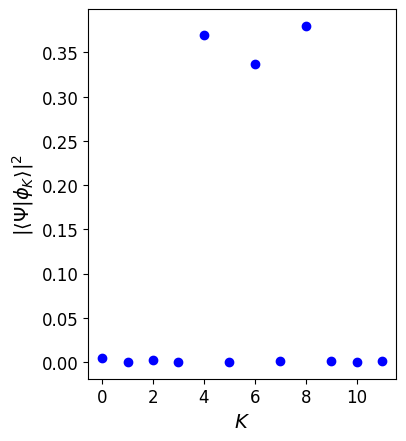

In [44]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 12)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title with increased font size
plt.xlabel(r'$K$', fontsize=14)
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(1.2 / plt.gca().get_data_ratio(), adjustable='box')

#plt.savefig("/work/submit/ahmed95/plots_paper/overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()


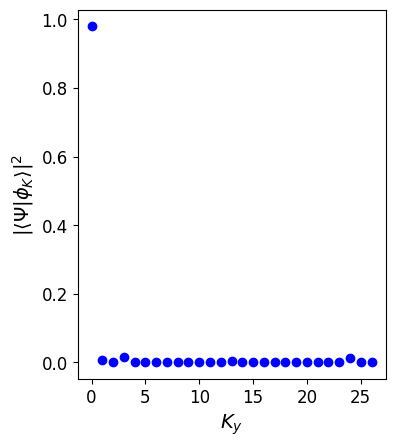

In [26]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 27)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title with increased font size
plt.xlabel(r'$K_y$', fontsize=14)
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(1.2 / plt.gca().get_data_ratio(), adjustable='box')

#plt.savefig("/work/submit/ahmed95/plots_paper/overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()


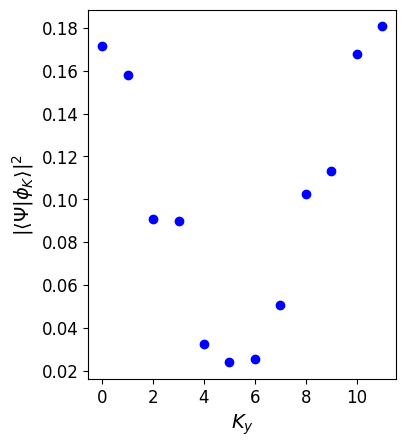

In [36]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 27)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title with increased font size
plt.xlabel(r'$K$', fontsize=14)
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(1.2 / plt.gca().get_data_ratio(), adjustable='box')

#plt.savefig("/work/submit/ahmed95/plots_paper/overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()


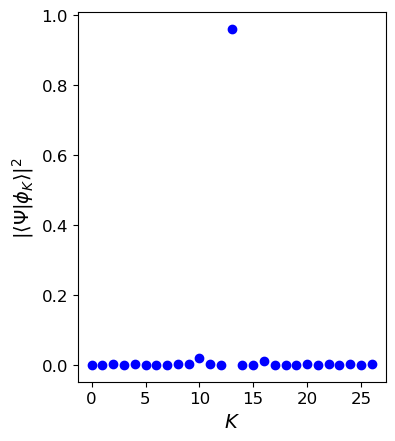

In [68]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 27)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title with increased font size
plt.xlabel(r'$K$', fontsize=14)
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(1.2 / plt.gca().get_data_ratio(), adjustable='box')

#plt.savefig("/work/submit/ahmed95/plots_paper/overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()


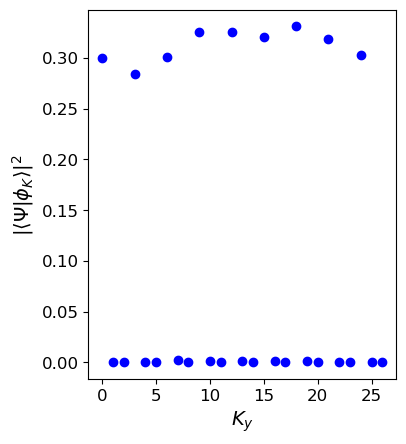

In [47]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 27)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title with increased font size
plt.xlabel(r'$K_y$', fontsize=14)
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(1.2 / plt.gca().get_data_ratio(), adjustable='box')

#plt.savefig("/work/submit/ahmed95/plots_paper/overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()


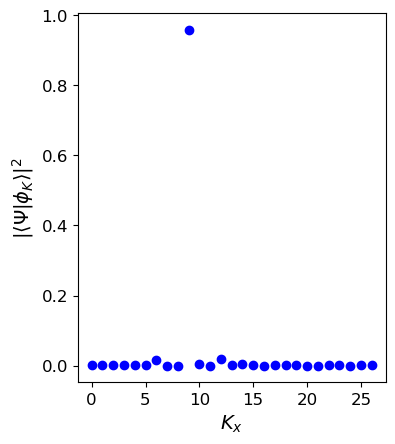

In [58]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 27)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title with increased font size
plt.xlabel(r'$K_x$', fontsize=14)
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(1.2 / plt.gca().get_data_ratio(), adjustable='box')

#plt.savefig("/work/submit/ahmed95/plots_paper/overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()


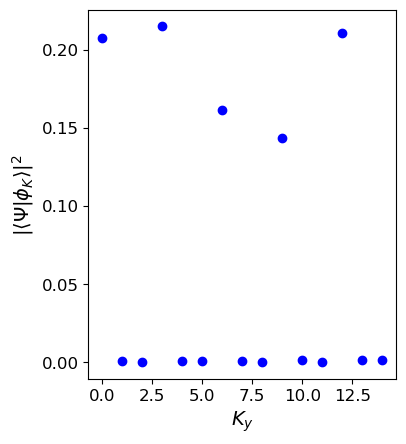

In [64]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 15)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title with increased font size
plt.xlabel(r'$K_y$', fontsize=14)
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(1.2 / plt.gca().get_data_ratio(), adjustable='box')

#plt.savefig("/work/submit/ahmed95/plots_paper/overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()


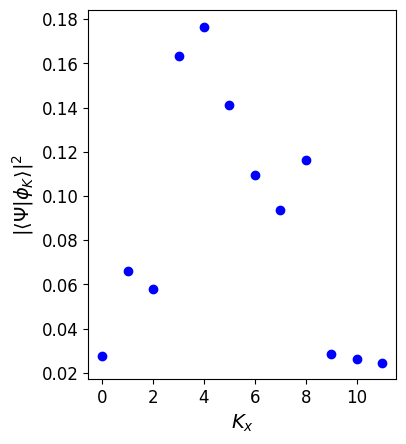

In [29]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 12)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title with increased font size
plt.xlabel(r'$K_x$', fontsize=14)
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(1.2 / plt.gca().get_data_ratio(), adjustable='box')

#plt.savefig("/work/submit/ahmed95/plots_paper/overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()


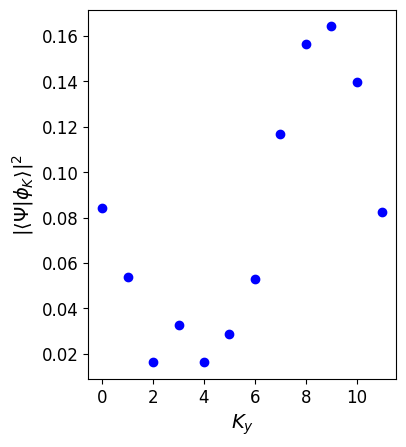

In [31]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 12)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title with increased font size
plt.xlabel(r'$K_y$', fontsize=14)
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$', fontsize=14)

# Increase tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(1.2 / plt.gca().get_data_ratio(), adjustable='box')

#plt.savefig("/work/submit/ahmed95/plots_paper/overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [90]:
-L1-L2

array([-8.08064212, -4.6653609 ])

In [89]:
L2

array([0.        , 9.33072181])

In [91]:
# Compute dot product
dot_product = jnp.dot(L1, -L1-L2)

# Compute norms
norm_L1 = jnp.linalg.norm(L1)
norm_L2 = jnp.linalg.norm(-L1-L2)

# Compute cosine of the angle
cos_theta = dot_product / (norm_L1 * norm_L2)

# Compute angle in radians
angle_rad = jnp.arccos(cos_theta)

# (Optional) Convert to degrees
angle_deg = jnp.degrees(angle_rad)

print("Angle (radians):", angle_rad)
print("Angle (degrees):", angle_deg)

Angle (radians): 2.0943952
Angle (degrees): 120.00001


In [92]:
cfg = get_config(23)
log_network2 = wavefunction_v2(cfg)
norm_den = overlap2(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges)
overlap_value = jnp.abs(overlap(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges))/(jnp.sqrt(norm_den))
overlap_list.append(overlap_value**2)

In [95]:
n_values.append(23)

In [93]:
overlap_list = jnp.array(overlap_list)  # Convert to JAX array
sum_of_squares = jnp.sum(overlap_list)
print(sum_of_squares)

1.0119947


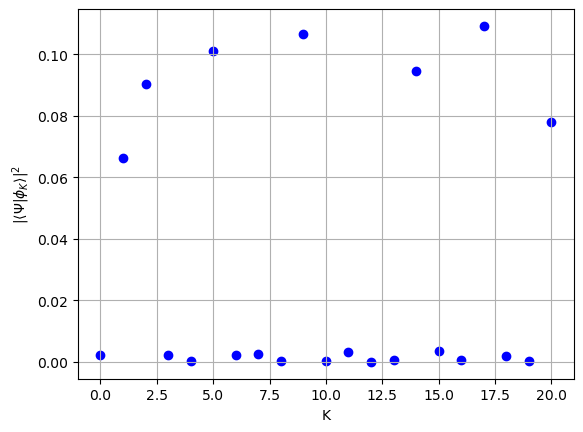

In [68]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 21)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('K')
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$')

# Show the plot
plt.grid(True)
plt.show()

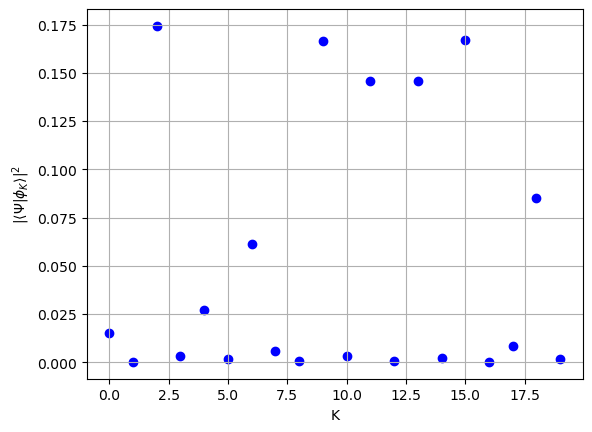

In [83]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(list(range(0, 20)), overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('K')
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$')

# Show the plot
plt.grid(True)
plt.show()

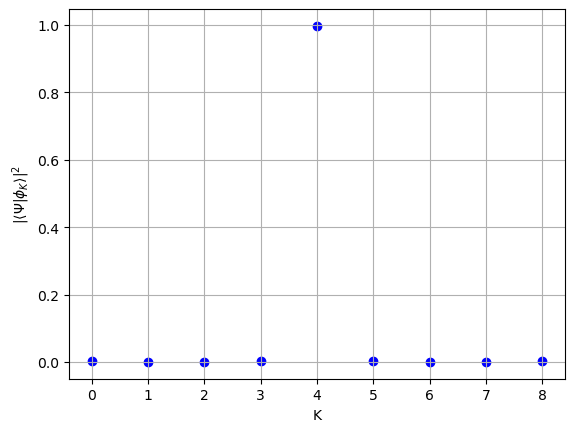

In [80]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(n_values, overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('K')
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$')

# Show the plot
plt.grid(True)
plt.show()

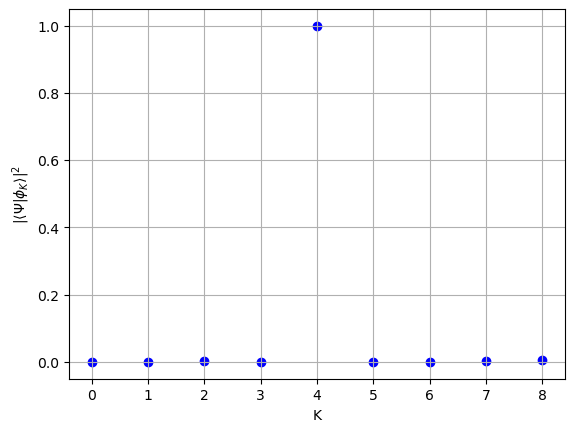

In [108]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(n_values, overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('K')
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$')

# Show the plot
plt.grid(True)
plt.show()

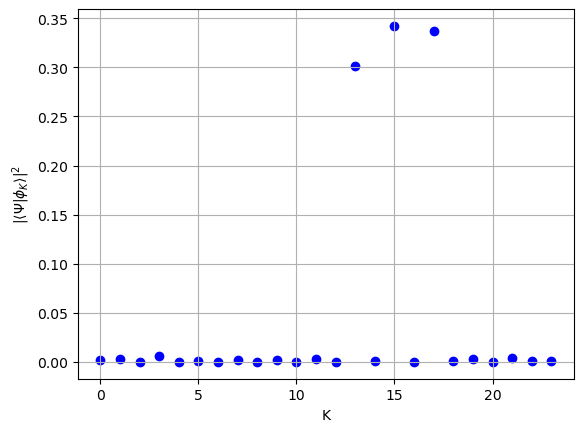

In [97]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(n_values, overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('K')
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$')

# Show the plot
plt.grid(True)
plt.show()

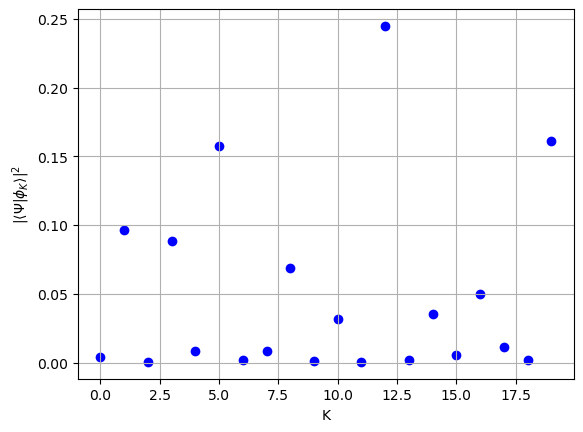

In [24]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(n_values, overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('K')
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$')

# Show the plot
plt.grid(True)
plt.show()

In [27]:
# List of values for n
n_values = list(range(0, 24))

# Initialize an empty list to store the results
results = []

for n in n_values:
    # Construct the file path dynamically
    file_path = f"/work/submit/ahmed95/data/8particles/{n}/train_stats.csv"
    cfg = get_config(n)
    log_network2 = wavefunction_v2(cfg)
    norm_den = overlap2(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges)
    try:
        # Load the data
        data = pd.read_csv(file_path)
        
        # Process the 'energy' column
        data['energy'] = data['energy'].str.replace(r'[()]', '', regex=True)
        data.iloc[:, 1] = data.iloc[:, 1].apply(complex)
        
        # Calculate the average of the second column
        average = data.iloc[:, 1].mean()
        
        # Append the result as a tuple (n, average) to the results list
        results.append([n, average/(norm_den)])
    except FileNotFoundError:
        print(f"File not found for n = {n}: {file_path}")
    except Exception as e:
        print(f"An error occurred for n = {n}: {e}")

# Convert the results list into a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['n', 'average'])

# Sort results_df by the 'average' column in descending order
results_df = results_df.sort_values(by='average', ascending=True)

# Print the sorted DataFrame
print(results_df)

     n                      average
13  13  (0.18967132-1.2975213e-06j)
15  15  (0.21682489-1.2443975e-06j)
17  17   (0.22111766+7.034968e-07j)
5    5    (24.58869+0.00026289036j)
21  21    (27.949326+7.315342e-05j)
23  23   (29.438982+4.4483844e-05j)
3    3    (29.53949+0.00031589554j)
11  11   (29.693472-0.00015320136j)
19  19   (30.906012+0.00018024295j)
1    1    (32.39863-2.2413169e-05j)
9    9     (33.46765-2.313128e-05j)
7    7    (37.07702+0.00028903058j)
6    6       (723.9134-0.00833223j)
8    8      (880.8774-0.010135654j)
2    2      (881.6166-0.010150363j)
0    0     (886.51843-0.009930321j)
22  22      (947.2333+0.008922669j)
10  10      (954.6299-0.010691036j)
4    4     (1004.7083-0.011560329j)
12  12   (1030.6686+0.00034661288j)
16  16     (1063.4728-0.007160265j)
20  20    (1082.8794+0.0128662195j)
18  18   (1101.0458+0.00066475134j)
14  14       (1211.347-0.01077064j)


In [117]:
import matplotlib.pyplot as plt

# Assuming results_df is already created and contains 'n' and 'average' columns
plt.scatter(results_df['n'],jnp.real(average_array) ,color='blue', marker='o')

# Add labels and title
plt.xlabel('n')
plt.ylabel('E')

# Show the plot
plt.show()

TypeError: Error interpreting argument to <function real at 0x7fb5217e5120> as an abstract array. The problematic value is of type <class 'numpy.ndarray'> and was passed to the function at path val.
This typically means that a jit-wrapped function was called with a non-array argument, and this argument was not marked as static using the static_argnums or static_argnames parameters of jax.jit.

# Projection onto a rotational eigenvalues

In [24]:
import numpy as np
import jax.numpy as jnp

def rotate_positions(pos, angle):
    """
    Rotate the positions by a given angle.

    Args:
        pos: Flattened array of positions (N*2 for N particles in 2D).
        angle: Rotation angle in radians.

    Returns:
        Rotated positions as a flattened array (N*2).
    """
    # Reshape the flattened array into (N, 2)
    pos = pos.reshape(-1, 2)
    
    # Define the rotation matrix
    rotation_matrix = jnp.array([
        [jnp.cos(angle), -jnp.sin(angle)],
        [jnp.sin(angle), jnp.cos(angle)]
    ])
    
    # Perform the rotation
    rotated_pos = jnp.dot(pos, rotation_matrix.T)
    
    # Flatten the rotated positions back to (N*2)
    return rotated_pos.flatten()

def construct_rotation_eigstate(f, n, m):
    """
    Construct the wavefunction projected onto the eigenvalues of C_n rotations.

    Args:
        f: A FermiNet-like model that returns phase and magnitude.
        n: Order of the rotation (e.g., 4 for C_4 symmetry).
        m: The m-th eigenvalue of the C_n rotation.

    Returns:
        A function `rotation_eig_state` that computes the log of the wavefunction.
    """
    # Compute the rotation angle for C_n symmetry
    rotation_angle = 2 * jnp.pi / n
    eigenvalue = jnp.exp(1j * 2 * jnp.pi * m / n)

    def log_network_original(*args, **kwargs):
        """
        Compute the log of the network output.
        """
        phase, mag = f(*args, **kwargs)
        return mag + 1.j * phase

    def rotation_eig_state(params, pos, spins, atoms, charges):
        """
        Compute the log of the wavefunction projected onto the eigenvalues of C_n rotations.
        """
        N = pos.shape[0] // 2  # Assuming 2D
        rotated_psi_sum = jnp.sum(
            jnp.array([
                jnp.exp(
                    1j * jnp.dot(jnp.array([m]), eigenvalue) +
                    log_network_original(params, rotate_positions(pos, k * rotation_angle), spins, atoms, charges)
                )
                for k in range(n)
            ])
        )
        return jnp.log(rotated_psi_sum) - jnp.log(n)  # Normalize by the number of rotations

    return rotation_eig_state
    
def construct_rotation_eigstate_from_log(log_f, n, m):
    """
    Construct the wavefunction projected onto the eigenvalues of C_n rotations,
    using the log of the network directly.

    Args:
        log_f: A function that directly returns the log of the wavefunction.
        n: Order of the rotation (e.g., 4 for C_4 symmetry).
        m: The m-th eigenvalue of the C_n rotation.

    Returns:
        A function `rotation_eig_state` that computes the log of the wavefunction.
    """
    # Compute the rotation angle for C_n symmetry
    rotation_angle = 2 * jnp.pi / n
    eigenvalue = jnp.exp(1j * 2 * jnp.pi * m / n)

    def rotation_eig_state(params, pos, spins, atoms, charges):
        """
        Compute the log of the wavefunction projected onto the eigenvalues of C_n rotations.
        """
        # Precompute all rotated positions
        rotated_positions = [
            rotate_positions(pos, k * rotation_angle) for k in range(n)
        ]

        # Compute the sum of rotated wavefunctions
        rotated_psi_sum = jnp.sum(
            jnp.array([
                jnp.exp(
                    1j * m * k * 2 * jnp.pi / n + 
                    log_f(params, rotated_positions[k], spins, atoms, charges)
                )
                for k in range(n)
            ])
        )
        return jnp.log(rotated_psi_sum) - jnp.log(n)  # Normalize by the number of rotations

    return rotation_eig_state

In [170]:
def get_config(momind):
  # Get default options.
  cfg = base_config.default()
  cfg.system.electrons = (18, 0)
  cfg.system.ndim = 2
  # A ghost atom at the origin defines one-electron coordinate system.
  # Element 'X' is a dummy nucleus with zero charge
  cfg.system.molecule = [system.Atom("X", (0., 0.,))]
  # Pretraining is not currently implemented for systems in PBC
  cfg.pretrain.method = None

  """ Defining the potential unit cell and the supercell """
  a0 = 1.0
  a1 = a0 * np.array([np.sqrt(3)/2,-0.5])
  #a1 = a0* np.array([1,0])
  a2 = a0 * np.array([0,1])
  Tmatrix = np.array([[3,-3], [3, 6]]) 
  lattice = lattice_vecs(a1, a2, Tmatrix)
  potential_lattice = lattice_vecs(a1, a2, np.array([[1,0], [0, 1]]))
  #kpoints = envelopes.make_kpoints(lattice, cfg.system.electrons)

  """Defining KE, potential and interaction parameters"""
  meff = 1.0
  KE_prefactor = hbar2_over_m_eff(meff)
  pp_coffs = np.array([0.0, 0.0, 0.0])  
  pp_phases = np.array([0.0, 0.0, 0.0])
  intcoff = (coulomb_prefactor(5.0))/KE_prefactor
  cfg.system.make_local_energy_fn = "ferminet.pbc.Hamiltonian_minimalChern.local_energy"
  cfg.system.make_local_energy_kwargs = {"lattice": lattice, "heg": True,"potential_kwargs": {"laplacian_method": "folx","interaction_energy_scale": intcoff},"kinetic_energy_kwargs": {"prefactor": KE_prefactor}, "periodic_lattice": potential_lattice,"periodic_potential_kwargs": {"coefficients": pp_coffs, "phases": pp_phases}}
  cfg.network.network_type = "psiformer"
  cfg.network.complex = True
  cfg.network.psiformer.num_layers = 3
  cfg.network.psiformer.num_heads = 6
  cfg.network.psiformer.heads_dim = 64
  cfg.network.psiformer.mlp_hidden_dims  = (256,)
  cfg.network.determinants = 4
  cfg.batch_size = 2048
  cfg.optim.iterations = 1000000
  cfg.optim.lr.rate = 0.0001
  cfg.optim.lr.decay = 0.0
  cfg.optim.lr.delay = 1.0
  cfg.initialization.donor_filename = "none"
  cfg.log.save_frequency = 120
  cfg.targetmom.mom = momind
  cfg.targetmom.kwargs = {"abs_lattice": Tmatrix, "unit_cell_vectors": jnp.array([a1,a2]), "logsumtrick": True}
  cfg.network.make_feature_layer_fn = (
      "ferminet.pbc.feature_layer.make_pbc_feature_layer")
  cfg.network.make_feature_layer_kwargs = {
      "lattice": lattice,
      "include_r_ae": False,
  }
  cfg.network.jastrow = 'none'
  cfg.network.make_envelope_fn = ( "ferminet.envelopes.make_null_envelope" )
  #cfg.network.make_envelope_kwargs = {"kpoints": kpoints}
  cfg.network.full_det = True
  return cfg

In [171]:
log_network = wavefunction(get_config(None))

In [137]:
log_network2 = construct_rotation_eigstate_from_log(log_network,2,0)

In [26]:
overlap2(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges)


Array(1.0142841, dtype=float32)

In [23]:
log_network(gathered_params, reshaped_positions[0], reshaped_spins[0], reshaped_atoms[0], reshaped_charges[0]) 

Array(33.93298+1.1148003j, dtype=complex64)

In [24]:
log_network2(gathered_params, reshaped_positions[0], reshaped_spins[0], reshaped_atoms[0], reshaped_charges[0]) 

Array(33.906834+0.98383784j, dtype=complex64)

In [25]:
rotated_positions = rotate_positions(reshaped_positions[0], 2*jnp.pi/2)

In [27]:
reshaped_positions[0]

Array([  3.0176814, -23.21885  , -16.899467 ,  12.237685 ,  -5.631905 ,
        18.960375 ,  14.465635 , -16.794563 ,  -2.0180018, -19.051998 ,
        12.72719  ,  24.356207 ,  -1.175077 ,  59.383705 , -25.710037 ,
        67.45339  , -13.436771 ,  16.44259  ], dtype=float32)

In [28]:
rotated_positions

Array([ -3.0176835,  23.21885  ,  16.89947  , -12.237683 ,   5.6319065,
       -18.960375 , -14.465637 ,  16.794561 ,   2.0180001,  19.051998 ,
       -12.727188 , -24.356209 ,   1.1750822, -59.383705 ,  25.710043 ,
       -67.45339  ,  13.436773 , -16.442589 ], dtype=float32)

In [26]:
log_network(params, rotated_positions, reshaped_spins[0], reshaped_atoms[0], reshaped_charges[0])

In [33]:
n_values = list(range(0, 6))
overlap_list = []
for n in n_values:
    log_network2 = construct_rotation_eigstate_from_log(log_network, 6, n)
    norm_den = overlap2(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges)
    overlap_value = jnp.abs(overlap(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges))/(jnp.sqrt(norm_den))
    print(n,overlap_value**2)
    overlap_list.append(overlap_value**2)

0 0.0108052185
1 0.44747898
2 0.0059099756
3 0.020210978
4 0.43171057
5 0.004313234


In [34]:
jnp.sum(jnp.array(overlap_list))

Array(0.920429, dtype=float32)

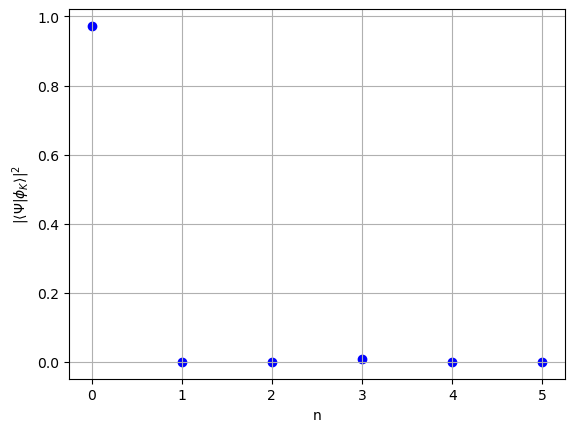

In [94]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(n_values, overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('n')
plt.ylabel(r'$|\langle Ψ|\phi_K \rangle|^2$')

# Show the plot
plt.grid(True)
plt.show()

In [35]:
n_values = list(range(0, 3))
overlap_list = []
for n in n_values:
    log_network2 = construct_rotation_eigstate_from_log(log_network, 3, n)
    norm_den = overlap2(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges)
    overlap_value = jnp.abs(overlap(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges))/(jnp.sqrt(norm_den))
    print(n,overlap_value**2)
    overlap_list.append(overlap_value**2)

0 0.040490337
1 0.94548947
2 0.012298412


In [96]:
jnp.sum(jnp.array(overlap_list))

Array(0.9884594, dtype=float32)

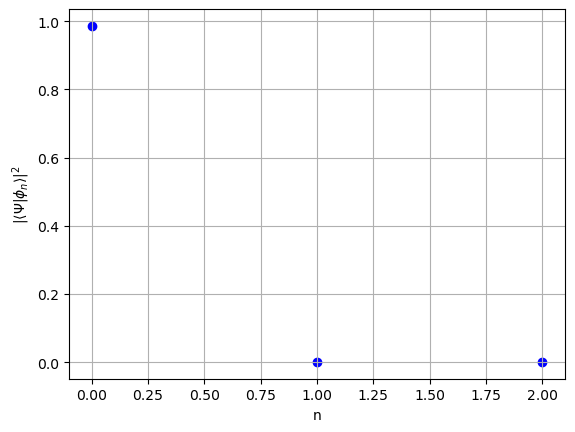

In [97]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(n_values, overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('n')
plt.ylabel(r'$|\langle Ψ|\phi_n \rangle|^2$')
#plt.ylim(0,0.45)
# Show the plot
plt.grid(True)
plt.show()

In [36]:
n_values = list(range(0, 2))
overlap_list = []
for n in n_values:
    log_network2 = construct_rotation_eigstate_from_log(log_network, 2, n)
    norm_den = overlap2(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges)
    overlap_value = jnp.abs(overlap(log_network,log_network2,gathered_params,gathered_params,reshaped_positions_mapped,reshaped_spins,reshaped_atoms,reshaped_charges))/(jnp.sqrt(norm_den))
    print(n,overlap_value**2)
    overlap_list.append(overlap_value**2)

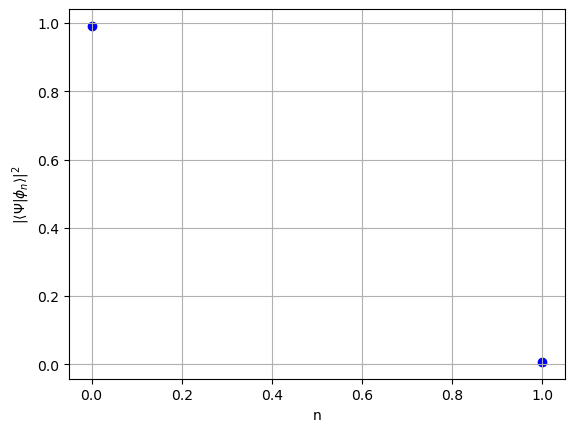

In [99]:
import matplotlib.pyplot as plt

# Assuming n_values and overlap_list are already populated
plt.scatter(n_values, overlap_list, marker='o', linestyle='-', color='b')

# Add labels and title
plt.xlabel('n')
plt.ylabel(r'$|\langle Ψ|\phi_n \rangle|^2$')
#plt.ylim(0,0.45)
# Show the plot
plt.grid(True)
plt.show()

# Chern number from polarization

In [22]:
def z_operator(log_psi, params, samples, spins, atoms, charges, g):
    """
    Compute the expectation value <psi|Z(g)|psi>.

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        g: (2,) array for reciprocal lattice vector

    Returns:
        Expectation value <psi|Z(g)|psi>.
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        """
        Compute the contribution for a single sample by summing over all particle positions
        and applying the phase factor exp(i * g · sum(r_j)).
        
        Args:
            sample_coords: (N, 2) array of particle positions for a single sample.
            sample_spin, sample_atoms, sample_charges: Additional sample-specific features (unused here).
        
        Returns:
            Complex contribution for the sample.
        """
        # Sum over all particle positions
        total_position = jnp.sum(sample_coords, axis=0)  # Sum over all particles' positions

        # Compute the phase factor
        phase = jnp.exp(1j * jnp.dot(g, total_position))

        return phase

    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)  # Take the mean of the contributions

def compute_z_ratio(log_psi, params, samples, spins, atoms, charges, g1, g2):
    """
    Compute the ratio:
        <psi|Z(g1+g2)|psi> / (<psi|Z(g1)|psi> * <psi|Z(g2)|psi>)

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        g1, g2: (2,) arrays for reciprocal lattice vectors

    Returns:
        Ratio of expectation values as described above.
    """
    # Compute g1 + g2
    g_sum = g1 + g2

    # Compute expectation values
    z_g1 = z_operator(log_psi, params, samples, spins, atoms, charges, g1)
    z_g2 = z_operator(log_psi, params, samples, spins, atoms, charges, g2)
    z_g_sum = z_operator(log_psi, params, samples, spins, atoms, charges, g_sum)
    # Compute the ratio
    ratio = z_g_sum / (z_g1 * z_g2)

    return ratio

In [64]:
rec

Array([[1.8137994 , 0.        ],
       [0.60459983, 1.0471976 ]], dtype=float32)

In [65]:
zratio = compute_z_ratio(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, rec[0,:], rec[1,:])

In [66]:
reshaped_positions_mapped.shape

(10240, 16)

In [67]:
arg = cmath.phase(zratio)
print(arg/jnp.pi)

0.037457606151478876


In [25]:
arg = cmath.phase(zratio)
print(arg/jnp.pi)

-0.12529549491988584


In [130]:
arg = cmath.phase(zratio)
print(arg/jnp.pi)

0.5836002226666591


In [154]:
arg = cmath.phase(zratio)
print(arg/jnp.pi)

-0.08481495267210226


In [23]:
def _sc_lattice_vecs_triang(rs: float, nelec: int) -> np.ndarray:
    """Returns triangular lattice vectors with Wigner-Seitz radius rs in 2D."""
    # Calculate the area of the system
    area = np.pi * (rs**2) * nelec  # Total area of the system in 2D
    
    # Calculate the lattice constant 'a' for a triangular lattice
    a = (2 * area / np.sqrt(3))**(1 / 2)
    
    # Define the lattice vectors for a triangular lattice
    lattice_vecs = np.array([
        [a, 0],                # First lattice vector
        [a / 2, a * np.sqrt(3) / 2]  # Second lattice vector
    ])
    
    return lattice_vecs

# n(k) and 1RDM (no projection)

In [34]:
def one_rdm_binned(log_psi, params, samples, spins, atoms, charges,
                   r1, r2, h):
    """
    Estimate <c^\dagger(r1) c(r2)> using binning and wavefunction ratios.

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        r1, r2: (2,) arrays for positions
        h: bin width for Gaussian smoothing
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    # Precompute distance weights for r2
    dist_r2 = jnp.linalg.norm(coords - r2[None, None, :], axis=-1)  # (M, N)
    weights_r2 = jnp.exp(-0.5 * (dist_r2 / h) ** 2) /(2 * np.pi * h**2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges, w_r2):
        contrib = 0.0 + 0.0j

        def particle_update(i, acc):
            w = w_r2[i]
            def move_particle():
                new_coords = sample_coords.at[i].set(r1)
                psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                return acc + jnp.exp(psi_mod - psi_ref) * w
            return jax.lax.cond(w > 1e-8, move_particle, lambda: acc)

        contrib = jax.lax.fori_loop(0, N, particle_update, contrib)
        return contrib

    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges, weights_r2)
    return jnp.mean(contribs)


def momentum_occupation(log_psi, params, samples, spins, atoms, charges, k, grid, h):
    """
    Evaluate the momentum occupation at momentum k.

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        k: (2,) array for momentum vector
        grid: (G, 2) array of spatial grid points to evaluate rho(r, 0)
        h: bin width for Gaussian smoothing

    Returns:
        n_k: Momentum occupation at momentum k
    """
    def rho_r(r):
        # Compute rho(r, 0) using one_rdm_binned
        return one_rdm_binned(log_psi, params, samples, spins, atoms, charges, r, jnp.zeros_like(r), h)

    # Compute rho(r, 0) on the grid
    rho_values = jax.vmap(rho_r)(grid)  # (G,)

    # Compute the Fourier transform: n(k) = sum_r e^(-i k·r) * rho(r, 0)
    phase_factors = jnp.exp(-1j * jnp.dot(grid, k))  # (G,)
    n_k = jnp.sum(phase_factors * rho_values) * (grid[1, 0] - grid[0, 0])**2  # Approximate integral

    return n_k

def momentum_occupation_integrated(log_psi, params, samples, spins, atoms, charges, k, grid):
    """
    Estimate n(k) by integrating over r1.

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        k: (2,) array for momentum vector
        grid: (G, 2) array of spatial grid points to integrate over r1
        h: bin width for Gaussian smoothing

    Returns:
        n_k: Momentum occupation at momentum k
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        contrib = 0.0 + 0.0j
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        
        def particle_update(r2ind, r2, acc):
            # Compute the contribution for a fixed r2
            def integrand(r1):
                delta_r = r1 - r2
                delta_r = map_to_supercell_jax(delta_r[None, :], lattice)[0]  # Map to supercell
                phase = jnp.exp(1j * jnp.dot(k, delta_r))
                # Compute the wavefunction ratio
                new_coords = sample_coords.at[r2ind].set(r1)  # Replace r2 with r1
                psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                return phase * jnp.exp(psi_mod - psi_ref)

            # Integrate over r1 using the grid
            integrand_values = jax.vmap(integrand)(grid)  # (G,)
            integral = jnp.sum(integrand_values) * (grid[1, 0] - grid[0, 0])**2  # (fix this)
            return acc + integral

        # Loop over all particles in the sample
        contrib = jax.lax.fori_loop(0, N, lambda i, acc: particle_update(i,sample_coords[i], acc), contrib)
        return contrib

    # Compute contributions for all samples
    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)
    
def momentum_occupation_integrated2(log_psi, params, samples, spins, atoms, charges, k, grid):
    """
    Estimate n(k) by fixing r1, summing over all samples, and then integrating over r1.

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        k: (2,) array for momentum vector
        grid: (G, 2) array of spatial grid points to integrate over r1

    Returns:
        n_k: Momentum occupation at momentum k
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def integrand(r1):
        """
        Compute the contribution to the integral for a fixed r1.
        """
        def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
            contrib = 0.0 + 0.0j
            psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)

            def particle_update(r2ind, r2, acc):
                delta_r = r1 - r2
                delta_r = map_to_supercell_jax(delta_r[None, :], lattice)[0]  # Map to supercell
                phase = jnp.exp(1j * jnp.dot(k, delta_r))

                # Compute the wavefunction ratio
                new_coords = sample_coords.at[r2ind].set(r1)  # Replace r2 with r1
                psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                return acc + phase * jnp.exp(psi_mod - psi_ref)

            # Loop over all particles in the sample
            contrib = jax.lax.fori_loop(0, N, lambda i, acc: particle_update(i, sample_coords[i], acc), contrib)
            return contrib

        # Sum over all samples for the fixed r1
        sample_contributions = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
        return jnp.mean(sample_contributions)

    # Compute the integral over r1 using the grid
    integrand_values = jax.vmap(integrand)(grid)  # (G,)
    integral = jnp.sum(integrand_values) * (grid[1, 0] - grid[0, 0])**2  # (fix this)

    return integral



In [ ]:
r1 = jnp.array([0.5, 0.5])
r2 = jnp.array([1.0, 1.0]) 
rdm_1 = one_rdm_binned(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins,reshaped_atoms,reshaped_charges, r1, r1, h=0.01)
print(rdm_1)

(1.0551115+0.0060542123j)


# Structure Factor

In [28]:

def structure_factor(log_psi, params, samples, spins, atoms, charges, k):
    """
    Estimate structure factor

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        k: (2,) array for momentum vector

    Returns:
        n_k: structure factor at momentum k
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        contrib = 0.0 + 0.0j

        def particle_pair_update(pair, acc):
            i, j = pair
            r1 = sample_coords[i]
            r2 = sample_coords[j]
            delta_r = r1 - r2
            phase = jnp.exp(1j * jnp.dot(k, delta_r))

            # Compute the wavefunction ratio
            return acc + phase 

        # Generate all pairs (i, j), including i = j
        pairs = jnp.array(jnp.meshgrid(jnp.arange(N), jnp.arange(N))).T.reshape(-1, 2)
        contrib = jax.lax.fori_loop(0, len(pairs), lambda idx, acc: particle_pair_update(pairs[idx], acc), contrib)
        return contrib

    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)

In [32]:
g1 = rec[0,:]  # Example vector
g2 = rec[1,:]  # Example vector
# Define the range for m and n
m_range = np.arange(-7, 7)  # Range for m (e.g., 0 to 4)
n_range = np.arange(-7, 7)  # Range for n (e.g., 0 to 9)

# Create a grid of m and n values
m_grid, n_grid = np.meshgrid(m_range, n_range)

# Compute k = m * g1 + n * g2 for all combinations
kgrid = m_grid[..., None] * g1 + n_grid[..., None] * g2  # Shape: (len(n_range), len(m_range), 2)

# Flatten the grid to get a list of k points
kgrid = kgrid.reshape(-1, 2)  # Shape: (num_k_points, 2)

In [33]:
kgrid

Array([[-4.713708  , -2.7214608 ],
       [-4.2647834 , -2.7214608 ],
       [-3.8158588 , -2.7214608 ],
       [-3.3669343 , -2.7214608 ],
       [-2.9180098 , -2.7214608 ],
       [-2.4690852 , -2.7214608 ],
       [-2.0201607 , -2.7214608 ],
       [-1.571236  , -2.7214608 ],
       [-1.1223115 , -2.7214608 ],
       [-0.6733869 , -2.7214608 ],
       [-0.22446227, -2.7214608 ],
       [ 0.22446227, -2.7214608 ],
       [ 0.67338693, -2.7214608 ],
       [ 1.1223115 , -2.7214608 ],
       [-4.489246  , -2.3326807 ],
       [-4.0403214 , -2.3326807 ],
       [-3.5913968 , -2.3326807 ],
       [-3.142472  , -2.3326807 ],
       [-2.6935475 , -2.3326807 ],
       [-2.244623  , -2.3326807 ],
       [-1.7956983 , -2.3326807 ],
       [-1.3467737 , -2.3326807 ],
       [-0.8978492 , -2.3326807 ],
       [-0.4489246 , -2.3326807 ],
       [ 0.        , -2.3326807 ],
       [ 0.44892454, -2.3326807 ],
       [ 0.8978492 , -2.3326807 ],
       [ 1.3467737 , -2.3326807 ],
       [-4.2647834 ,

In [22]:
structure_factor(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, jnp.array([0.0,0.0]))

Array(81.+0.j, dtype=complex64)

In [34]:
sq_list = []
for k in kgrid:
    result = structure_factor(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, k)
    print(k, result)
    sq_list = np.append(sq_list, result) 

[-4.713708  -2.7214608] (11.748777+4.0018904e-08j)
[-4.2647834 -2.7214608] (11.675819+7.469225e-09j)
[-3.8158588 -2.7214608] (11.947814-1.1754082e-08j)
[-3.3669343 -2.7214608] (12.329517-5.705033e-09j)
[-2.9180098 -2.7214608] (11.625763+5.9353766e-10j)
[-2.4690852 -2.7214608] (12.214291-4.2240572e-08j)
[-2.0201607 -2.7214608] (11.947677+2.1198048e-08j)
[-1.571236  -2.7214608] (11.498171+2.1590663e-08j)
[-1.1223115 -2.7214608] (12.838115-3.2271828e-08j)
[-0.6733869 -2.7214608] (11.740074+8.271252e-08j)
[-0.22446227 -2.7214608 ] (11.768618-2.8516183e-08j)
[ 0.22446227 -2.7214608 ] (12.063424+2.692559e-08j)
[ 0.67338693 -2.7214608 ] (11.814231-9.313339e-09j)
[ 1.1223115 -2.7214608] (12.679386+6.1529732e-09j)
[-4.489246  -2.3326807] (11.510786+8.322559e-09j)
[-4.0403214 -2.3326807] (11.877899-1.9376728e-08j)
[-3.5913968 -2.3326807] (11.556019-1.6758236e-08j)
[-3.142472  -2.3326807] (11.840645-1.1070824e-09j)
[-2.6935475 -2.3326807] (12.462877-1.6461854e-09j)
[-2.244623  -2.3326807] (11.920

In [23]:
sorted_sq = sorted(sq_list/12, key=lambda x: x.real, reverse=True)
#print(sorted_sq)

In [29]:
sorted_sq[0:8]

[np.complex128(9+0j),
 np.complex128(3.4332025316026473+6.98750884314197e-10j),
 np.complex128(3.4332025316026473-6.98750884314197e-10j),
 np.complex128(3.3688566419813366+4.515527507464867e-09j),
 np.complex128(3.3688566419813366-4.515527507464867e-09j),
 np.complex128(3.3196122911241317-1.2843075738702383e-09j),
 np.complex128(3.3196122911241317+1.2843075738702383e-09j),
 np.complex128(1.2802689870198567-4.419575816427823e-10j)]

In [57]:
import numpy as np

def apply_c6_symmetry(k):
    """Generate all k-points related to k by C6 symmetry."""
    c6_rotations = [
        np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        for theta in np.linspace(0, 2 * np.pi, 6, endpoint=False)
    ]
    return [rotation @ k for rotation in c6_rotations]

sq_list = []
for k in kgrid:
    # Generate all C6-related k-points
    c6_k_points = apply_c6_symmetry(k)
    
    # Compute structure factor for all C6-related k-points
    results = [
        structure_factor(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, k_c6)
        for k_c6 in c6_k_points
    ]
    
    # Average the results
    averaged_result = np.mean(results)
    
    # Print and append the averaged result
    print(k, averaged_result)
    sq_list = np.append(sq_list, averaged_result)

[-4.713708   2.7214606] (18.284117+0j)
[-4.713708   1.9439003] (17.923735+0j)
[-4.713708   1.1663401] (17.749498+0j)
[-4.713708    0.38877988] (18.188503+0j)
[-4.713708   -0.38878036] (18.206833+0j)
[-4.713708  -1.1663406] (17.865225+0j)
[-4.713708  -1.9439008] (17.9763-2.9605948e-16j)
[-4.713708 -2.721461] (18.284117-1.1842379e-15j)
[-4.713708  -3.4990213] (18.064728+0j)
[-4.713708 -4.276582] (18.225513+0j)
[-4.713708 -5.054142] (18.03523+0j)
[-4.713708 -5.831702] (18.141039+0j)
[-4.713708  -6.6092625] (17.759346+0j)
[-4.713708  -7.3868227] (17.986776+0j)
[-4.0403214  3.1102407] (17.976297-2.9605948e-16j)
[-4.0403214  2.3326805] (18.468664+0j)
[-4.0403214  1.5551202] (17.954987+5.9211896e-16j)
[-4.0403214  0.77756  ] (17.987127+0j)
[-4.0403214e+00 -2.3841858e-07] (18.088266+0j)
[-4.0403214 -0.7775605] (17.76875+0j)
[-4.0403214 -1.5551207] (18.355324+0j)
[-4.0403214 -2.332681 ] (18.468664+5.9211896e-16j)
[-4.0403214 -3.1102412] (17.923733-5.9211896e-16j)
[-4.0403214 -3.8878014] (17.969

In [87]:
np.save('/work/submit/ahmed95/plots_paper/sq_list_9particles.npy', sq_list_9particles)

In [25]:
sq_list_8particles = []
for k in kgrid:
    # Compute structure factor for k
    result_k = structure_factor(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, k)
    
    # Compute structure factor for -k
    result_neg_k = structure_factor(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, -k)
    
    # Average the results
    averaged_result = (result_k + result_neg_k) / 2
    
    # Print and append the averaged result
    print(k, averaged_result)
    sq_list_8particles = np.append(sq_list_8particles, averaged_result)

[-16.928795   -7.3303833] (8.005122+0j)
[-15.114995   -7.3303833] (8.005628+0j)
[-13.301195   -7.3303833] (7.991883+0j)
[-11.487396   -7.3303833] (8.022046+0j)
[-9.673597  -7.3303833] (7.91416+0j)
[-7.8597975 -7.3303833] (8.032544+0j)
[-6.045998  -7.3303833] (8.007792+0j)
[-4.2321987 -7.3303833] (7.915157+0j)
[-2.4183993 -7.3303833] (7.919453+0j)
[-0.60459995 -7.3303833 ] (7.931827+0j)
[ 1.2091994 -7.3303833] (7.9223876+0j)
[ 3.0229988 -7.3303833] (7.924114+0j)
[ 4.8367977 -7.3303833] (7.930021+0j)
[ 6.6505976 -7.3303833] (7.9592786+0j)
[-16.324196   -6.2831855] (8.050089+0j)
[-14.510395   -6.2831855] (7.9924207+0j)
[-12.696595   -6.2831855] (7.9890585+0j)
[-10.882796   -6.2831855] (8.053089+0j)
[-9.068997  -6.2831855] (7.932368+0j)
[-7.2551975 -6.2831855] (7.994965+0j)
[-5.4413986 -6.2831855] (7.921378+0j)
[-3.627599  -6.2831855] (8.281219+0j)
[-1.8137996 -6.2831855] (7.8826866+0j)
[-2.3841858e-07 -6.2831855e+00] (7.912534+0j)
[ 1.8137991 -6.2831855] (7.915525+0j)
[ 3.6275985 -6.28318

In [26]:
np.save('/work/submit/ahmed95/plots_paper/sq_list_8particles.npy', sq_list_8particles)

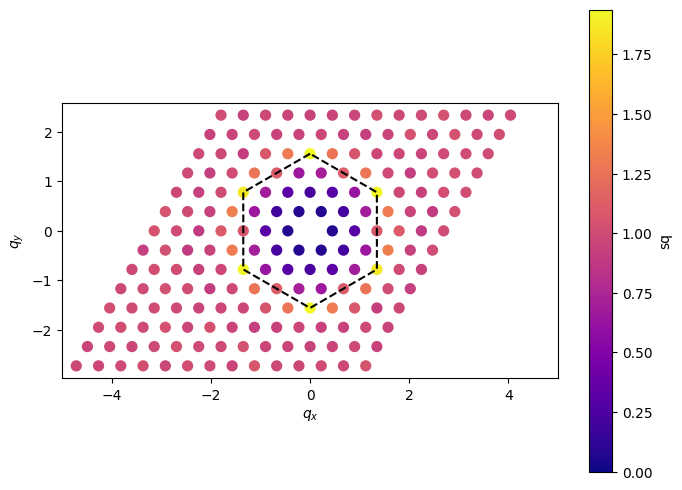

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Remove [0, 0] from kgrid and corresponding values from sq_list
kgrid_filtered = np.array([k for k in kgrid if not np.allclose(k, [0, 0])])
sq_list_filtered = [sq_list[i]/12 for i, k in enumerate(kgrid) if not np.allclose(k, [0, 0])]

# Convert kgrid_filtered to 2D coordinates for plotting
kx = kgrid_filtered[:, 0]
ky = kgrid_filtered[:, 1]

# Define constants
a = np.sqrt((4 * np.pi * 1**2) / np.sqrt(3))  # primitive 1-flux length
dMBZ = (4 * np.pi) / (3 * a)

# Define the hexagon vertices
G11 = dMBZ * np.array([0, 1])
G22 = dMBZ * np.array([-np.sqrt(3)/2, 0.5])
G33 = dMBZ * np.array([-np.sqrt(3)/2, -0.5])
G44 = dMBZ * np.array([0, -1])
G55 = dMBZ * np.array([np.sqrt(3)/2, -0.5])
G66 = dMBZ * np.array([np.sqrt(3)/2, 0.5])

# Create lists of x and y coordinates for the hexagon
xlist = [G11[0], G22[0], G33[0], G44[0], G55[0], G66[0], G11[0]]
ylist = [G11[1], G22[1], G33[1], G44[1], G55[1], G66[1], G11[1]]

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(kx, ky, c=sq_list_filtered, cmap='plasma', s=50, vmin=0, vmax=np.max(np.real(sq_list_filtered)))
plt.plot(xlist, ylist, color='black', linestyle='--', linewidth=1.5, label='Hexagonal Brillouin Zone')

# Add colorbar with custom ticks
cbar = plt.colorbar(scatter, label='sq')

plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
plt.xlim(-5, 5)
plt.gca().set_aspect('equal')
plt.show()

In [45]:
sq_list

array([ 4.12713575-3.60614649e-10j,  3.82560968+1.19734977e-09j,
        4.12491751+5.77904302e-09j,  4.03622723+1.27465682e-09j,
        3.97814322-1.42750878e-09j,  3.91589117+1.52168411e-09j,
        4.00271702-2.74800982e-09j,  4.07992554-5.23868948e-10j,
        4.07091522-1.17097443e-09j,  3.95095325+2.17528395e-09j,
        3.94270968-1.21758603e-09j,  3.89260674+4.19925072e-09j,
        3.99077559-2.62934918e-09j,  3.81617975+7.24838856e-10j,
        4.12826633+3.78372533e-09j,  3.85589838+2.28783392e-09j,
        4.10269547-1.03307229e-09j,  3.8859899 +1.85514182e-09j,
        3.94774318-1.12996190e-09j,  3.95238352+7.03458625e-10j,
        4.11108112-1.21394805e-09j,  3.90440059-1.24782673e-09j,
        4.0942812 -1.20508048e-09j,  3.88176489+4.22356550e-09j,
        4.11018848-4.14490842e-09j,  3.99969077+2.81556822e-09j,
        4.06279659+2.24198970e-09j,  4.00246716-5.03064257e-11j,
        4.05033588+5.57292879e-09j,  3.85618114-3.09961479e-09j,
        4.05574608+3.6891

In [36]:
sorted_sq = sorted(sq_list/12, key=lambda x: x.real, reverse=True)
print(sorted_sq[1:6])
avg = sum(sorted_sq[1:6]) / len(sorted_sq[1:6])
print(avg)

[np.complex128(1.9387704531351724-4.0072715516240953e-10j), np.complex128(1.9387704531351724+4.0072715516240953e-10j), np.complex128(1.9252424240112305+5.435841406627635e-10j), np.complex128(1.9252424240112305-5.435841406627635e-10j), np.complex128(1.8648896217346191+2.248441433039261e-09j)]
(1.9185830752054849+4.496882866078522e-10j)


/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/axes/_axes.py:4733: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


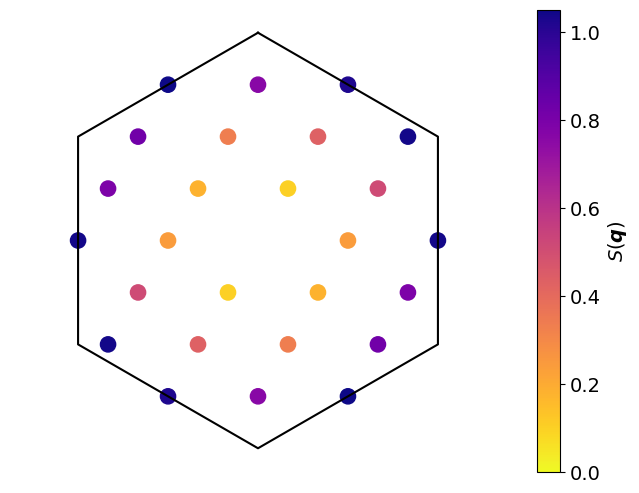

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path

# Remove [0, 0] from kgrid and corresponding values from sq_list
kgrid_filtered = np.array([k for k in kgrid if not np.allclose(k, [0, 0])])
sq_list_filtered = [sq_list[i]/8 for i, k in enumerate(kgrid) if not np.allclose(k, [0, 0])]

# Convert kgrid_filtered to 2D coordinates for plotting
kx = kgrid_filtered[:, 0]
ky = kgrid_filtered[:, 1]

# Define constants
a0 = 1  # Replace with the actual lattice constant if known
dMBZ = (4 * np.pi) / (3 * a0)

# Define the hexagon vertices
G11 = dMBZ * np.array([0, 1])
G22 = dMBZ * np.array([-np.sqrt(3)/2, 0.5])
G33 = dMBZ * np.array([-np.sqrt(3)/2, -0.5])
G44 = dMBZ * np.array([0, -1])
G55 = dMBZ * np.array([np.sqrt(3)/2, -0.5])
G66 = dMBZ * np.array([np.sqrt(3)/2, 0.5])

# Create lists of x and y coordinates for the hexagon
xlist = [G11[0], G22[0], G33[0], G44[0], G55[0], G66[0], G11[0]]
ylist = [G11[1], G22[1], G33[1], G44[1], G55[1], G66[1], G11[1]]

# Define the hexagon as a Path
hexagon_path = Path(np.column_stack((xlist, ylist)))

# Filter points that lie inside or on the boundary of the hexagon
points = np.column_stack((kx, ky))
inside_or_on_boundary = hexagon_path.contains_points(points) | hexagon_path.contains_points(points, radius=1e-1)

kx_filtered = kx[inside_or_on_boundary]
ky_filtered = ky[inside_or_on_boundary]
sq_list_filtered = np.array(sq_list_filtered)[inside_or_on_boundary]

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(kx_filtered, ky_filtered, c=sq_list_filtered, cmap='plasma_r', s=120, vmin=0, vmax=np.max(np.real(sq_list_filtered)))
plt.plot(xlist, ylist, color='black', linewidth=1.5, label='Hexagonal Brillouin Zone')

# Add colorbar with custom ticks
cbar = plt.colorbar(scatter)
cbar.set_label(r'$S(\boldsymbol{q})$', fontsize=14)
cbar.ax.tick_params(labelsize=14)  # Increase the size of the colorbar ticks
plt.xlabel(r'$q_x$')
plt.ylabel(r'$q_y$')
plt.xlim(-5, 5)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.savefig("/work/submit/ahmed95/plots_paper/structurefactor_8particles.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [88]:
sq_list_9particles = np.load('/work/submit/ahmed95/plots_paper/sq_list_9particles.npy')
sq_list_8particles = np.load('/work/submit/ahmed95/plots_paper/sq_list_8particles.npy')

/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


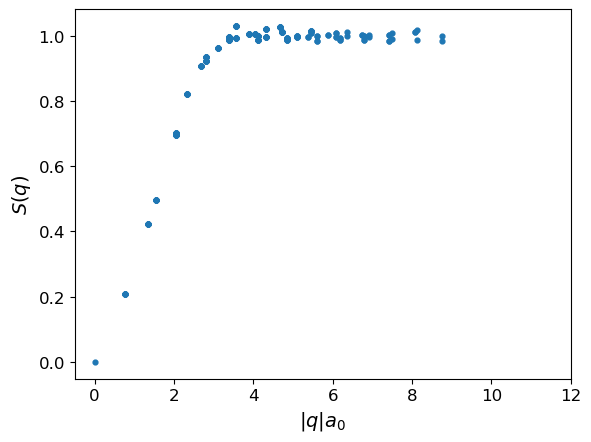

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Remove [0, 0] from kgrid and corresponding values from sq_list
kgrid_filtered = np.array([k for k in kgrid])
sq_list_filtered = [sq_list[i]/18 for i, k in enumerate(kgrid)]

# Compute the norm of each k-point
k_norms = np.linalg.norm(kgrid_filtered, axis=1)

# Set S(k=0) = 0 explicitly
sq_list_filtered = np.array(sq_list_filtered)
sq_list_filtered[k_norms == 0] = 0

# Sort the norms and corresponding structure factor values for better visualization
sorted_indices = np.argsort(k_norms)
k_norms_sorted = k_norms[sorted_indices]
sq_list_sorted = sq_list_filtered[sorted_indices]

# Plot the structure factor as a function of the norm of k-points
plt.figure()
plt.scatter(k_norms_sorted, sq_list_sorted, s = 12)
plt.xlabel(r'$|q|a_0$',fontsize = 14)
plt.ylabel(r'$S(q)$',fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().set_aspect(4)
plt.xlim(-0.5,12)
#plt.savefig("/work/submit/ahmed95/plots_paper/structurefactor_8particles.pdf", format="pdf", bbox_inches="tight")
plt.show()


/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


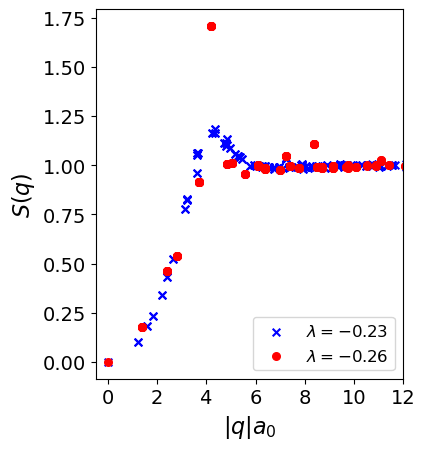

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Remove [0, 0] from kgrid and corresponding values from sq_list_8particles

a0 = 1.0
a1 = a0 * np.array([np.sqrt(3)/2,-0.5])
#a1 = a0* np.array([1,0])
a2 = a0 * np.array([0,1])
# a = np.sqrt((4 * np.pi * 1**2) / np.sqrt(3))  # primitive 1-flux length
# a1 = a * np.array([np.sqrt(3) / 2, -0.5])
# a2 = a * np.array([0, 1.0])
Tmatrix = np.array([[4,0], [0, 6]]) 
lattice = lattice_vecs(a1, a2, Tmatrix)
area_lattice = jnp.abs(jnp.linalg.det(lattice))
potential_lattice = lattice_vecs(a1, a2, np.array([[1,0], [0, 1]]))
area_unitcell = jnp.abs(jnp.linalg.det(potential_lattice))
rec = 2*jnp.pi*jnp.linalg.inv(lattice)



g1 = rec[0,:]  # Example vector
g2 = rec[1,:]  # Example vector
# Define the range for m and n
m_range = np.arange(-7, 7)  # Range for m (e.g., 0 to 4)
n_range = np.arange(-7, 7)  # Range for n (e.g., 0 to 9)

# Create a grid of m and n values
m_grid, n_grid = np.meshgrid(m_range, n_range)

# Compute k = m * g1 + n * g2 for all combinations
kgrid = m_grid[..., None] * g1 + n_grid[..., None] * g2  # Shape: (len(n_range), len(m_range), 2)

# Flatten the grid to get a list of k points
kgrid = kgrid.reshape(-1, 2)  # Shape: (num_k_points, 2)
kgrid_filtered = np.array([k for k in kgrid])



# Process sq_list_8particles
sq_list_8_filtered = [sq_list_8particles[i]/8 for i, k in enumerate(kgrid)]
sq_list_8_filtered = np.array(sq_list_8_filtered)
k_norms = np.linalg.norm(kgrid_filtered, axis=1)
sq_list_8_filtered[k_norms == 0] = 0
sorted_indices_8 = np.argsort(k_norms)
k_norms_sorted_8 = k_norms[sorted_indices_8]
sq_list_sorted_8 = sq_list_8_filtered[sorted_indices_8]

# Process sq_list_9particles

Tmatrix = np.array([[3,-3], [3, 6]]) 
lattice = lattice_vecs(a1, a2, Tmatrix)
area_lattice = jnp.abs(jnp.linalg.det(lattice))
potential_lattice = lattice_vecs(a1, a2, np.array([[1,0], [0, 1]]))
area_unitcell = jnp.abs(jnp.linalg.det(potential_lattice))
rec = 2*jnp.pi*jnp.linalg.inv(lattice)



g1 = rec[0,:]  # Example vector
g2 = rec[1,:]  # Example vector
# Define the range for m and n
m_range = np.arange(-7, 7)  # Range for m (e.g., 0 to 4)
n_range = np.arange(-7, 7)  # Range for n (e.g., 0 to 9)

# Create a grid of m and n values
m_grid, n_grid = np.meshgrid(m_range, n_range)

# Compute k = m * g1 + n * g2 for all combinations
kgrid = m_grid[..., None] * g1 + n_grid[..., None] * g2  # Shape: (len(n_range), len(m_range), 2)

# Flatten the grid to get a list of k points
kgrid = kgrid.reshape(-1, 2)  # Shape: (num_k_points, 2)
kgrid_filtered = np.array([k for k in kgrid])


sq_list_9_filtered = [sq_list_9particles[i]/9 for i, k in enumerate(kgrid)]
sq_list_9_filtered = np.array(sq_list_9_filtered)
k_norms = np.linalg.norm(kgrid_filtered, axis=1)
sq_list_9_filtered[k_norms == 0] = 0
sorted_indices_9 = np.argsort(k_norms)
k_norms_sorted_9 = k_norms[sorted_indices_9]
sq_list_sorted_9 = sq_list_9_filtered[sorted_indices_9]

# Plot for sq_list_8particles
plt.figure()
plt.scatter(k_norms_sorted_8, sq_list_sorted_8, s=30, label=r'$\lambda = -0.23$' , c ='blue',marker = 'x')
plt.scatter(k_norms_sorted_9, sq_list_sorted_9, s=30, label=r'$\lambda = -0.26$', c = 'red')
plt.xlabel(r'$|q|a_0$', fontsize=16)
plt.ylabel(r'$S(q)$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().set_aspect(8)
plt.xlim(-0.5, 12)
plt.legend(fontsize=12,loc='lower right')
#plt.title('Structure Factor for 8 Particles', fontsize=14)
plt.savefig("/work/submit/ahmed95/plots_paper/structurefactor_FCICDW.pdf", format="pdf", bbox_inches="tight")
plt.show()


q^2 coefficient (a): 0.09593333829385248
q^4 coefficient (b): -0.00294451177377903


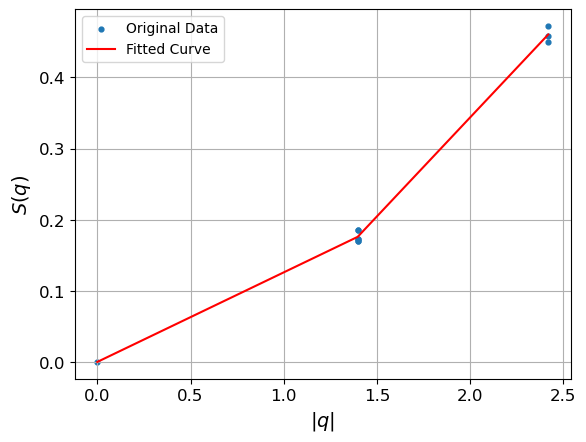

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Remove [0, 0] from kgrid and corresponding values from sq_list
kgrid_filtered = np.array([k for k in kgrid])
sq_list_filtered = [sq_list[i]/9 for i, k in enumerate(kgrid)]

# Compute the norm of each k-point
k_norms = np.linalg.norm(kgrid_filtered, axis=1)

sq_list_filtered = np.array(sq_list_filtered)
sq_list_filtered[k_norms == 0] = 0

# Sort the norms and corresponding structure factor values for better visualization
sorted_indices = np.argsort(k_norms)
k_norms_sorted = k_norms[sorted_indices]
sq_list_sorted = np.array(sq_list_filtered)[sorted_indices]

# Define the fitting function: f(q) = a q^2 + b q^4
def fit_function(q, a, b):
    return a * q**2 + b * q**4

# Fit the data to the function
popt, pcov = curve_fit(fit_function, k_norms_sorted[0:10], sq_list_sorted[0:10])

# Extract the coefficients
a_coefficient, b_coefficient = popt
print(f"q^2 coefficient (a): {a_coefficient}")
print(f"q^4 coefficient (b): {b_coefficient}")

# Compute the fitted curve
fitted_curve = fit_function(k_norms_sorted, *popt)

# Plot the original data and the fitted curve
plt.figure()
plt.scatter(k_norms_sorted[0:10], sq_list_sorted[0:10], s=12, label='Original Data')
plt.plot(k_norms_sorted[0:10], fitted_curve[0:10], color='red', label='Fitted Curve')
plt.xlabel(r'$|q|$', fontsize=14)
plt.ylabel(r'$S(q)$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [47]:
0.09593333829385248*4*np.pi/(27*area_unitcell)

Array(0.05155669, dtype=float32)

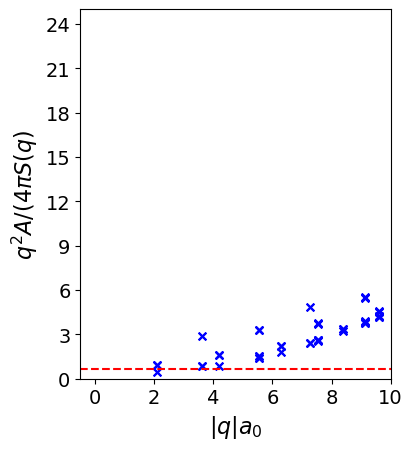

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Remove [0, 0] from kgrid and corresponding values from sq_list
a0 = 1.0
a1 = a0 * np.array([np.sqrt(3)/2,-0.5])
#a1 = a0* np.array([1,0])
a2 = a0 * np.array([0,1])
# a = np.sqrt((4 * np.pi * 1**2) / np.sqrt(3))  # primitive 1-flux length
# a1 = a * np.array([np.sqrt(3) / 2, -0.5])
# a2 = a * np.array([0, 1.0])
Tmatrix = np.array([[2,-2], [2, 4]]) 
lattice = lattice_vecs(a1, a2, Tmatrix)
area_lattice = jnp.abs(jnp.linalg.det(lattice))
potential_lattice = lattice_vecs(a1, a2, np.array([[1,0], [0, 1]]))
area_unitcell = jnp.abs(jnp.linalg.det(potential_lattice))
rec = 2*jnp.pi*jnp.linalg.inv(lattice)



g1 = rec[0,:]  # Example vector
g2 = rec[1,:]  # Example vector
# Define the range for m and n
m_range = np.arange(-7, 7)  # Range for m (e.g., 0 to 4)
n_range = np.arange(-7, 7)  # Range for n (e.g., 0 to 9)

# Create a grid of m and n values
m_grid, n_grid = np.meshgrid(m_range, n_range)

# Compute k = m * g1 + n * g2 for all combinations
kgrid = m_grid[..., None] * g1 + n_grid[..., None] * g2  # Shape: (len(n_range), len(m_range), 2)

# Flatten the grid to get a list of k points
kgrid = kgrid.reshape(-1, 2)  # Shape: (num_k_points, 2)

kgrid_filtered = np.array([k for k in kgrid if not np.allclose(k, [0, 0])])
sq_list_filtered = [sq_list[i] for i, k in enumerate(kgrid) if not np.allclose(k, [0, 0])]

# Compute the norm of each k-point
k_norms = np.linalg.norm(kgrid_filtered, axis=1)

# Set S(k=0) = 0 explicitly
sq_list_filtered = np.array(sq_list_filtered)
sq_list_filtered[k_norms == 0] = 0

# Compute S(q)/q^2, avoiding division by zero
sq_over_q2 = np.zeros_like(sq_list_filtered)
nonzero_indices = k_norms > 0
sq_over_q2[nonzero_indices] =(k_norms[nonzero_indices] ** 2)/ sq_list_filtered[nonzero_indices] 

# Sort the norms and corresponding values for better visualization
sorted_indices = np.argsort(k_norms)
k_norms_sorted = k_norms[sorted_indices]
#sq_over_q2_sorted = sq_over_q2[sorted_indices]*4*np.pi/(24*area_unitcell)
sq_over_q2_sorted = sq_over_q2[sorted_indices]*(area_lattice/(4*np.pi))

# Plot S(q)/q^2 as a function of q
plt.figure()
plt.scatter(k_norms_sorted, sq_over_q2_sorted, s=30, c ='blue',marker = 'x')
plt.axhline(y=2/3, color='red', linestyle='--')  # Add horizontal line
plt.xlabel(r'$|q|a_0$',fontsize = 16)
#plt.ylabel(r'$4 \pi S(q)/(q^2 A)$',fontsize = 16)
plt.ylabel(r'$q^2 A / (4 \pi S(q)$',fontsize = 16)
plt.yticks(np.arange(0, 25, 3), fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().set_aspect(0.5)
plt.xlim(-0.5,10)
plt.ylim(0,25)
#plt.savefig("/work/submit/ahmed95/plots_paper/qsquaredoverstructurefactor_8particles.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [253]:
sq_over_q2_sorted

Array([0.33483028+6.40640319e-10j, 0.33483028-6.40640319e-10j,
       0.3356417 +1.22006150e-09j, 0.3356417 -1.22006150e-09j,
       0.3542485 -1.48657497e-09j, 0.3542485 +1.48657497e-09j,
       0.34088898-2.29229524e-09j, 0.34088898+2.29229524e-09j,
       0.35829383+8.29005919e-10j, 0.35829383-8.29005919e-10j,
       0.3548754 -1.48559709e-09j, 0.3548754 +1.48559709e-09j,
       0.3722089 -1.58860214e-09j, 0.3722089 +1.58860214e-09j,
       0.37363714-4.85181340e-10j, 0.37363714+4.85181340e-10j,
       0.38840786-5.89368554e-10j, 0.38840786+5.89368554e-10j,
       0.37581214-2.01596045e-10j, 0.38632274+5.42890169e-13j,
       0.3821612 -7.85365870e-11j, 0.3821612 +7.85365870e-11j,
       0.37581214+2.01596045e-10j, 0.38632274-5.42890169e-13j,
       0.37294447-1.74721487e-10j, 0.37294447+1.74721487e-10j,
       0.29495347+2.67010886e-10j, 0.29495347-2.67010886e-10j,
       0.311082  -1.48004609e-10j, 0.311082  +1.48004609e-10j,
       0.30615893-2.39193276e-10j, 0.30615893+2.3919327

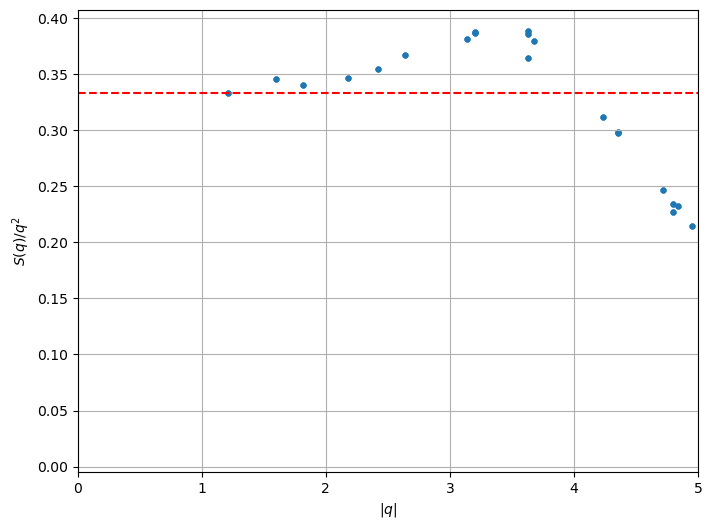

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Remove [0, 0] from kgrid and corresponding values from sq_list
kgrid_filtered = np.array([k for k in kgrid if not np.allclose(k, [0, 0])])
sq_list_filtered = [sq_list[i] for i, k in enumerate(kgrid) if not np.allclose(k, [0, 0])]

# Compute the norm of each k-point
k_norms = np.linalg.norm(kgrid_filtered, axis=1)

# Set S(k=0) = 0 explicitly
sq_list_filtered = np.array(sq_list_filtered)
sq_list_filtered[k_norms == 0] = 0

# Compute S(q)/q^2, avoiding division by zero
sq_over_q2 = np.zeros_like(sq_list_filtered)
nonzero_indices = k_norms > 0
sq_over_q2[nonzero_indices] = sq_list_filtered[nonzero_indices] / (k_norms[nonzero_indices] ** 2)

# Sort the norms and corresponding values for better visualization
sorted_indices = np.argsort(k_norms)
k_norms_sorted = k_norms[sorted_indices]
sq_over_q2_sorted = sq_over_q2[sorted_indices]*4*np.pi/(24*area_unitcell)

# Plot S(q)/q^2 as a function of q
plt.figure(figsize=(8, 6))
plt.scatter(k_norms_sorted, sq_over_q2_sorted, s=12)
plt.axhline(y=1/3, color='red', linestyle='--')  # Add horizontal line
plt.xlabel(r'$|q|$')
plt.ylabel(r'$S(q)/q^2$')
plt.xlim(0,5.0)
plt.grid(True)
plt.show()

In [105]:
sq_over_q2_sorted

Array([0.99893224-2.37457026e-10j, 0.99893224+2.37457026e-10j,
       1.0381109 -6.50603182e-10j, 1.0381109 +6.50603182e-10j,
       1.0199755 +6.85847545e-10j, 1.0199755 -6.85847545e-10j,
       1.0390813 -1.52005852e-09j, 1.0390813 +1.52005852e-09j,
       1.0629681 +4.97041963e-10j, 1.0629681 -4.97041963e-10j,
       1.1002913 +3.61368546e-10j, 1.1002913 -3.61368546e-10j,
       1.1433725 -6.14572560e-10j, 1.1433725 +6.14572560e-10j,
       1.161022  -1.11368592e-09j, 1.161022  +1.11368592e-09j,
       1.1628655 -1.00449649e-09j, 1.1628655 +1.00449649e-09j,
       1.0931417 +1.48930840e-10j, 1.1567978 -8.75397949e-11j,
       1.1660815 +4.57438497e-11j, 1.1660815 -4.57438497e-11j,
       1.0931417 -1.48930840e-10j, 1.1567978 +8.75397949e-11j,
       1.1383412 +1.26696612e-10j, 1.1383412 -1.26696612e-10j,
       0.9351387 +1.23727056e-10j, 0.9351387 -1.23727056e-10j,
       0.8951228 -3.57605751e-11j, 0.8951228 +3.57605751e-11j,
       0.8935425 +1.03845245e-10j, 0.8935425 -1.0384524

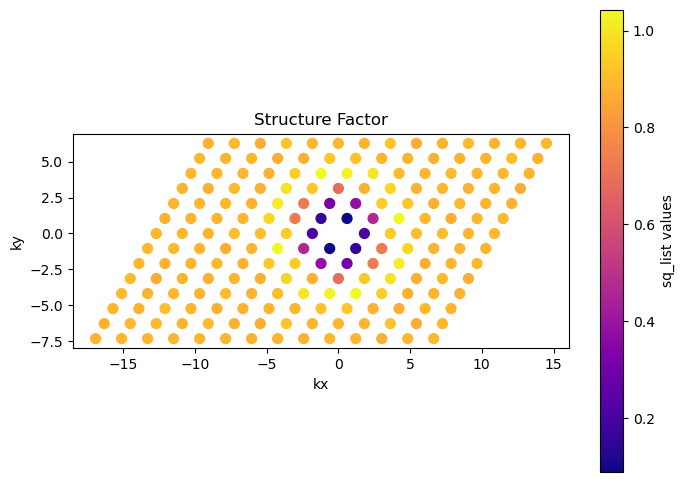

In [74]:
import matplotlib.pyplot as plt

# Remove [0, 0] from kgrid and corresponding values from sq_list
kgrid_filtered = np.array([k for k in kgrid if not np.allclose(k, [0, 0])])
sq_list_filtered = [sq_list[i]/9 for i, k in enumerate(kgrid) if not np.allclose(k, [0, 0])]

# Convert kgrid_filtered to 2D coordinates for plotting
kx = kgrid_filtered[:, 0]
ky = kgrid_filtered[:, 1]

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(kx, ky, c=sq_list_filtered, cmap='plasma', s=50)
plt.colorbar(label='sq_list values')
plt.xlabel('kx')
plt.ylabel('ky')
plt.gca().set_aspect('equal')
plt.title('Structure Factor')
plt.show()

In [75]:
g1 = rec[0,:]  # Example vector
g2 = rec[1,:]  # Example vector
# Define the range for m and n
m_range = np.arange(0, 1)  # Range for m (e.g., 0 to 4)
n_range = np.arange(0, 15)  # Range for n (e.g., 0 to 9)

# Create a grid of m and n values
m_grid, n_grid = np.meshgrid(m_range, n_range)

# Compute k = m * g1 + n * g2 for all combinations
kgrid = m_grid[..., None] * g1 + n_grid[..., None] * g2  # Shape: (len(n_range), len(m_range), 2)

# Flatten the grid to get a list of k points
kgrid = kgrid.reshape(-1, 2)  # Shape: (num_k_points, 2)

In [76]:
sq_list = []
for k in kgrid:
    result = structure_factor(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, k)
    print(k, result)
    sq_list = np.append(sq_list, result) 

[0. 0.] (64+0j)
[0.60459983 1.0471976 ] (0.8052724-1.9142199e-10j)
[1.2091997 2.0943952] (3.4275753+1.602728e-09j)
[1.8137995 3.1415927] (7.9309587+1.0805226e-09j)
[2.4183993 4.1887903] (8.992267-1.0398544e-09j)
[3.0229993 5.2359877] (7.997623-1.2379345e-09j)
[3.627599  6.2831855] (8.315335-1.8082691e-09j)
[4.2321987 7.3303833] (7.9678187-1.7816867e-09j)
[4.8367987 8.377581 ] (8.078011-3.8947814e-09j)
[5.4413986 9.424778 ] (7.9675713+5.018722e-09j)
[ 6.0459986 10.471975 ] (8.004888-3.6870618e-09j)
[ 6.650598 11.519174] (7.9790277+3.7189452e-09j)
[ 7.255198 12.566371] (8.054118+2.5313192e-09j)
[ 7.859798 13.613568] (8.039801+7.990423e-10j)
[ 8.464397 14.660767] (7.992101+1.7887046e-09j)


/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


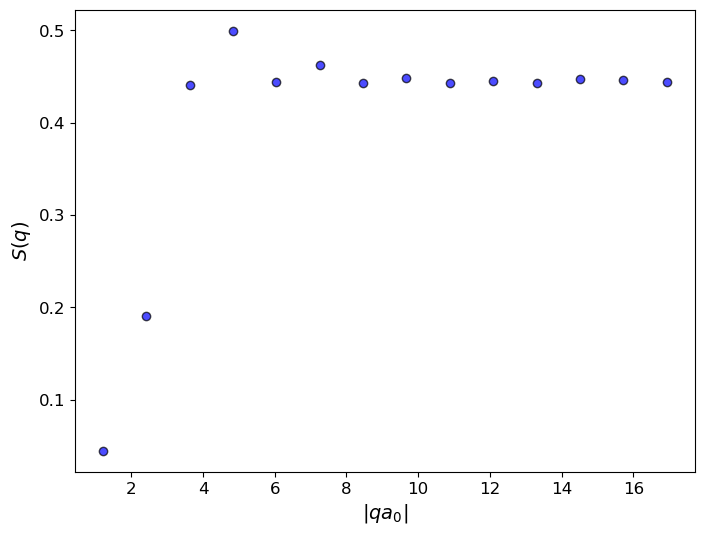

In [77]:
kgrid_magnitude = np.linalg.norm(kgrid, axis=1)
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(kgrid_magnitude[1:], sq_list[1:]/18, c='blue', alpha=0.7, edgecolors='k')

# Add labels with increased font size
plt.xlabel(r'$|q a_0|$', fontsize=14)
plt.ylabel(r'$S(q)$', fontsize=14)

# Increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().set_aspect(20)  # Example: Set aspect ratio to 1.5 (adjust as needed)
#plt.savefig("plots_paper/structurefactor_8particles_onethird.pdf", format="pdf", bbox_inches="tight")
#plt.ylim(0,1.1)
plt.show()

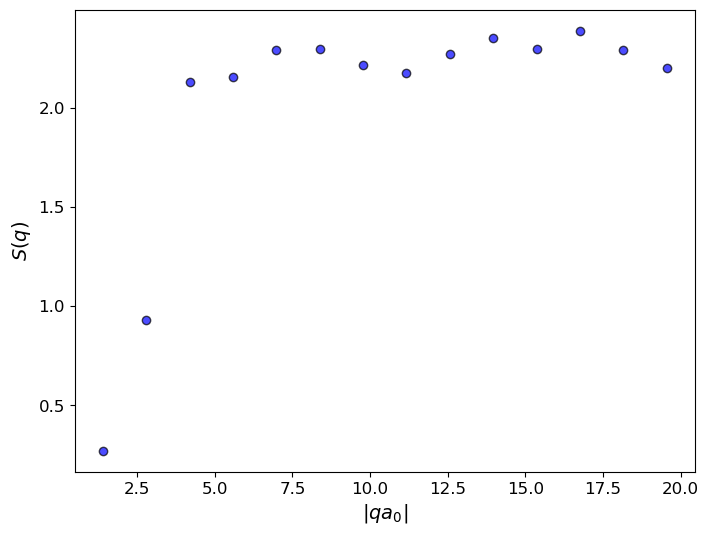

In [132]:
kgrid_magnitude = np.linalg.norm(kgrid, axis=1)
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(kgrid_magnitude[1:], sq_list[1:]/8, c='blue', alpha=0.7, edgecolors='k')

# Add labels with increased font size
plt.xlabel(r'$|q a_0|$', fontsize=14)
plt.ylabel(r'$S(q)$', fontsize=14)

# Increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().set_aspect(20)  # Example: Set aspect ratio to 1.5 (adjust as needed)
#plt.savefig("plots_paper/structurefactor_8particles_onethird.pdf", format="pdf", bbox_inches="tight")
#plt.ylim(0,1.1)
plt.show()

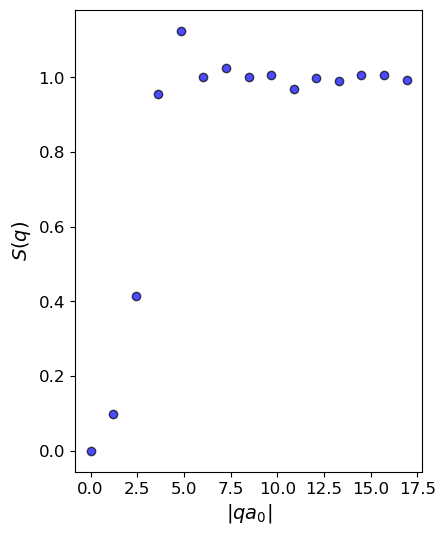

In [114]:
kgrid_magnitude = np.linalg.norm(kgrid, axis=1)
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(kgrid_magnitude, sq_list/8, c='blue', alpha=0.7, edgecolors='k')

# Add labels with increased font size
plt.xlabel(r'$|q a_0|$', fontsize=14)
plt.ylabel(r'$S(q)$', fontsize=14)

# Increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().set_aspect(20)  # Example: Set aspect ratio to 1.5 (adjust as needed)
plt.savefig("plots_paper/structurefactor_8particles_onethird.pdf", format="pdf", bbox_inches="tight")
#plt.ylim(0,1.1)
plt.show()

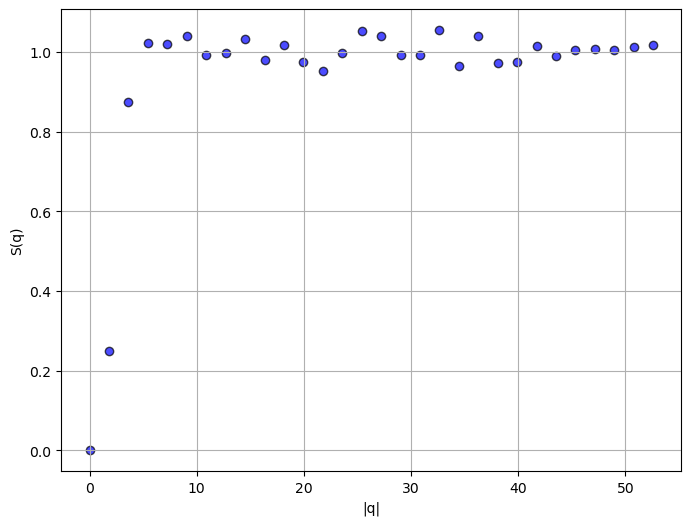

In [53]:
kgrid_magnitude = np.linalg.norm(kgrid, axis=1)
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(kgrid_magnitude, sq_list/8, c='blue', alpha=0.7, edgecolors='k')
plt.xlabel('|q|')
plt.ylabel('S(q)')
#plt.ylim(0,1.1)
plt.grid(True)
plt.show()

/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


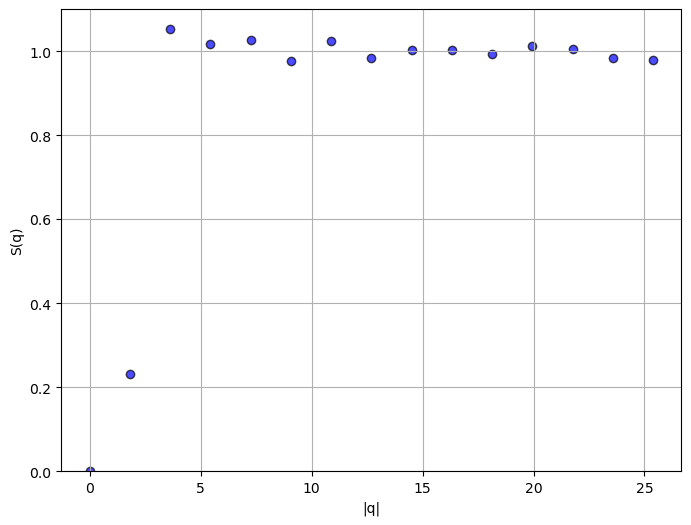

In [ ]:
kgrid_magnitude = np.linalg.norm(kgrid, axis=1)
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(kgrid_magnitude, sq_list/8, c='blue', alpha=0.7, edgecolors='k')
plt.xlabel('|q|')
plt.ylabel('S(q)')
plt.ylim(0,1.1)
plt.grid(True)
plt.show()

# Density


In [21]:
def density_fouriercomp(log_psi, params, samples, spins, atoms, charges, g):
    """
    Compute the Fourier component of the density rho_g at vector g.

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        g: (2,) array for momentum vector

    Returns:
        rho_g: Fourier component of the density at momentum g
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_charges):
        """
        Compute the contribution of a single sample to rho_g.
        """
        # Compute the dot product of each particle's position with g
        phases = jnp.exp(-1j * jnp.dot(sample_coords, g))  # (N,)
        # Multiply charges by phases and sum over all particles
        return phases  

    # Vectorize over all samples
    contribs = jax.vmap(sample_contrib)(coords, charges)
    return jnp.mean(contribs)  # Average over all samples

In [22]:
g1 = rec[0,:]  # Example vector
g2 = rec[1,:]  # Example vector
# Define the range for m and n
m_range = np.arange(-100, 101)  # Range for m (e.g., 0 to 4)
n_range = np.arange(-100, 101)  # Range for n (e.g., 0 to 9)

# Create a grid of m and n values
m_grid, n_grid = np.meshgrid(m_range, n_range)

# Compute k = m * g1 + n * g2 for all combinations
kgrid = m_grid[..., None] * g1 + n_grid[..., None] * g2  # Shape: (len(n_range), len(m_range), 2)

# Flatten the grid to get a list of k points
kgrid = kgrid.reshape(-1, 2)  # Shape: (num_k_points, 2)

In [23]:
m_range

array([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,
        -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,
        -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,
        -67,  -66,  -65,  -64,  -63,  -62,  -61,  -60,  -59,  -58,  -57,
        -56,  -55,  -54,  -53,  -52,  -51,  -50,  -49,  -48,  -47,  -46,
        -45,  -44,  -43,  -42,  -41,  -40,  -39,  -38,  -37,  -36,  -35,
        -34,  -33,  -32,  -31,  -30,  -29,  -28,  -27,  -26,  -25,  -24,
        -23,  -22,  -21,  -20,  -19,  -18,  -17,  -16,  -15,  -14,  -13,
        -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2,
         -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
         21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
         32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
         43,   44,   45,   46,   47,   48,   49,   

In [24]:
# Initialize an array to store rho_g for each g in kgrid
rho_g_values = []

# Loop over all g vectors in kgrid
for g in kgrid:
    # Compute rho_g for the current g
    rho_g = density_fouriercomp(log_network,gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, g)
    rho_g_values.append(rho_g)

# Convert the list to a numpy array for easier manipulation
rho_g_values = np.array(rho_g_values)

In [25]:
# Load rho_g_values and kgrid if not already in memory
# data = np.load('rho_g_data.npz')
# kgrid = data['kgrid']
# rho_g_values = data['rho_g_values']

# Define the real-space grid
x = np.linspace(-1, 6, 300)  # 200 points from -1 to 6
y = np.linspace(-6, 6, 300)  # 200 points from -6 to 6
X, Y = np.meshgrid(x, y)  # Create a 2D grid of (x, y) points
R = np.stack([X, Y], axis=-1)  # Shape: (200, 200, 2)

# Compute rho(r) for each point in the real-space grid
rho_r = np.zeros_like(X, dtype=np.complex128)  # Initialize rho(r) grid
for g, rho_g in zip(kgrid, rho_g_values):
    phase = np.exp(1j * (g[0] * X + g[1] * Y))  # e^(i g.r) for each r
    rho_r += rho_g * phase  # Sum over all g

# Take the real part of rho(r) for plotting
rho_r_real = (np.real(rho_r))/(27*area_unitcell)

In [452]:
rho_r_real = rho_r_real - np.min(rho_r_real)

np.complex128(-0.30896291771156825+0j)

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Sort rho_r_real and get the smallest number
smallest_number = np.min(rho_r_real)
print("Smallest number in rho_r_real:", smallest_number)

Smallest number in rho_r_real: 0.0


In [27]:
rho_r_real = rho_r_real - np.min(rho_r_real)

In [73]:
def plot_density_in_real_space_with_vectors(rho_r_real, X, Y, supercell_vectors, unit_cell_vectors):
    """
    Plots the density in real space along with the supercell and unit cell vectors.

    Parameters:
    - rho_r_real: 2D array of real-space density values.
    - X, Y: 2D arrays representing the grid of x and y coordinates.
    - supercell_vectors: 2x2 array where columns are the supercell basis vectors.
    - unit_cell_vectors: 2x2 array where columns are the unit cell basis vectors.
    """
    # Vectors/vertices for plotting
    v1 = supercell_vectors[:, 0]
    v2 = supercell_vectors[:, 1]
    supercell_vertices = np.array([[0, 0], v1, v1 + v2, v2, [0, 0]])

    u1 = unit_cell_vectors[:, 0]
    u2 = unit_cell_vectors[:, 1]
    unit_cell_vertices = np.array([[0, 0], u1, u1 + u2, u2, [0, 0]])

    # ---- PLOT ----
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot the density using scatter
    ax.tricontourf(X.flatten(), Y.flatten(), rho_r_real.flatten(), levels=500, cmap='Blues',alpha = 1.0)
    # Plot the supercell and unit cell vectors
    shifted_supercell_vertices = supercell_vertices #+ unit_cell_vectors[:, 0]
    shifted_unitcell_vertices = unit_cell_vertices #+ unit_cell_vectors[:, 0]
    ax.plot(shifted_supercell_vertices[:, 0], shifted_supercell_vertices[:, 1], color='black')
    ax.plot(shifted_unitcell_vertices[:, 0], shifted_unitcell_vertices[:, 1], linestyle='--', color='blue')

    # Set aspect ratio and labels
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(r'$x/a_0$', fontsize=14)
    ax.set_ylabel(r'$y/a_0$', fontsize=14)
    ax.set_ylim(-5, 6)
    ax.set_xlim(-1,6)
    ax.set_aspect('equal', adjustable='box')
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    #ax.legend(loc='upper right')
    cbar = plt.colorbar(ax.collections[0], ax=ax)  # Add colorbar for density
    #cbar.mappable.set_clim(0, 1)  # Set colorbar limits from 0 to 1    
    cbar.ax.set_title(r'$\rho(\mathbf{r}) ({\rm a.u.})$', fontsize=14)  # Set title for the colorbar
    cbar.ax.tick_params(labelsize=12)
    #cbar.set_ticks(np.arange(0, 1.1, 0.2))  # Ticks from 0 to 1 in increments of 0.2
    plt.savefig("/work/submit/ahmed95/plots_paper/density_8particles_onethird_CDW.png", dpi=2000, bbox_inches='tight')

    #plt.title('Density in Real Space with Supercell and Unit Cell Vectors')
    plt.show()

In [74]:
a1 = jnp.array([jnp.sqrt(3)/2,-0.5])
a2 =   jnp.array([0,1])
Tmatrix = jnp.array([[3,-3], [3, 6]])  # Identity matrix for unit cell
latticevecs = lattice_vecs(a1, a2, Tmatrix)
unitcellvecs = lattice_vecs(a1, a2, jnp.array([[1,0], [0, 1]]))  

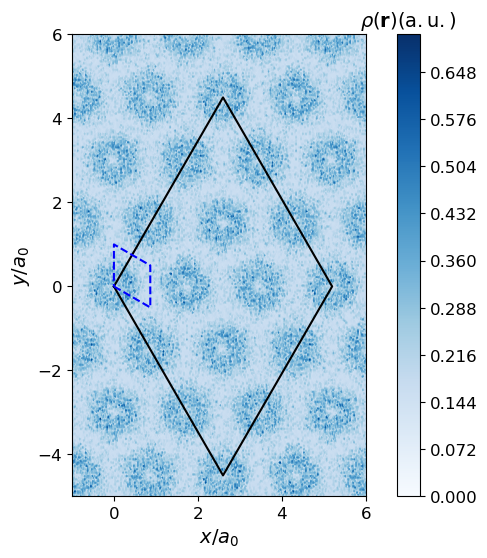

In [75]:
plot_density_in_real_space_with_vectors(rho_r_real, X, Y, latticevecs, unitcellvecs)

# Generating band wavefunctions

In [ ]:
import scipy.sparse as sp  # For sparse matrices (equivalent to SparseArrays)
from scipy.sparse.linalg import eigs  # For eigenvalue computations (equivalent to Arpack)

def Rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], 
                     [np.sin(theta), np.cos(theta)]])


# Parameters
M = 6  # cutoff
Mlist = [np.array([i, j]) - np.array([M + 1, M + 1]) for i in range(1, 2 * M + 2) for j in range(1, 2 * M + 2)]

# Uncomment and adjust if needed
# θdeg = 4.0  # degrees
# θ = θdeg * (np.pi / 180)
# a0 = 3.52  # Å
# a0 = a0 * 10**(-1)  # nm
# aM = a0 / (2 * np.sin(θ) / 2)
aM = 1.0  # nm

prefactor = 495  # meV·Å²
meff = 1.0  # effective mass
dMBZ = (4 * np.pi / (3 * aM))

# Constants
hbar = 4.135667 * 10**3 * 10**(-15) / (2 * np.pi)  # meV·s
me = 0.51099895 * 10**3 * 10**6  # meV/c²
m_eff = meff * me
kin = hbar**2 / (2 * m_eff) * 9 * 10**16
kin = kin / (1 * 10**-18)  # meV·nm²

esquare = (1.602176634 * 10**(-19))**2
epsilon_0 = 8.8541878128 * 10**(-12)

# Reciprocal lattice vectors
b1 = (4 * np.pi / (np.sqrt(3) * aM)) * np.array([1, 0])
b2 = Rot(np.pi / 3) @ b1
b3 = Rot(2 * np.pi / 3) @ b1
b4 = Rot(3 * np.pi / 3) @ b1
b5 = Rot(4 * np.pi / 3) @ b1
b6 = Rot(5 * np.pi / 3) @ b1

G1 = b1
G2 = b2
blist = [b1, b2, b3, b4, b5, b6]

# Pauli matrices
sigmax = np.array([[0, 1], [1, 0]])
sigmay = np.array([[0, -1j], [1j, 0]])
sigmaz = np.array([[1, 0], [0, -1]])

# Uncomment and adjust if needed
# G11 = dMBZ * np.array([1, 0])
# G22 = dMBZ * np.array([0.5, np.sqrt(3) / 2])
# G33 = dMBZ * np.array([-0.5, np.sqrt(3) / 2])
# G44 = dMBZ * np.array([-1, 0])
# G55 = dMBZ * np.array([-0.5, -np.sqrt(3) / 2])
# G66 = dMBZ * np.array([0.5, -np.sqrt(3) / 2])

# Real-space lattice vectors
a1 = aM * np.array([np.sqrt(3) / 2, -1 / 2])
a2 = aM * np.array([0, 1])

# Other parameters
V0 = 0.0
phi = 0.0
phi2 = 0.0
lambda_0 = -0.23  # dimensionless parameter

# Alist and phi2list
Alist = [[1j * b[1], -1j * b[0]] for b in blist]
phi2list = [phi2, -phi2, phi2, -phi2, phi2, -phi2]


import numpy as np

# Function to compute A_vec
def A_vec(r):
    Ax = 0.0
    Ay = 0.0
    for i in range(len(Alist)):
        Ax += Alist[i][0] * np.exp(1j * (np.dot(blist[i], r) + phi2list[i]))
        Ay += Alist[i][1] * np.exp(1j * (np.dot(blist[i], r) + phi2list[i]))
    return np.array([Ax, Ay])

# Function to compute Fourier component
def fourier_comp(q, r):
    return np.exp(-1j * np.dot(q, r)) * np.dot(A_vec(r), A_vec(r))

# Initialize parameters
#momentumfouriergrid = np.empty((2 * M + 1)**2, dtype=np.complex128)
numx = 150
numy = 150
A_UC = abs(a1[0] * a2[1] - a2[0] * a1[1])
dA = A_UC / (numx**2)
rlist = [i * (a1 / numx) + j * (a2 / numy) for i in range(0, numx + 1) for j in range(1, numy + 1)]

"""# Compute momentum Fourier grid
for m in range(-M, M + 1):
    for n in range(-M, M + 1):
        p = (n + M) + (m + M) * (2 * M + 1)
        qvector = m * b1 + n * b2
        val = 0.0 + 0.0j
        for r in rlist:
            val += fourier_comp(qvector, r)
        momentumfouriergrid[p] = val * (dA) / A_UC"""
#np.save("momentumfouriergrid.npy", momentumfouriergrid)


'# Compute momentum Fourier grid\nfor m in range(-M, M + 1):\n    for n in range(-M, M + 1):\n        p = (n + M) + (m + M) * (2 * M + 1)\n        qvector = m * b1 + n * b2\n        val = 0.0 + 0.0j\n        for r in rlist:\n            val += fourier_comp(qvector, r)\n        momentumfouriergrid[p] = val * (dA) / A_UC'

In [ ]:
momentumfouriergrid = np.load("momentumfouriergrid.npy")

In [ ]:
def Ham(k, M, b1, b2, V0, phi, kin, λ_0, Alist, phi2list, momentumfouriergrid):
    size = (2 * M + 1) ** 2
    H = np.zeros((size, size), dtype=np.complex128)

    for m in range(-M, M + 1):
        for n in range(-M, M + 1):
            p = (n + M) + (m + M) * (2 * M + 1)
            kt = k + m * b1 + n * b2
            H[p, p] += kin * np.linalg.norm(kt) ** 2

            if m != M:
                x = (n + M) + (m + 1 + M) * (2 * M + 1)
                H[x, p] += V0 * np.exp(1j * phi) + (2 * kin * λ_0) * np.dot(kt + b1, Alist[0]) * np.exp(1j * phi2list[0])

            if n != -M:
                x = (n - 1 + M) + (m + M) * (2 * M + 1)
                H[x, p] += V0 * np.exp(1j * phi) + (2 * kin * λ_0) * np.dot(kt - b2, Alist[4]) * np.exp(1j * phi2list[4])

            if n != M and m != -M:
                x = (n + 1 + M) + (m - 1 + M) * (2 * M + 1)
                H[x, p] += V0 * np.exp(1j * phi) + (2 * kin * λ_0) * np.dot(kt - b1 + b2, Alist[2]) * np.exp(1j * phi2list[2])

            if m != -M:
                x = (n + M) + (m - 1 + M) * (2 * M + 1)
                H[x, p] += V0 * np.exp(-1j * phi) + (2 * kin * λ_0) * np.dot(kt - b1, Alist[3]) * np.exp(1j * phi2list[3])

            if n != M:
                x = (n + 1 + M) + (m + M) * (2 * M + 1)
                H[x, p] += V0 * np.exp(-1j * phi) + (2 * kin * λ_0) * np.dot(kt + b2, Alist[1]) * np.exp(1j * phi2list[1])

            if n != -M and m != M:
                x = (n - 1 + M) + (m + 1 + M) * (2 * M + 1)
                H[x, p] += V0 * np.exp(-1j * phi) + (2 * kin * λ_0) * np.dot(kt + b1 - b2, Alist[5]) * np.exp(1j * phi2list[5])

            # Additional Fourier grid contributions
            for m1 in range(-M, M + 1):
                for n1 in range(-M, M + 1):
                    x = (n - n1 + M) + (m - m1 + M) * (2 * M + 1)
                    y = (n1 + M) + (m1 + M) * (2 * M + 1)
                    if 0 <= x < size:
                        H[x, p] += kin * (λ_0 ** 2) * momentumfouriergrid[y]

    return (H + H.T.conj()) / 2  # Ensure Hermitian matrix

def band_wavefunction(r, wavefunc, k, M, G1, G2):
    # Create the grid of m and n values
    m = jnp.arange(-M, M + 1)
    n = jnp.arange(-M, M + 1)
    m_grid, n_grid = jnp.meshgrid(m, n, indexing='ij')

    # Compute the linear index p
    p = (n_grid + M) + (m_grid + M) * (2 * M + 1)

    # Compute the reciprocal lattice vectors G
    G = m_grid[..., None] * G1 + n_grid[..., None] * G2

    # Compute the wavefunction contributions
    real_wavefunc = jnp.sum(
        wavefunc[p] * jnp.exp(1j * jnp.dot(G + k, r)),
        axis=(0, 1)
    )

    return real_wavefunc


def build_band_pdf_and_sampler(band_wavefunction, wavefunc, kvec, Mcutoff, G1, G2, lattice, grid_size=64):
    """
    Build normalized PDF of |band_wavefunction|^2 over a grid defined 
    by a supercell with arbitrary lattice vectors (columns of `lattice`).
    
    Args:
        band_wavefunction: function r -> complex wavefunction value
        wavefunc, kvec, Mcutoff, G1, G2: wavefunction parameters
        lattice: (2, 2) array, columns are lattice vectors
        grid_size: number of points along each lattice direction
    
    Returns:
        sampler(key, n_samples) -> (samples, pdf_vals)
    """
    # Grid in fractional coordinates
    us = jnp.linspace(0, 1, grid_size)
    vs = jnp.linspace(0, 1, grid_size)
    frac_grid = jnp.stack(jnp.meshgrid(us, vs, indexing='ij'), axis=-1).reshape(-1, 2)  # (N,2)

    # Map to real space using lattice matrix
    grid = frac_grid @ lattice.T  # shape (N,2)

    # Evaluate |psi|^2
    vals = jax.vmap(lambda r: jnp.abs(band_wavefunction(r, wavefunc, kvec, Mcutoff, G1, G2))**2)(grid)
    pdf = vals / jnp.abs(jnp.linalg.det(lattice))  # Normalize

    # Flatten PDF and compute CDF
    cdf = jnp.cumsum(pdf)
    cdf /= cdf[-1]

    def sampler(key, n_samples):
        # Sample uniformly in [0,1], invert CDF
        u = jax.random.uniform(key, (n_samples,))
        idx = jnp.searchsorted(cdf, u)
        chosen = grid[idx]
        return chosen, pdf[idx]

    return sampler

def compute_band_norm(band_wavefunction, wavefunc, kvec, Mcutoff, G1, G2, lattice, grid_size=64):
    """
    Compute numerical normalization of a Bloch wavefunction at momentum kvec
    by integrating |psi_k(r)|^2 over the unit cell.

    Args:
        band_wavefunction: function r -> complex wavefunction value
        wavefunc, kvec, Mcutoff, G1, G2: wavefunction parameters
        lattice: (2, 2) array, columns are lattice vectors
        grid_size: number of points along each lattice direction

    Returns:
        normalization (float): Integral of |psi_k(r)|^2 over the unit cell
    """
    # Build grid in fractional coordinates
    us = jnp.linspace(0, 1, grid_size)
    vs = jnp.linspace(0, 1, grid_size)
    frac_grid = jnp.stack(jnp.meshgrid(us, vs, indexing='ij'), axis=-1).reshape(-1, 2)

    # Real-space coordinates
    grid = frac_grid @ lattice.T  # (N, 2)
    area = jnp.abs(jnp.linalg.det(lattice))  # unit cell area

    # Evaluate |psi|^2
    vals = jax.vmap(lambda r: jnp.abs(
        band_wavefunction(r, wavefunc, kvec, Mcutoff, G1, G2)
    )**2)(grid)

    # Numerical integration: average over grid * unit cell area
    norm = jnp.mean(vals) * area
    return norm




# One RDM (with projection)

In [ ]:
def band_momentum_occupation(log_psi, params, samples, spins, atoms, charges, k, band_wavefunction,wavefunc, Mcuttoff, G1, G2, grid):
    """
    Estimate n(k) by integrating over r1.

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        k: (2,) array for momentum vector
        grid: (G, 2) array of spatial grid points to integrate over r1
        h: bin width for Gaussian smoothing

    Returns:
        n_k: Momentum occupation at momentum k
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        contrib = 0.0 + 0.0j
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        
        def particle_update(r2ind, r2, acc):
            # Compute the contribution for a fixed r2
            def integrand(r1):
                new_coords = sample_coords.at[r2ind].set(r1)  # Replace r2 with r1
                psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                return jnp.exp(psi_mod - psi_ref) * jnp.conj(band_wavefunction(r1, wavefunc, k, Mcuttoff, G1, G2)) * band_wavefunction(r2, wavefunc, k, Mcuttoff, G1, G2)

            # Integrate over r1 using the grid
            integrand_values = jax.vmap(integrand)(grid)  # (G,)
            integral = jnp.sum(integrand_values) * area_lattice/grid.shape[0] # Approximate integral
            return acc + integral

        # Loop over all particles in the sample
        contrib = jax.lax.fori_loop(0, N, lambda i, acc: particle_update(i,sample_coords[i], acc), contrib)
        return contrib

    # Compute contributions for all samples
    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)

def oneRDM_planewavebasis(log_psi, params, samples, spins, atoms, charges, k1,k2, band_wavefunction,wavefunc, Mcuttoff, G1, G2, grid):
    """
    Estimate 1RDM in plane wave basis

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        k: (2,) array for momentum vector
        grid: (G, 2) array of spatial grid points to integrate over r1
        h: bin width for Gaussian smoothing

    Returns:
        n_k: Momentum occupation at momentum k
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        contrib = 0.0 + 0.0j
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        
        def particle_update(r2ind, r2, acc):
            # Compute the contribution for a fixed r2
            basis2 = jnp.exp(1j * jnp.dot(k2, r2))
            def integrand(r1):
                basis2 = jnp.exp(1j *jnp.dot(k1, r1))
                new_coords = sample_coords.at[r2ind].set(r1)  # Replace r2 with r1
                psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                return jnp.exp(psi_mod - psi_ref) * basis1 * basis2

            # Integrate over r1 using the grid
            integrand_values = jax.vmap(integrand)(grid)  # (G,)
            integral = jnp.sum(integrand_values) * area_lattice/grid.shape[0] # Approximate integral
            return acc + integral

        # Loop over all particles in the sample
        contrib = jax.lax.fori_loop(0, N, lambda i, acc: particle_update(i,sample_coords[i], acc), contrib)
        return contrib

    # Compute contributions for all samples
    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)

def oneRDM_bandbasis(log_psi, params, samples, spins, atoms, charges, k1,k2, band_wavefunction, wavefunc1,wavefunc2, Mcuttoff, G1, G2, grid):
    """
    Estimate 1RDM in plane wave basis

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        k: (2,) array for momentum vector
        grid: (G, 2) array of spatial grid points to integrate over r1
        h: bin width for Gaussian smoothing

    Returns:
        n_k: Momentum occupation at momentum k
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        contrib = 0.0 + 0.0j
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        
        def particle_update(r2ind, r2, acc):
            # Compute the contribution for a fixed r2
            basis2 = band_wavefunction(r2, wavefunc2, k2, Mcuttoff, G1, G2)
            def integrand(r1):
                basis1 = band_wavefunction(r1, wavefunc1, k1, Mcuttoff, G1, G2)
                new_coords = sample_coords.at[r2ind].set(r1)  # Replace r2 with r1
                psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                return jnp.exp(psi_mod - psi_ref) * jnp.conj(basis1) * basis2

            # Integrate over r1 using the grid
            integrand_values = jax.vmap(integrand)(grid)  # (G,)
            integral = jnp.sum(integrand_values) * area_lattice/grid.shape[0] # Approximate integral
            return acc + integral

        # Loop over all particles in the sample
        contrib = jax.lax.fori_loop(0, N, lambda i, acc: particle_update(i,sample_coords[i], acc), contrib)
        return contrib

    # Compute contributions for all samples
    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)


def oneRDM_bandbasis_MC(
    log_psi, params, samples, spins, atoms, charges,
    k1, k2, band_wavefunction,
    wavefunc1, wavefunc2, Mcutoff, G1, G2,
    sampler_r1,  # a sampler built like build_band_pdf_and_sampler
    n_mc=1024
):
    """
    Monte Carlo estimate of 1RDM element in band basis:
        ρ_{k1,k2} = <c†_{k1} c_{k2}>

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> log(psi)
        params: neural network parameters
        samples: (M, N*2) array of electron coordinates
        spins, atoms, charges: per-sample info
        k1, k2: momentum vectors
        band_wavefunction: callable(r, wavefunc, k, Mcutoff, G1, G2)
        wavefunc1, wavefunc2: band wavefunction descriptors for k1, k2
        Mcutoff, G1, G2: plane-wave cutoff and reciprocal vectors
        sampler_r1: function(key, n_samples) -> (r_samples, pdf_vals) sampling r1 ~ |φ_k1(r)|²
        n_mc: number of Monte Carlo samples for r1 per particle

    Returns:
        Complex scalar: estimated ρ_{k1,k2}
    """
    import jax
    import jax.numpy as jnp

    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges, key):
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)

        def particle_update(r2ind, r2, acc):
            # Compute φ_k2(r2)
            basis2 = band_wavefunction(r2, wavefunc2, k2, Mcutoff, G1, G2)

            def mc_integrand(r1):
                basis1 = band_wavefunction(r1, wavefunc1, k1, Mcutoff, G1, G2)
                new_coords = sample_coords.at[r2ind].set(r1)
                psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                # No explicit PDF weight needed since r1 ~ |φ_k1|^2
                return jnp.exp(psi_mod - psi_ref) * (1/basis1) * basis2

            # Draw Monte Carlo samples for r1
            subkey = jax.random.fold_in(key, r2ind)
            r1_samples, _ = sampler_r1(subkey, n_mc)

            # Evaluate integrand over samples
            integrand_vals = jax.vmap(mc_integrand)(r1_samples)
            return acc + jnp.mean(integrand_vals)

        # Loop over all particles
        return jax.lax.fori_loop(0, N, lambda i, acc: particle_update(i, sample_coords[i], acc), 0.0 + 0.0j)

    # Vectorize over M walker samples
    keys = jax.random.split(jax.random.PRNGKey(0), M)
    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges, keys)
    std_contribs = jnp.std(contribs)
    print(std_contribs)
    return jnp.mean(contribs)


def band_momentum_occupation_v2( log_psi, params, samples, spins, atoms, charges, k, band_wavefunction, wavefunc, M, G1, G2, grid, area_lattice):
    """
    Memory-optimized n(k) estimation with grid integration.
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)
    G = grid.shape[0]

    # Precompute band wavefunction on the grid
   # band_vals_grid = band_wavefunction(grid, wavefunc, k, M, G1, G2)  # (G,)
    
    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)

        def particle_contrib(r2ind, r2):
            # Band wavefunction at r2
            #band_r2 = band_wavefunction(r2, wavefunc, k, M, G1, G2)

            def grid_loop(carry, idx):
                r1 = grid[idx]
                #band_r1 = band_vals_grid[idx]

                # Replace r2 with r1
                new_coords = jax.lax.dynamic_update_slice(
                    sample_coords, r1[None, :], (r2ind, 0)
                )
                psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                ratio = jnp.exp(psi_mod - psi_ref) 

                val = ratio #* jnp.conj(band_r1) * band_r2
                return carry + val, None

            # Loop over grid to avoid huge allocation
            total, _ = jax.lax.scan(grid_loop, jnp.array(0.0+0.0j), jnp.arange(G))
            return total * (area_lattice / G)

        # Loop over particles
        contribs, _ = jax.lax.scan(
            lambda acc, i: (acc + particle_contrib(i, sample_coords[i]), None),
            jnp.array(0.0+0.0j),
            jnp.arange(N)
        )
        return contribs

    # Vectorize over samples
    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)

    return jnp.mean(contribs)




In [ ]:
kpt1 = rec[0,:] 
H = Ham(kpt1, M, b1, b2, V0, phi, kin, lambda_0, Alist, phi2list, momentumfouriergrid)
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H)
# Example: Get the eigenfunctions corresponding to the smallest b eigenvalues
sorted_indices = np.argsort(eigenvalues)  # Indices to sort eigenvalues
smallest_n_indices = sorted_indices[:1]  # Indices of the smallest n eigenvalues
kpt_wavefunc1 = eigenvectors[:, smallest_n_indices]  # Corresponding eigenvectors
kpt_wavefunc1 = kpt_wavefunc1[:,0]
kpt_wavefunc1 = jnp.array(kpt_wavefunc1)

kpt2 = jnp.array([0,0])
H = Ham(kpt2, M, b1, b2, V0, phi, kin, lambda_0, Alist, phi2list, momentumfouriergrid)
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H)
# Example: Get the eigenfunctions corresponding to the smallest b eigenvalues
sorted_indices = np.argsort(eigenvalues)  # Indices to sort eigenvalues
smallest_n_indices = sorted_indices[:1]  # Indices of the smallest n eigenvalues
kpt_wavefunc2 = eigenvectors[:, smallest_n_indices]  # Corresponding eigenvectors
kpt_wavefunc2 = kpt_wavefunc2[:,0]
kpt_wavefunc2 = jnp.array(kpt_wavefunc2)

In [ ]:
kpt_wavefunc1

Array([-1.73548855e-08+0.00000000e+00j, -5.23307231e-10+3.35788708e-09j,
        2.29306657e-10-5.28973587e-10j,  3.24076721e-09-7.46231521e-09j,
       -5.86228772e-08-1.60020022e-07j,  1.04991258e-07-3.22575886e-07j,
       -4.20680124e-07-7.00155306e-06j,  3.63285835e-06-3.44332584e-05j,
        2.71532031e-06-5.52607416e-05j, -2.92338427e-05-3.73982839e-05j,
       -2.58549790e-05-1.01024616e-05j, -6.48453261e-06-1.04390654e-06j,
       -3.84146659e-07+1.20976210e-07j, -4.22605453e-08-1.35711420e-09j,
       -1.07242271e-09+6.02700778e-09j,  6.26220542e-09-1.21640200e-08j,
       -4.33202629e-08-2.29962083e-07j,  9.95591108e-07-1.48345759e-06j,
       -7.54311304e-06-3.38951613e-05j, -2.07541416e-06-3.72578070e-05j,
       -1.39529322e-04-6.66836204e-05j, -3.65492364e-04-4.37325216e-04j,
       -2.30644320e-04-1.91775252e-04j, -6.64175313e-05-1.14637223e-05j,
       -2.13822514e-05-1.35155915e-06j, -4.64587345e-07+6.22823109e-07j,
       -6.61359110e-08-9.85615256e-10j,  4.31754854

In [ ]:
numx = 25
numy = 25
dAgrid = area_lattice / (numx**2)
rlist2 = [i * (lattice[:,0] / numx) + j * (lattice[:,1] / numy) for i in range(0, numx) for j in range(0, numy)]
rlist2 = jnp.array(rlist2)

In [ ]:
oneRDM_bandbasis(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kpt1,kpt2, band_wavefunction, kpt_wavefunc1,kpt_wavefunc2, M, G1, G2, rlist2)

Array(-0.1663454+0.05340395j, dtype=complex64)

In [ ]:
oneRDM_bandbasis(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kpt2,kpt1, band_wavefunction, kpt_wavefunc2,kpt_wavefunc1, M, G1, G2, rlist2)

Array(0.01060622+0.00463109j, dtype=complex64)

In [ ]:
(0.01060622+0.00463109j)/area_lattice

Array(0.00136078+0.00059417j, dtype=complex64)

In [ ]:
area_lattice

Array(7.7942286, dtype=float32)

In [ ]:
g1 = rec[0,:]  # Example vector
g2 = rec[1,:]  # Example vector
# Define the range for m and n
m_range = np.arange(0, 3)  # Range for m (e.g., 0 to 4)
n_range = np.arange(0, 3)  # Range for n (e.g., 0 to 9)

# Create a grid of m and n values
m_grid, n_grid = np.meshgrid(m_range, n_range)

# Compute k = m * g1 + n * g2 for all combinations
kgrid = m_grid[..., None] * g1 + n_grid[..., None] * g2  # Shape: (len(n_range), len(m_range), 2)

# Flatten the grid to get a list of k points
kgrid = kgrid.reshape(-1, 2)  # Shape: (num_k_points, 2)

In [ ]:
# Initialize an empty list to store kpt_wavefunc for each k
kpt_wavefuncs = []

for k in kgrid:
    H = Ham(k, M, b1, b2, V0, phi, kin, lambda_0, Alist, phi2list, momentumfouriergrid) / (2 * kin)
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    # Get the eigenfunctions corresponding to the smallest eigenvalue
    sorted_indices = np.argsort(eigenvalues)  # Indices to sort eigenvalues
    smallest_n_indices = sorted_indices[:1]  # Indices of the smallest n eigenvalues
    kpt_wavefunc = eigenvectors[:, smallest_n_indices]  # Corresponding eigenvectors
    kpt_wavefunc = kpt_wavefunc[:, 0]  # Extract the first eigenvector
    kpt_wavefunc = jnp.array(kpt_wavefunc)  # Convert to JAX array
    kpt_wavefuncs.append(kpt_wavefunc)  # Append to the list

# Convert the list to a JAX array of shape (len(kgrid), ...)
kpt_wavefuncs = jnp.array(kpt_wavefuncs)

In [ ]:
sampler = build_band_pdf_and_sampler( band_wavefunction, kpt_wavefuncs[0], kgrid[0], M, G1, G2, lattice, 1600)
oneRDM_bandbasis_MC(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges,kgrid[0], kgrid[1], band_wavefunction,kpt_wavefuncs[0], kpt_wavefuncs[1], M, G1, G2,sampler, 400)

0.13212784


Array(0.00424745-0.00122257j, dtype=complex64)

In [ ]:
sampler = build_band_pdf_and_sampler( band_wavefunction, kpt_wavefuncs[0], kgrid[0], M, G1, G2, lattice, 1600)
oneRDM_bandbasis_MC(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges,kgrid[1], kgrid[0], band_wavefunction,kpt_wavefuncs[1], kpt_wavefuncs[0], M, G1, G2,sampler, 400)

0.6436631


Array(-0.02852577+0.00644883j, dtype=complex64)

In [ ]:
sampler = build_band_pdf_and_sampler( band_wavefunction, kpt_wavefuncs[1], kgrid[1], M, G1, G2, lattice, 1600)
oneRDM_bandbasis_MC(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges,kgrid[1], kgrid[0], band_wavefunction,kpt_wavefuncs[1], kpt_wavefuncs[0], M, G1, G2,sampler, 400)

0.5821643


Array(-0.00470455+0.00294911j, dtype=complex64)

In [ ]:
compute_band_norm(band_wavefunction, kpt_wavefuncs[4], kgrid[4], M, G1, G2, lattice, grid_size=2000)

Array(7.7927957, dtype=float32)

In [ ]:
compute_band_norm(band_wavefunction, kpt_wavefuncs[8], kgrid[8], M, G1, G2, lattice, grid_size=2000)

Array(7.7927957, dtype=float32)

In [ ]:
jnp.sqrt(area_lattice)

Array(2.7918146, dtype=float32)

In [ ]:
momlist = []
for (idx,kpt) in enumerate(kgrid):
    occup = oneRDM_bandbasis(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kpt,kpt, band_wavefunction, kpt_wavefuncs[idx],kpt_wavefuncs[idx], M, G1, G2, rlist2)
    momlist.append(occup)
    print(kpt, occup/area_lattice)

[0. 0.] (0.0061007272-0.0012640681j)
[2.4183993 0.       ] (0.34771693-0.019417258j)
[4.8367987 0.       ] (0.35286796+0.021729218j)
[1.2091997 2.0943952] (0.38768-0.007568615j)
[3.627599  2.0943952] (0.44729304-0.0009503523j)
[6.0459986 2.0943952] (0.38543808+0.013204891j)
[2.4183993 4.1887903] (0.29942745+0.0016854361j)
[4.8367987 4.1887903] (0.28673926-0.0052848225j)
[7.255198  4.1887903] (0.4802325-0.0029102508j)


In [ ]:
key = jax.random.PRNGKey(0)
key_r1, key_r2 = jax.random.split(key)

# Build samplers for k1, k2 bands
sampler1 = build_band_pdf_and_sampler(
    band_wavefunction, kpt_wavefuncs[1], kgrid[1],
    M, G1, G2, lattice, 500
)
sampler2 = build_band_pdf_and_sampler(
    band_wavefunction, kpt_wavefuncs[1], kgrid[1],
    M, G1, G2, lattice, 500
)

# Sample r1, r2 and get their sampling probabilities
r1_points, p_r1 = sampler1(key_r1, 100)
r2_points, p_r2 = sampler2(key_r2, 100)

In [ ]:
momlist = []
for (idx,kpt) in enumerate(kgrid):
    sampler = build_band_pdf_and_sampler( band_wavefunction, kpt_wavefuncs[idx], kgrid[idx], M, G1, G2, lattice, 500)
    occup = oneRDM_bandbasis_MC(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges,kgrid[idx], kgrid[idx], band_wavefunction,kpt_wavefuncs[idx], kpt_wavefuncs[idx], M, G1, G2,sampler, 100)
    momlist.append(occup)
    print(kpt, occup)

[0. 0.] (0.28825316-0.0042474433j)
[1.8137994 0.       ] (0.30377895-0.0056527485j)
[3.6275988 0.       ] (0.32207438+0.02450898j)
[5.441398 0.      ] (0.29374543-0.002347256j)
[0.60459983 1.0471976 ] (0.27993298+0.0014970051j)
[2.4183993 1.0471976] 

In [ ]:
np.save("momlist.npy", np.array(momlist))

In [ ]:
momlist = np.load("momlist.npy")

In [ ]:
sum(momlist)

np.complex64(0.99323887-0.00033382955j)

In [ ]:
momlist

array([0.28825316-0.00424744j, 0.30377895-0.00565275j,
       0.32207438+0.02450898j, 0.29374543-0.00234726j,
       0.27993298+0.00149701j, 0.34286824+0.01631609j,
       0.36925513+0.01284876j, 0.30251044+0.00572121j,
       0.32128853-0.00267819j, 0.3815564 -0.02278285j,
       0.36445737+0.00438176j, 0.31649813-0.00289214j,
       0.3329283 -0.00336803j, 0.35873103-0.01376229j,
       0.3509928 +0.01092804j, 0.3444761 +0.00933343j,
       0.32851046+0.00664544j, 0.3192597 -0.00600239j,
       0.37132427+0.01539396j, 0.3803474 -0.01452488j,
       0.3036647 -0.0134595j , 0.30488598-0.01433089j,
       0.33381522+0.01363184j, 0.33075723-0.01782855j], dtype=complex64)

/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/axes/_axes.py:4733: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


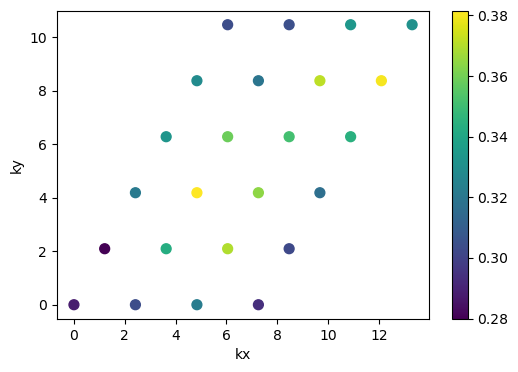

In [ ]:
import matplotlib.pyplot as plt

# Assuming `kgrid` is a list of 2D vectors and `momlist` is a list of scalar values
# Example:
# kgrid = [[1, 2], [3, 4], [5, 6], [7, 8]]
# momlist = [10, 20, 30, 40]

# Convert kgrid to two separate lists for x and y coordinates
kgrid_x = [vec[0] for vec in kgrid]
kgrid_y = [vec[1] for vec in kgrid]

# Create the scatter plot
plt.figure(figsize=(6, 4))
scatter = plt.scatter(kgrid_x, kgrid_y, c=momlist, cmap='viridis', s=50)
plt.colorbar(scatter)  # Add a colorbar to show the mapping
plt.xlabel("kx")
plt.ylabel("ky")
plt.show()

# 2RDM (with projection)

In [ ]:
def twoRDM_bandbasis(log_psi, params, samples, spins, atoms, charges, 
                         k_list, band_wavefunctions, wavefuncs, Mcutoff, G1, G2, grid, eps=1e-12):
    """
    2RDM in band basis with symmetry: sum over i<j and include swapped contribution
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        contrib = 0.0 + 0.0j

        # sum over particle pairs i<j
        def pair_update(i, acc_i):
            def inner_loop(j, acc_j):
                r1s = jnp.repeat(grid, grid.shape[0], axis=0)
                r2s = jnp.tile(grid, (grid.shape[0],1))
                dist = jnp.linalg.norm(r1s - r2s, axis=1)
                weight = (dist > eps).astype(r1s.dtype)
                r_pairs = jnp.stack([r1s, r2s], axis=1)

                def integrand(r_pair, w):
                    return jax.lax.cond(
                        w>0,
                        lambda _: compute_pair_sym(r_pair, psi_ref, sample_coords, sample_spin, sample_atoms, sample_charges, i, j),
                        lambda _: 0.0 + 0.0j,
                        operand=None
                    )

                vals = jax.vmap(integrand)(r_pairs, weight)
                integral = jnp.sum(vals) * (area_lattice / grid.shape[0])**2
                return acc_j + integral

            return jax.lax.fori_loop(i+1, N, inner_loop, acc_i)

        contrib = jax.lax.fori_loop(0, N-1, pair_update, contrib)
        return contrib

    def compute_pair_sym(r_pair, psi_ref, sample_coords, sample_spin, sample_atoms, sample_charges, i, j):
        r1, r2 = r_pair
        new_coords = sample_coords.at[i].set(r1)
        new_coords = new_coords.at[j].set(r2)
        psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)

        # original ordering
        b1 = band_wavefunction(r1, wavefuncs[0], k_list[0], Mcutoff, G1, G2)
        b2 = band_wavefunction(r2, wavefuncs[1], k_list[1], Mcutoff, G1, G2)
        b3 = band_wavefunction(sample_coords[i], wavefuncs[2], k_list[2], Mcutoff, G1, G2)
        b4 = band_wavefunction(sample_coords[j], wavefuncs[3], k_list[3], Mcutoff, G1, G2)
        b3s = band_wavefunction(sample_coords[j], wavefuncs[2], k_list[2], Mcutoff, G1, G2)
        b4s = band_wavefunction(sample_coords[i], wavefuncs[3], k_list[3], Mcutoff, G1, G2)
        val = jnp.exp(psi_mod - psi_ref) * (jnp.conj(b1) * jnp.conj(b2) * b3 * b4 - jnp.conj(b1) * jnp.conj(b2) * b3s * b4s)

        return val

    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)


import jax
import jax.numpy as jnp

def twoRDM_bandbasis_jit(log_psi, params, samples, spins, atoms, charges, kinds,
                         k_list,  band_wavefunction, wavefuncs, Mcutoff, G1, G2, grid, area_lattice, eps=1e-12):
    """
    Fully JIT-compatible, memory-efficient 2RDM in the band basis.
    Precompute band wavefunctions on the grid for efficiency.
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)

    # Precompute band wavefunctions on the grid
    grid_size = grid.shape[0]
    precomputed_bands = []
    for idx in kinds[:2]:  # for r1 and r2
        bvals = jax.vmap(lambda r: band_wavefunction(r, wavefuncs[idx], k_list[idx], Mcutoff, G1, G2))(grid)
        precomputed_bands.append(bvals)  # shape: (grid_size, )

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
        contrib = 0.0 + 0.0j

        # sum over particle pairs i<j
        def pair_update(i, acc_i):
            def inner_loop(j, acc_j):
                integral = 0.0 + 0.0j

                # nested loops over r1 and r2 indices
                def r1_loop(r1_idx, acc_r1):
                    r1 = grid[r1_idx]
                    b1_val = precomputed_bands[0][r1_idx]

                    def r2_loop(r2_idx, acc_r2):
                        r2 = grid[r2_idx]
                        b2_val = precomputed_bands[1][r2_idx]

                        dist = jnp.linalg.norm(r1 - r2)
                        val = jax.lax.cond(
                            dist > eps,
                            lambda _: compute_pair_sym_jit(r1, r2, b1_val, b2_val, psi_ref, sample_coords, sample_spin, sample_atoms, sample_charges, i, j),
                            lambda _: 0.0 + 0.0j,
                            operand=None
                        )
                        return acc_r2 + val

                    acc_r1 += jax.lax.fori_loop(0, grid_size, r2_loop, 0.0 + 0.0j)
                    return acc_r1

                integral += jax.lax.fori_loop(0, grid_size, r1_loop, 0.0 + 0.0j)
                integral *= (area_lattice / grid_size)**2
                return acc_j + integral

            return jax.lax.fori_loop(i+1, N, inner_loop, acc_i)

        contrib = jax.lax.fori_loop(0, N-1, pair_update, contrib)
        return contrib

    def compute_pair_sym_jit(r1, r2, b1_val, b2_val, psi_ref, sample_coords, sample_spin, sample_atoms, sample_charges, i, j):
        # replace coordinates
        new_coords = sample_coords.at[i].set(r1).at[j].set(r2)
        psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)

        # b3, b4 at original sample positions
        b3 = band_wavefunction(sample_coords[i], wavefuncs[kinds[2]], k_list[kinds[2]], Mcutoff, G1, G2)
        b4 = band_wavefunction(sample_coords[j], wavefuncs[kinds[3]], k_list[kinds[3]], Mcutoff, G1, G2)
        # swapped contribution
        b3s = band_wavefunction(sample_coords[j], wavefuncs[kinds[2]], k_list[kinds[2]], Mcutoff, G1, G2)
        b4s = band_wavefunction(sample_coords[i], wavefuncs[kinds[3]], k_list[kinds[3]], Mcutoff, G1, G2)

        return jnp.exp(psi_mod - psi_ref) * (jnp.conj(b1_val) * jnp.conj(b2_val) * b3 * b4
                                            - jnp.conj(b1_val) * jnp.conj(b2_val) * b3s * b4s)

    # vmap over samples
    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)

def twoRDM_bandbasis_mc_importance(
    log_psi, params, samples, spins, atoms, charges, kinds,
    k_list, band_wavefunction, wavefuncs,
    Mcutoff, G1, G2, lattice,
    n_mc_points=256, key=None, grid_size=64, eps=1e-6
):
    """
    Importance sampling MC integration for 2RDM band basis elements.
    Samples r1, r2 according to |band_wavefunction(k1)|^2, |band_wavefunction(k2)|^2,
    excluding contributions where r1 ~ r2 (distance < eps).
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)

    if key is None:
        random_seed = int(time.time())
        key = jax.random.PRNGKey(random_seed)
    key_r1, key_r2 = jax.random.split(key)

    # Build samplers for k1, k2 bands
    sampler1 = build_band_pdf_and_sampler(
        band_wavefunction, wavefuncs[kinds[0]], k_list[kinds[0]],
        Mcutoff, G1, G2, lattice, grid_size
    )
    sampler2 = build_band_pdf_and_sampler(
        band_wavefunction, wavefuncs[kinds[1]], k_list[kinds[1]],
        Mcutoff, G1, G2, lattice, grid_size
    )

    # Sample r1, r2 and get their sampling probabilities
    r1_points, p_r1 = sampler1(key_r1, n_mc_points)
    r2_points, p_r2 = sampler2(key_r2, n_mc_points)
    
    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)

        def pair_contrib(i, j):
            def mc_term(r1_idx, acc_r1):
                r1 = r1_points[r1_idx]
                p1 = p_r1[r1_idx]

                def r2_loop(r2_idx, acc_r2):
                    r2 = r2_points[r2_idx]
                    p2 = p_r2[r2_idx]

                    # Skip contribution if r1 ≈ r2
                    dist = jnp.linalg.norm(r1 - r2)
                    def compute_term():
                        new_coords = sample_coords.at[i].set(r1).at[j].set(r2)
                        psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)

                        b3 = band_wavefunction(sample_coords[i], wavefuncs[kinds[2]], k_list[kinds[2]], Mcutoff, G1, G2)
                        b4 = band_wavefunction(sample_coords[j], wavefuncs[kinds[3]], k_list[kinds[3]], Mcutoff, G1, G2)
                        b3s = band_wavefunction(sample_coords[j], wavefuncs[kinds[2]], k_list[kinds[2]], Mcutoff, G1, G2)
                        b4s = band_wavefunction(sample_coords[i], wavefuncs[kinds[3]], k_list[kinds[3]], Mcutoff, G1, G2)

                        weight = jnp.exp(psi_mod - psi_ref)
                        integrand = (1/(band_wavefunction(r1, wavefuncs[kinds[0]], k_list[kinds[0]], Mcutoff, G1, G2))
                                     * (1/band_wavefunction(r2, wavefuncs[kinds[1]], k_list[kinds[1]], Mcutoff, G1, G2))
                                     * (b3 * b4 - b3s * b4s))

                        return weight * integrand / (n_mc_points ** 2)

                    term = jax.lax.cond(dist > eps, compute_term, lambda: 0.0+0.0j)
                    return acc_r2 + term

                return acc_r1 + jax.lax.fori_loop(0, n_mc_points, r2_loop, 0.0+0.0j)

            total = jax.lax.fori_loop(0, n_mc_points, mc_term, 0.0+0.0j)
            #area_lattice = jnp.linalg.det(lattice)
            #norm = (area_lattice ** 2) / (n_mc_points ** 2)
            return total #* norm

        def j_loop(i, acc_i):
            return acc_i + jax.lax.fori_loop(i+1, N, lambda j, acc_j: acc_j + pair_contrib(i, j), 0.0+0.0j)

        return jax.lax.fori_loop(0, N-1, j_loop, 0.0+0.0j)

    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)

def twoRDM_bandbasis_mc_importance_mapped(
    log_psi, params, samples, spins, atoms, charges, kinds,
    k_list, band_wavefunction, wavefuncs,
    Mcutoff, G1, G2, lattice,
    n_mc_points=256, key=None, grid_size=64, eps=1e-6
):
    """
    Importance sampling MC integration for 2RDM band basis elements.
    Samples r1, r2 according to |band_wavefunction(k1)|^2, |band_wavefunction(k2)|^2,
    excluding contributions where r1 ~ r2 (distance < eps).
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)

    if key is None:
        random_seed = int(time.time())
        key = jax.random.PRNGKey(random_seed)
    key_r1, key_r2 = jax.random.split(key)

    # Build samplers for k1, k2 bands
    sampler1 = build_band_pdf_and_sampler(
        band_wavefunction, wavefuncs[kinds[0]], k_list[kinds[0]],
        Mcutoff, G1, G2, lattice, grid_size
    )
    sampler2 = build_band_pdf_and_sampler(
        band_wavefunction, wavefuncs[kinds[1]], k_list[kinds[1]],
        Mcutoff, G1, G2, lattice, grid_size
    )

    # Sample r1, r2 and get their sampling probabilities
    r1_points, p_r1 = sampler1(key_r1, n_mc_points)
    r2_points, p_r2 = sampler2(key_r2, n_mc_points)
    
    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)

        def pair_contrib(i, j):
            def compute_r1_contrib(r1_idx):
                r1 = r1_points[r1_idx]
                p1 = p_r1[r1_idx]

                def compute_r2_contrib(r2_idx):
                    r2 = r2_points[r2_idx]
                    p2 = p_r2[r2_idx]

                    # Skip contribution if r1 ≈ r2
                    dist = jnp.linalg.norm(r1 - r2)
                    def compute_term():
                        new_coords = sample_coords.at[i].set(r1).at[j].set(r2)
                        psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)

                        b3 = band_wavefunction(sample_coords[i], wavefuncs[kinds[2]], k_list[kinds[2]], Mcutoff, G1, G2)
                        b4 = band_wavefunction(sample_coords[j], wavefuncs[kinds[3]], k_list[kinds[3]], Mcutoff, G1, G2)
                        b3s = band_wavefunction(sample_coords[j], wavefuncs[kinds[2]], k_list[kinds[2]], Mcutoff, G1, G2)
                        b4s = band_wavefunction(sample_coords[i], wavefuncs[kinds[3]], k_list[kinds[3]], Mcutoff, G1, G2)

                        weight = jnp.exp(psi_mod - psi_ref)
                        integrand = (1/(band_wavefunction(r1, wavefuncs[kinds[0]], k_list[kinds[0]], Mcutoff, G1, G2))
                                     * (1/band_wavefunction(r2, wavefuncs[kinds[1]], k_list[kinds[1]], Mcutoff, G1, G2))
                                     * (b3 * b4 - b3s * b4s))

                        return weight * integrand / (n_mc_points ** 2)

                    return jax.lax.cond(dist > eps, compute_term, lambda: 0.0+0.0j)

                return jax.vmap(compute_r2_contrib)(jnp.arange(n_mc_points)).sum()

            return jax.vmap(compute_r1_contrib)(jnp.arange(n_mc_points)).sum()

        def j_loop(i, acc_i):
            return acc_i + jax.lax.fori_loop(i+1, N, lambda j, acc_j: acc_j + pair_contrib(i, j), 0.0+0.0j)

        return jax.lax.fori_loop(0, N-1, j_loop, 0.0+0.0j)

    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)

def twoRDM_bandbasis_mc_importance2(
    log_psi, params, samples, spins, atoms, charges, kinds,
    k_list, band_wavefunction, wavefuncs,
    Mcutoff, G1, G2, lattice,r1_points,r2_points
    , eps=1e-6
):
    """
    Importance sampling MC integration for 2RDM band basis elements.
    Samples r1, r2 according to |band_wavefunction(k1)|^2, |band_wavefunction(k2)|^2,
    excluding contributions where r1 ~ r2 (distance < eps).
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)
    nmc_points = r1_points.shape[0]
    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges):
        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)

        def pair_contrib(i, j):
            def mc_term(r1_idx, acc_r1):
                r1 = r1_points[r1_idx]

                def r2_loop(r2_idx, acc_r2):
                    r2 = r2_points[r2_idx]

                    # Skip contribution if r1 ≈ r2
                    dist = jnp.linalg.norm(r1 - r2)
                    def compute_term():
                        new_coords = sample_coords.at[i].set(r1).at[j].set(r2)
                        psi_mod = log_psi(params, new_coords.flatten(), sample_spin, sample_atoms, sample_charges)

                        b3 = band_wavefunction(sample_coords[i], wavefuncs[kinds[2]], k_list[kinds[2]], Mcutoff, G1, G2)
                        b4 = band_wavefunction(sample_coords[j], wavefuncs[kinds[3]], k_list[kinds[3]], Mcutoff, G1, G2)
                        b3s = band_wavefunction(sample_coords[j], wavefuncs[kinds[2]], k_list[kinds[2]], Mcutoff, G1, G2)
                        b4s = band_wavefunction(sample_coords[i], wavefuncs[kinds[3]], k_list[kinds[3]], Mcutoff, G1, G2)

                        weight = jnp.exp(psi_mod - psi_ref)
                        integrand = (1/(band_wavefunction(r1, wavefuncs[kinds[0]], k_list[kinds[0]], Mcutoff, G1, G2))
                                     * (1/band_wavefunction(r2, wavefuncs[kinds[1]], k_list[kinds[1]], Mcutoff, G1, G2))
                                     * (b3 * b4 - b3s * b4s))

                        return weight * integrand / (n_mc_points ** 2)

                    term = jax.lax.cond(dist > eps, compute_term, lambda: 0.0+0.0j)
                    return acc_r2 + term

                return acc_r1 + jax.lax.fori_loop(0, n_mc_points, r2_loop, 0.0+0.0j)

            total = jax.lax.fori_loop(0, n_mc_points, mc_term, 0.0+0.0j)
            #area_lattice = jnp.linalg.det(lattice)
            #norm = (area_lattice ** 2) / (n_mc_points ** 2)
            return total #* norm

        def j_loop(i, acc_i):
            return acc_i + jax.lax.fori_loop(i+1, N, lambda j, acc_j: acc_j + pair_contrib(i, j), 0.0+0.0j)

        return jax.lax.fori_loop(0, N-1, j_loop, 0.0+0.0j)

    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges)
    return jnp.mean(contribs)



In [ ]:
wavefuncs = [kpt_wavefunc1, kpt_wavefunc2, kpt_wavefunc2, kpt_wavefunc1]
klist = [kpt1, kpt2, kpt2, kpt1]

In [ ]:
twoRDM_bandbasis(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, 
                     klist, band_wavefunction, wavefuncs, M, G1, G2, rlist2)

Array(-4.980943-1.28274j, dtype=complex64)

In [ ]:
twoRDM_bandbasis_jit(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, 
                     klist, band_wavefunction, wavefuncs, M, G1, G2, rlist2,area_lattice)

NameError: name 'klist' is not defined

In [ ]:
g1 = rec[0,:]  # Example vector
g2 = rec[1,:]  # Example vector
# Define the range for m and n
m_range = np.arange(0, 3)  # Range for m (e.g., 0 to 4)
n_range = np.arange(0, 3)  # Range for n (e.g., 0 to 9)

# Create a grid of m and n values
m_grid, n_grid = np.meshgrid(m_range, n_range)

# Compute k = m * g1 + n * g2 for all combinations
kgrid = m_grid[..., None] * g1 + n_grid[..., None] * g2  # Shape: (len(n_range), len(m_range), 2)

# Flatten the grid to get a list of k points
kgrid = kgrid.reshape(-1, 2)  # Shape: (num_k_points, 2)

In [ ]:
# Initialize an empty list to store kpt_wavefunc for each k
kpt_wavefuncs = []

for k in kgrid:
    H = Ham(k, M, b1, b2, V0, phi, kin, lambda_0, Alist, phi2list, momentumfouriergrid) / (2 * kin)
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    # Get the eigenfunctions corresponding to the smallest eigenvalue
    sorted_indices = np.argsort(eigenvalues)  # Indices to sort eigenvalues
    smallest_n_indices = sorted_indices[:1]  # Indices of the smallest n eigenvalues
    kpt_wavefunc = eigenvectors[:, smallest_n_indices]  # Corresponding eigenvectors
    kpt_wavefunc = kpt_wavefunc[:, 0]  # Extract the first eigenvector
    kpt_wavefunc = jnp.array(kpt_wavefunc)  # Convert to JAX array
    kpt_wavefuncs.append(kpt_wavefunc)  # Append to the list

# Convert the list to a JAX array of shape (len(kgrid), ...)
kpt_wavefuncs = jnp.array(kpt_wavefuncs)

In [ ]:
key = jax.random.PRNGKey(0)
key_r1, key_r2 = jax.random.split(key)

# Build samplers for k1, k2 bands
sampler1 = build_band_pdf_and_sampler(
    band_wavefunction, kpt_wavefuncs[1], kgrid[1],
    M, G1, G2, lattice, 1000
)

# Sample r1, r2 and get their sampling probabilities
r1_points, p_r1 = sampler1(key_r1, 100)


In [ ]:
kinds = [1,2,3,4]

In [ ]:
twoRDM_bandbasis_mc_importance_mapped(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=40, key=None, grid_size=1000)


Array(0.01450645+0.01904413j, dtype=complex64)

In [ ]:
kinds = [2,1,3,4]

In [ ]:
twoRDM_bandbasis_mc_importance_mapped(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=40, key=None, grid_size=1000)


Array(-0.00701674+0.00864226j, dtype=complex64)

In [ ]:
kinds = [3,4,1,2]

In [ ]:
twoRDM_bandbasis_mc_importance_mapped(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=30, key=None, grid_size=500)


Array(-0.02038429+0.01760766j, dtype=complex64)

In [ ]:
twoRDM_bandbasis_mc_importance_mapped(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=30, key=None, grid_size=500)


Array(-0.02017841+0.01754985j, dtype=complex64)

# Full 2RDM

In [ ]:
import jax
import jax.numpy as jnp
from math import comb

# -------------------------
# Part A: enumeration utils
# -------------------------

def enumerate_pairs(N_k):
    """
    Enumerate ordered distinct momentum pairs (a,b) with a < b.
    Returns:
      pairs: (D,2) int array of pairs
      pair_to_index: dict mapping (a,b)-> idx
      D: number of pairs = C(N_k,2)
    """
    pairs = [(a, b) for a in range(N_k) for b in range(a+1, N_k)]
    D = len(pairs)
    pairs_arr = jnp.array(pairs, dtype=jnp.int32)  # (D,2)
    pair_to_index = {pair: idx for idx, pair in enumerate(pairs)}
    return pairs_arr, pair_to_index, D

def build_half_index_table(N_k):
    """
    Build arrays enumerating the lower-triangle (including diagonal) of the reduced 2RDM.
    Returns:
      k1s, k2s, k3s, k4s : 1D int arrays (L,) listing canonical indices for each enumerated entry
                          each entry satisfies k1 < k2 and k3 < k4 and row_index >= col_index
      row_idx, col_idx : 1D int arrays (L,) giving reduced-matrix coordinates in [0..D-1]
      signs = ones (L,) (canonical enumeration has sign +1 by convention)
      pairs_arr, pair_to_index, D  : helpers
    """
    pairs_arr, pair_to_index, D = enumerate_pairs(N_k)  # pairs_arr[p] = (a,b)
    # build all combinations of reduced-pair indices (prow, pcol) with prow >= pcol
    prow_list = []
    pcol_list = []
    for prow in range(D):
        for pcol in range(prow + 1):  # include diagonal prow==pcol
            prow_list.append(prow)
            pcol_list.append(pcol)
    prow_arr = jnp.array(prow_list, dtype=jnp.int32)
    pcol_arr = jnp.array(pcol_list, dtype=jnp.int32)
    L = prow_arr.shape[0]

    # now map prow -> (k1,k2), pcol -> (k3,k4)
    k1s = pairs_arr[prow_arr, 0]
    k2s = pairs_arr[prow_arr, 1]
    k3s = pairs_arr[pcol_arr, 0]
    k4s = pairs_arr[pcol_arr, 1]

    # canonical enumeration uses sign = +1 (the sign for any arbitrary input ordering is given by map_full_to_reduced)
    signs = jnp.ones((L,), dtype=jnp.int8)
    return {
        "k1s": k1s, "k2s": k2s, "k3s": k3s, "k4s": k4s,
        "row_idx": prow_arr, "col_idx": pcol_arr,
        "pairs_arr": pairs_arr, "pair_to_index": pair_to_index, "D": D
    }

def map_full_to_reduced(k1, k2, k3, k4, pair_to_index):
    """
    Map an arbitrary (k1,k2,k3,k4) to (row_idx,col_idx,sign).
    - Canonicalize each pair into (min,max) and track sign = -1 if swapped.
    - Return reduced indexes (row,col) referencing ordered pairs (a<b).
    Example:
        (5,2,3,7) -> canonical (2,5,3,7) -> row = idx((2,5)), col = idx((3,7)), sign = -1 (because first pair was swapped)
    """
    # creation pair
    if k1 < k2:
        a, b, s1 = k1, k2, 1
    else:
        a, b, s1 = k2, k1, -1
    # annihilation pair
    if k3 < k4:
        c, d, s2 = k3, k4, 1
    else:
        c, d, s2 = k4, k3, -1

    row = pair_to_index[(int(a), int(b))]
    col = pair_to_index[(int(c), int(d))]
    sign = s1 * s2  # swapping either pair contributes a -1 factor
    return int(row), int(col), int(sign)

# -------------------------
# Part B: build reduced 2RDM matrix
# -------------------------

def build_reduced_2RDM_from_enumeration(compute_element_fn, log_psi, params, samples, spins, atoms, charges, 
                         k_list, band_wavefunction, wavefuncs, Mcutoff, G1, G2, grid, area_lattice, enum, D, jit_compile=True):
    """
    Build a Hermitian 2RDM matrix from pre-enumerated antisymmetrized indices.
    
    Args:
        compute_element_fn: function (k1, k2, k3, k4) -> complex scalar
        enum: dict containing arrays:
            - k1, k2, k3, k4: arrays of indices
            - row_idx, col_idx: arrays of matrix indices
        D: dimension of reduced 2RDM
        jit_compile: if True, JIT compile the builder function
    
    Returns:
        builder(): function that returns a (D,D) Hermitian 2RDM matrix
    """
    k1_arr = enum["k1s"]
    k2_arr = enum["k2s"]
    k3_arr = enum["k3s"]
    k4_arr = enum["k4s"]
    row_idx = enum["row_idx"]
    col_idx = enum["col_idx"]
    L = k1_arr.shape[0]  # number of enumerated elements

    # Wrapper: index -> matrix element
    def compute_element_by_index(idx):
        k1 = k1_arr[idx]
        k2 = k2_arr[idx]
        k3 = k3_arr[idx]
        k4 = k4_arr[idx]
        kinds = jnp.array([k1, k2, k3, k4])
        return compute_element_fn(log_psi, params, samples, spins, atoms, charges, kinds,
                         k_list, band_wavefunction, wavefuncs, Mcutoff, G1, G2, grid, area_lattice, eps=1e-12)

    def builder():
        # Compute all values vectorized
        values = jax.vmap(compute_element_by_index)(jnp.arange(L, dtype=jnp.int32))

        # Initialize lower-triangular matrix
        mat0 = jnp.zeros((D, D), dtype=jnp.complex64)

        def body_fun(i, mat):
            r = row_idx[i]
            c = col_idx[i]
            val = values[i]
            mat = mat.at[r, c].set(val)
            return mat

        mat_lower = jax.lax.fori_loop(0, L, body_fun, mat0)
        # Fill upper-triangular part by Hermitian conjugation
        mat_full = mat_lower + jnp.tril(mat_lower, k=-1).conj().T
        return mat_full

    if jit_compile:
        return jax.jit(builder)
    else:
        return builder

def build_reduced_2RDM_with_permutations(compute_element_fn, log_psi, params, samples, spins, atoms, charges, 
                                        k_list, band_wavefunction, wavefuncs, Mcutoff, G1, G2, grid, area_lattice,
                                        enum, D, jit_compile=True):
    """
    Build a Hermitian 2RDM matrix using enumerated k1,k2,k3,k4, but summing over
    all antisymmetric permutations for each element.
    """
    k1_arr = enum["k1s"]
    k2_arr = enum["k2s"]
    k3_arr = enum["k3s"]
    k4_arr = enum["k4s"]
    row_idx = enum["row_idx"]
    col_idx = enum["col_idx"]
    pair_to_index = enum["pair_to_index"]
    L = k1_arr.shape[0]

    def compute_element_permuted(idx):
        # original enumerated tuple
        k1, k2, k3, k4 = k1_arr[idx], k2_arr[idx], k3_arr[idx], k4_arr[idx]

        # All four possible canonical pair permutations with signs
        permutations = [
            (k1, k2, k3, k4, 1),
            (k2, k1, k3, k4, -1),
            (k1, k2, k4, k3, -1),
            (k2, k1, k4, k3, 1)
        ]

        val_sum = 0.0 + 0.0j
        for a,b,c,d,sign in permutations:
            # Map each pair to canonical order (row,col) and apply the additional sign if swapped
            row, col, s = map_full_to_reduced(a,b,c,d, pair_to_index)
            val = compute_element_fn(log_psi, params, samples, spins, atoms, charges,
                                     jnp.array([a,b,c,d]), k_list, band_wavefunction, wavefuncs,
                                     Mcutoff, G1, G2, grid, area_lattice, eps=1e-12)
            val_sum += val * sign * s  # combine permutation sign with canonical pair sign
        return row_idx[idx], col_idx[idx], val_sum

    def builder():
        rows, cols, values = jax.vmap(compute_element_permuted)(jnp.arange(L, dtype=jnp.int32))
        mat0 = jnp.zeros((D,D), dtype=jnp.complex64)
        mat_lower = mat0.at[rows, cols].set(values)
        mat_full = mat_lower + jnp.tril(mat_lower, k=-1).conj().T
        return mat_full

    if jit_compile:
        return jax.jit(builder)
    else:
        return builder


In [ ]:
N_k =4
enum = build_half_index_table(N_k)
D = enum["D"]

In [ ]:
enum

{'k1s': Array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],      dtype=int32),
 'k2s': Array([1, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],      dtype=int32),
 'k3s': Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 2],      dtype=int32),
 'k4s': Array([1, 1, 2, 1, 2, 3, 1, 2, 3, 2, 1, 2, 3, 2, 3, 1, 2, 3, 2, 3, 3],      dtype=int32),
 'row_idx': Array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5],      dtype=int32),
 'col_idx': Array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5],      dtype=int32),
 'pairs_arr': Array([[0, 1],
        [0, 2],
        [0, 3],
        [1, 2],
        [1, 3],
        [2, 3]], dtype=int32),
 'pair_to_index': {(0, 1): 0,
  (0, 2): 1,
  (0, 3): 2,
  (1, 2): 3,
  (1, 3): 4,
  (2, 3): 5},
 'D': 6}

In [ ]:
builder = build_reduced_2RDM_from_enumeration(compute_element_fn, enum, D, jit_compile=True)
Gamma = builder()   # this returns a (D,D) Hermitian matrix


In [ ]:
Gamma = np.load("Gamma2.npy")

In [ ]:
jnp.trace(Gamma)/(area_lattice**2)

Array(12.021558+0.00252738j, dtype=complex64)

In [ ]:
3*(3-1)

6

In [ ]:
Gamma[2,2]

np.complex64(0.69437265+0.3515379j)

In [ ]:
Gamma[10,10]

np.complex64(8.566038+0.65807545j)

/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


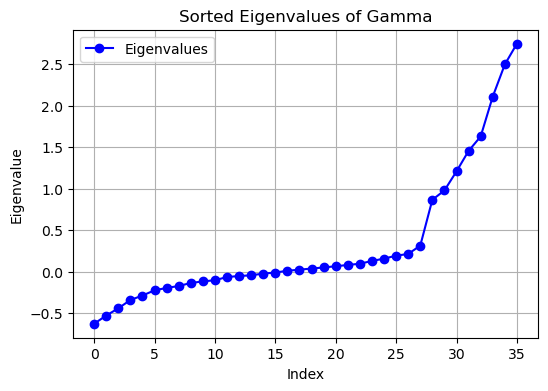

In [ ]:
# Compute eigenvalues
eigenvalues = jnp.linalg.eigvals(Gamma + Gamma.conj().T) / 2  # Ensure Hermiticity

# Sort the eigenvalues
sorted_eigenvalues = jnp.sort(eigenvalues)

import matplotlib.pyplot as plt

# Plot the sorted eigenvalues as a function of their index
plt.figure(figsize=(6, 4))
plt.plot(range(len(sorted_eigenvalues)), sorted_eigenvalues, marker='o', linestyle='-', color='b', label='Eigenvalues')
plt.title("Sorted Eigenvalues of Gamma")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.show()

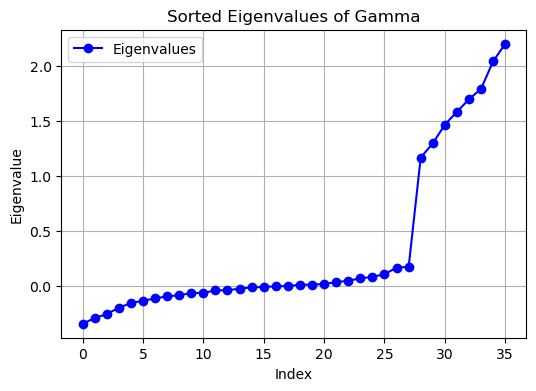

In [ ]:
# Compute eigenvalues
eigenvalues = jnp.linalg.eigvals(Gamma/(area_lattice**2))

# Sort the eigenvalues
sorted_eigenvalues = jnp.sort(eigenvalues)

import matplotlib.pyplot as plt

# Plot the sorted eigenvalues as a function of their index
plt.figure(figsize=(6, 4))
plt.plot(range(len(sorted_eigenvalues)), sorted_eigenvalues, marker='o', linestyle='-', color='b', label='Eigenvalues')
plt.title("Sorted Eigenvalues of Gamma")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.show()

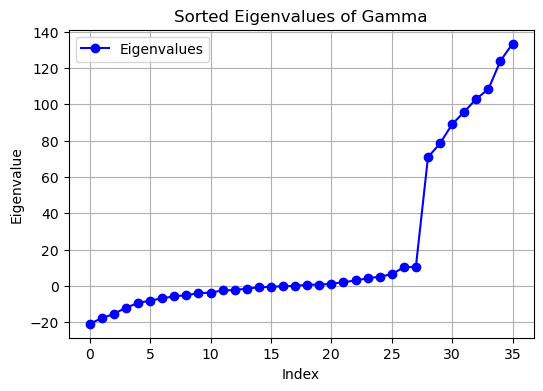

In [ ]:
# Compute eigenvalues
eigenvalues = jnp.linalg.eigvals(Gamma)

# Sort the eigenvalues
sorted_eigenvalues = jnp.sort(eigenvalues)

import matplotlib.pyplot as plt

# Plot the sorted eigenvalues as a function of their index
plt.figure(figsize=(6, 4))
plt.plot(range(len(sorted_eigenvalues)), sorted_eigenvalues, marker='o', linestyle='-', color='b', label='Eigenvalues')
plt.title("Sorted Eigenvalues of Gamma")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.show()

/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/work/submit/ahmed95/miniforge3/envs/py313/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


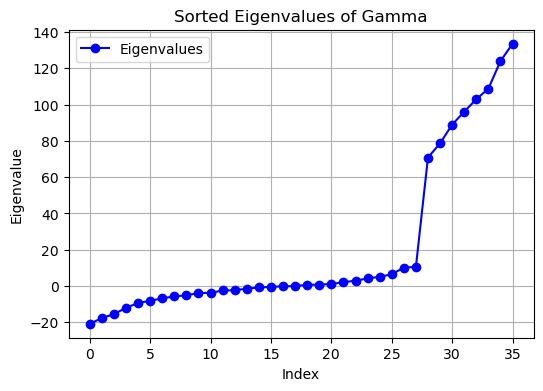

In [ ]:
# Compute eigenvalues
eigenvalues = jnp.linalg.eigvals(Gamma)

# Sort the eigenvalues
sorted_eigenvalues = jnp.sort(eigenvalues)

import matplotlib.pyplot as plt

# Plot the sorted eigenvalues as a function of their index
plt.figure(figsize=(6, 4))
plt.plot(range(len(sorted_eigenvalues)), sorted_eigenvalues, marker='o', linestyle='-', color='b', label='Eigenvalues')
plt.title("Sorted Eigenvalues of Gamma")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sorted_eigenvalues

Array([-5.2836051e+00-0.10494498j, -4.4615345e+00+0.00379992j,
       -3.8392112e+00-0.01430009j, -2.9782751e+00+0.09993143j,
       -2.3130925e+00-0.16434449j, -2.0581360e+00+0.10227248j,
       -1.7110066e+00-0.06091419j, -1.4315834e+00-0.0333219j ,
       -1.2847046e+00-0.00373495j, -1.0825424e+00-0.02887724j,
       -9.2464370e-01+0.01492197j, -6.4133865e-01+0.00205883j,
       -5.0995559e-01-0.13829602j, -3.8178271e-01-0.01750031j,
       -2.0129973e-01-0.04577749j, -1.4718641e-01+0.02616176j,
       -1.8004697e-02-0.04048609j, -1.0271882e-02-0.09036955j,
        1.7121866e-01+0.01874003j,  2.1437517e-01-0.05730071j,
        2.9248658e-01-0.16574366j,  4.9469537e-01+0.03429226j,
        7.6198775e-01-0.08367036j,  1.0012574e+00-0.02615998j,
        1.2789228e+00-0.14491472j,  1.5951517e+00+0.1847901j ,
        2.5272276e+00+0.09041335j,  2.5831571e+00+0.27773562j,
        1.7912201e+01+0.30956897j,  1.9578051e+01+0.42286852j,
        2.2402233e+01+0.0532224j ,  2.4449583e+01-0.052

In [ ]:
eigenvalues_below_10 = jnp.sum(eigenvalues < 20)
print("Number of eigenvalues below 10:", eigenvalues_below_10)

Number of eigenvalues below 10: 28


In [ ]:
import math

def FCI_admissible_confs(N,N_A):
    """
    Count all FCI admissible configurations for N particles in N_k orbitals.
    Each configuration is represented as a sorted tuple of occupied orbital indices.
    """
    count = ((3*N)*math.factorial(3*N-2*N_A-1)) / (math.factorial(N_A)*math.factorial(3*N-3*N_A))
    return count
    

In [ ]:
FCI_admissible_confs(8,2)

228.0

In [ ]:
builder = build_reduced_2RDM_from_enumeration(twoRDM_bandbasis_jit, log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, 
                         kgrid, band_wavefunction, kpt_wavefuncs, M, G1, G2, rlist2, area_lattice, enum, D, jit_compile=True)
Gamma = builder()   # this returns a (D,D) Hermitian matrix

(4,)
(4,)


2025-08-29 18:20:24.991973: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %transpose.92 = f32[1024,4,3,64]{3,1,2,0} transpose(f32[1024,3,4,64]{3,2,1,0} %constant.1113), dimensions={0,2,1,3}, metadata={op_name="jit(builder)/jit(main)/reshape" source_file="/work/submit/ahmed95/ferminet_ahmed/ferminet/psiformer.py" source_line=77}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-08-29 18:20:30.638043: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 6.647069794s
Constant folding an instruction is taking > 1s:

  %transpose.92 = f32[1024,4,3,64]{3,1,2,0} 

In [ ]:
Gamma.shape

(3, 3)

In [ ]:
numx = 10
numy = 10
dAgrid = area_lattice / (numx**2)
rlist2 = [i * (lattice[:,0] / numx) + j * (lattice[:,1] / numy) for i in range(0, numx) for j in range(0, numy)]
rlist2 = jnp.array(rlist2)

NameError: name 'rec' is not defined

In [ ]:
kgrid

Array([[0.       , 0.       ],
       [2.4183993, 0.       ],
       [4.8367987, 0.       ],
       [1.2091997, 2.0943952],
       [3.627599 , 2.0943952],
       [6.0459986, 2.0943952],
       [2.4183993, 4.1887903],
       [4.8367987, 4.1887903],
       [7.255198 , 4.1887903]], dtype=float32)

In [ ]:
# Initialize an empty list to store kpt_wavefunc for each k
kpt_wavefuncs = []

for k in kgrid:
    H = Ham(k, M, b1, b2, V0, phi, kin, lambda_0, Alist, phi2list, momentumfouriergrid) / (2 * kin)
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    # Get the eigenfunctions corresponding to the smallest eigenvalue
    sorted_indices = np.argsort(eigenvalues)  # Indices to sort eigenvalues
    smallest_n_indices = sorted_indices[:1]  # Indices of the smallest n eigenvalues
    kpt_wavefunc = eigenvectors[:, smallest_n_indices]  # Corresponding eigenvectors
    kpt_wavefunc = kpt_wavefunc[:, 0]  # Extract the first eigenvector
    kpt_wavefunc = jnp.array(kpt_wavefunc)  # Convert to JAX array
    kpt_wavefuncs.append(kpt_wavefunc)  # Append to the list

# Convert the list to a JAX array of shape (len(kgrid), ...)
kpt_wavefuncs = jnp.array(kpt_wavefuncs)

NameError: name 'kgrid' is not defined

In [ ]:
twoRDM_bandbasis_jit(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
                         kgrid,  band_wavefunction, kpt_wavefuncs, M, G1, G2, rlist2, area_lattice, eps=1e-12)

Array(-0.11631748-0.05248518j, dtype=complex64)

In [ ]:
kinds = [2,4,6,7]

In [ ]:
twoRDM_bandbasis_mc_importance(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=20, key=None, grid_size=500)


Array(0.00597656-0.00693796j, dtype=complex64)

In [ ]:
kinds = [3,2,2,3]

[3, 2, 2, 3]

In [ ]:
twoRDM_bandbasis_mc_importance(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=40, key=None, grid_size=500)


NameError: name 'log_network' is not defined

In [ ]:
twoRDM_bandbasis_mc_importance(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=30, key=None, grid_size=500)


Array(-0.02311057+0.00243283j, dtype=complex64)

In [ ]:
twoRDM_bandbasis_mc_importance(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=60, key=None, grid_size=500)


Array(-0.0282591+1.9795261e-06j, dtype=complex64)

In [ ]:
twoRDM_bandbasis_mc_importance(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=70, key=None, grid_size=500)


Array(-0.02806636-0.00031029j, dtype=complex64)

In [ ]:
twoRDM_bandbasis_mc_importance(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges, kinds,
    kgrid, band_wavefunction, kpt_wavefuncs,
    M, G1, G2, lattice,
    n_mc_points=60, key=None, grid_size=500)


Array(0.00059018-0.00244579j, dtype=complex64)

In [ ]:
area_lattice**2

Array(60.75, dtype=float32)

In [ ]:
key = jax.random.PRNGKey(0)
key_r1, key_r2 = jax.random.split(key)

# Build samplers for k1, k2 bands
sampler1 = build_band_pdf_and_sampler(
    band_wavefunction, kpt_wavefuncs[1], kgrid[1],
    M, G1, G2, lattice, 500
)
sampler2 = build_band_pdf_and_sampler(
    band_wavefunction, kpt_wavefuncs[1], kgrid[1],
    M, G1, G2, lattice, 500
)

# Sample r1, r2 and get their sampling probabilities
r1_points, p_r1 = sampler1(key_r1, 100)
r2_points, p_r2 = sampler2(key_r2, 100)

In [ ]:
p_r2

Array([0.17861655, 0.17861655, 0.23678775, 0.20681995, 0.20681995,
       0.17861655, 0.17861655, 0.23678775, 0.17861655, 0.30141288,
       0.23678775, 0.26837316, 0.17861655, 0.20681995, 0.20681995,
       0.26837316, 0.17861655, 0.23678775, 0.17861655, 0.17861655,
       0.17861655, 0.20681995, 0.30141288, 0.26837316, 0.17861655,
       0.20681995, 0.26837316, 0.30141288, 0.20681995, 0.23678775,
       0.20681995, 0.17861655, 0.23678775, 0.26837316, 0.17861655,
       0.20681995, 0.17861655, 0.17861655, 0.20681995, 0.17861655,
       0.17861655, 0.17861655, 0.23678775, 0.20681995, 0.26837316,
       0.17861655, 0.30141288, 0.26837316, 0.23678775, 0.26837316,
       0.26837316, 0.17861655, 0.26837316, 0.17861655, 0.23678775,
       0.17861655, 0.20681995, 0.26837316, 0.20681995, 0.26837316,
       0.20681995, 0.23678775, 0.26837316, 0.26837316, 0.30141288,
       0.26837316, 0.30141288, 0.17861655, 0.26837316, 0.26837316,
       0.17861655, 0.30141288, 0.23678775, 0.23678775, 0.23678

In [ ]:
kpt1_wavefunc

NameError: name 'kpt1_wavefunc' is not defined

In [ ]:
oneRDM_bandbasis_MC(
    log_network, gathered_params, reshaped_positions_mapped, reshaped_spins, reshaped_atoms, reshaped_charges,
    kpt1, kpt1, band_wavefunction,
    kpt_wavefunc1, kpt_wavefunc1, M, G1, G2,
    sampler1,  # a sampler built like build_band_pdf_and_sampler
    90)

Array(0.34341013-0.01455381j, dtype=complex64)

Array([4.8367987, 0.       ], dtype=float32)

In [ ]:
0.35286796

# 2RDM (without projection)

In [ ]:
import jax
import jax.numpy as jnp

def two_rdm_binned(log_psi, params, samples, spins, atoms, charges,
                   r1, r2, r3, r4, h=0.1):
    """
    Estimate <c^\dagger(r1)c^\dagger(r2)c(r4)c(r3)> using binning and wavefunction ratios.

    Args:
        log_psi: function(params, positions, spins, atoms, charges) -> scalar log(psi)
        params: NN parameters
        samples: (M, N*2) sampled particle coordinates
        spins, atoms, charges: sample-specific features
        r1, r2, r3, r4: (2,) arrays for positions
        h: bin width for Gaussian smoothing
    """
    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    # Distance weights for r3 and r4 (annihilation points)
    dist_r3 = jnp.linalg.norm(coords - r3[None, None, :], axis=-1)  # (M, N)
    dist_r4 = jnp.linalg.norm(coords - r4[None, None, :], axis=-1)  # (M, N)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges, w_r3, w_r4):
        # Compute psi_ref ONCE per sample

        def loop_i(i, acc_outer):
            wi = w_r3[i]

            def process_i():
                def loop_j(j, acc_inner):
                    wj = w_r4[j]

                    def process_j():
                        # Modify coordinates: move i->r1, j->r2
                        new_coords = sample_coords.at[i].set(r1)
                        new_coords = new_coords.at[j].set(r2)

                        psi_ref = log_psi(params, sample_coords.flatten(), sample_spin, sample_atoms, sample_charges)
                        psi_mod = log_psi(params, new_coords.flatten(), sample_spin,
                                          sample_atoms, sample_charges)

                        return acc_inner + jnp.exp(psi_mod - psi_ref) * wi * wj

                    return jax.lax.cond(wj < h, process_j, lambda: acc_inner)

                return jax.lax.fori_loop(0, N, loop_j, acc_outer)

            return jax.lax.cond(wi < h, process_i, lambda: acc_outer)

        contrib = jax.lax.fori_loop(0, N, loop_i, 0.0 + 0.0j)
        return contrib

    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges, dist_r3, dist_r4)
    return jnp.mean(contribs)


<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2043663/3614620510.py:7: SyntaxWarning: invalid escape sequence '\d'
  Estimate <c^\dagger(r1)c^\dagger(r2)c(r4)c(r3)> using binning and wavefunction ratios.


In [ ]:
r1 = jnp.array([0.5, 0.5])
r2 = jnp.array([1.0, 1.0])
rdm_2 = two_rdm_binned(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins,reshaped_atoms,reshaped_charges, r1, r2,r2,r1 ,h=0.1)
print(rdm_2)

0j


In [ ]:
r1 = jnp.array([0.5, 0.5])
r2 = jnp.array([1.0, 1.0])
rdm_2 = two_rdm_binned(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins,reshaped_atoms,reshaped_charges, r1, r2,r1,r2 ,h=0.1)
print(rdm_2)

(8.355335e-05-9.710128e-05j)


In [ ]:
import jax
import jax.numpy as jnp

def two_rdm_binned_fast_skip(log_psi, params, samples, spins, atoms, charges,
                             r1, r2, r3, r4, h=0.1, weight_thresh=1e-8):
    """
    Estimate 2RDM <c^\dagger(r1) c^\dagger(r2) c(r3) c(r4)> using binning
    and wavefunction ratios, skipping contributions below weight_thresh.
    """

    M, Nd = samples.shape
    N = Nd // 2
    coords = samples.reshape(M, N, 2)  # (M, N, 2)

    # Precompute Gaussian weights for r3 and r4
    dist_r3 = jnp.linalg.norm(coords - r3[None, None, :], axis=-1)  # (M, N)
    dist_r4 = jnp.linalg.norm(coords - r4[None, None, :], axis=-1)  # (M, N)
    weights_r3 = jnp.exp(-0.5 * (dist_r3 / h) ** 2)
    weights_r4 = jnp.exp(-0.5 * (dist_r4 / h) ** 2)

    def sample_contrib(sample_coords, sample_spin, sample_atoms, sample_charges,
                       w_r3, w_r4):

        contrib = 0.0 + 0.0j
        for i in range(N):
            for j in range(N):
                w = w_r3[i] * w_r4[j]
                def compute():
                    coords_mod = sample_coords.at[i].set(r1).at[j].set(r2)
                    psi_mod = log_psi(params, coords_mod.flatten(),
                                      sample_spin, sample_atoms, sample_charges)
                    psi_ref = log_psi(params, sample_coords.flatten(),
                          sample_spin, sample_atoms, sample_charges)
                    return jnp.exp(psi_mod - psi_ref) * w
                contrib += jax.lax.cond(w > weight_thresh, compute, lambda: 0.0 + 0.0j)
        return contrib

    contribs = jax.vmap(sample_contrib)(coords, spins, atoms, charges,
                                        weights_r3, weights_r4)
    return jnp.mean(contribs)


<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_2043663/3147993597.py:7: SyntaxWarning: invalid escape sequence '\d'
  Estimate 2RDM <c^\dagger(r1) c^\dagger(r2) c(r3) c(r4)> using binning


In [ ]:
r1 = jnp.array([0.5, 0.5])
r2 = jnp.array([1.0, 1.0])
rdm_2 = two_rdm_binned_fast_skip(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins,reshaped_atoms,reshaped_charges, r1, r2,r2,r1 ,h=0.1)
print(rdm_2)

/tmp/ipykernel_2043663/3147993597.py:7: SyntaxWarning: invalid escape sequence '\d'
  Estimate 2RDM <c^\dagger(r1) c^\dagger(r2) c(r3) c(r4)> using binning


KeyboardInterrupt: 

In [ ]:
r1 = jnp.array([0.5, 0.5])
r2 = jnp.array([1.0, 1.0])
rdm_2 = two_rdm_binned_fast(log_network, gathered_params, reshaped_positions_mapped, reshaped_spins,reshaped_atoms,reshaped_charges, r1, r2,r2,r1 ,h=0.1)
print(rdm_2)

(-8.348597e-05+9.707635e-05j)
